In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CV'

/content/drive/MyDrive/CV


In [ ]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
#from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [ ]:
from sklearn.metrics import make_scorer
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [ ]:
os.makedirs('./weights', exist_ok=True)

##Dataset

In [ ]:
df_train = pd.read_csv('datasets/kitti_train_1.csv')
df_valid = pd.read_csv('datasets/kitti_valid_1.csv')
df_test = pd.read_csv('datasets/kitti_test_1.csv')

In [ ]:
df_train['class'].unique()

array(['person', 'car', 'truck', 'train', 'bicycle', 'Misc'], dtype=object)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21067 entries, 0 to 21066
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         21067 non-null  object 
 1   class            21067 non-null  object 
 2   xmin             21067 non-null  float64
 3   ymin             21067 non-null  float64
 4   xmax             21067 non-null  float64
 5   ymax             21067 non-null  float64
 6   angle            21067 non-null  float64
 7   zloc             21067 non-null  float64
 8   weather          21067 non-null  object 
 9   depth_x          21067 non-null  int64  
 10  depth_y          21067 non-null  int64  
 11  depth_mean       21067 non-null  float64
 12  depth_min        21067 non-null  float64
 13  depth_median     21067 non-null  float64
 14  depth_max        21067 non-null  float64
 15  depth_mean_trim  21067 non-null  float64
 16  width            21067 non-null  float64
 17  height      

In [ ]:
df_train_filtered = df_train[df_train.zloc < 90].reset_index(drop=True)
df_valid_filtered = df_valid[df_valid.zloc < 90].reset_index(drop=True)
df_test_filtered = df_test[df_test.zloc < 90].reset_index(drop=True)

In [ ]:
train = df_train_filtered.drop(['filename', 'class', 'weather', 'angle', 'depth_min'], axis=1)
valid = df_valid_filtered.drop(['filename', 'class', 'weather', 'angle', 'depth_min'], axis=1)
test = df_test_filtered.drop(['filename', 'class', 'weather', 'angle', 'depth_min'], axis=1)

In [ ]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [ ]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

In [ ]:
X_train_scale = scalerX.transform(X_train)
X_valid_scale = scalerX.transform(X_valid)
X_test_scale = scalerX.transform(X_test)

In [ ]:
# onehot encoding
class_dummy = pd.get_dummies(df_train_filtered['class'])
X_train = pd.concat([pd.DataFrame(X_train_scale), class_dummy], axis=1)
class_dummy = pd.get_dummies(df_valid_filtered['class'])
X_valid = pd.concat([pd.DataFrame(X_valid_scale), class_dummy], axis=1)
class_dummy = pd.get_dummies(df_test_filtered['class'])
X_test = pd.concat([pd.DataFrame(X_test_scale), class_dummy], axis=1)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,Misc,bicycle,car,person,train,truck
0,0.749016,-1.254404,0.762292,1.189756,0.623058,-0.307040,-1.083633,-1.034438,-1.412992,-1.010417,0.032281,1.763313,0,0,0,1,0,0
1,-0.440443,0.185218,-0.679281,-0.853265,-0.511036,-0.447317,2.132394,2.171623,1.101398,2.200969,-0.737491,-0.971415,0,0,1,0,0,0
2,0.541369,0.593687,0.350182,-0.445710,0.448582,-0.126684,0.748156,0.626941,1.158379,0.637467,-0.601106,-0.711367,0,0,1,0,0,0
3,0.379747,-0.086673,0.466071,0.699820,0.535820,0.033633,-0.502190,-0.760928,1.027715,-0.712400,0.263900,0.769949,0,0,1,0,0,0
4,-0.836124,0.315100,-0.970365,-0.648844,-0.890186,-0.327080,0.742459,0.749541,0.432449,0.751532,-0.407433,-0.810202,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21059,0.163571,-0.166769,-0.091561,-1.046480,0.042589,-0.767951,2.107357,2.189070,1.087975,2.198047,-0.795433,-1.029717,0,0,1,0,0,0
21060,0.778809,-0.372242,0.513157,-1.068983,0.609636,-0.707832,1.979410,2.050601,1.166363,2.048073,-0.835551,-0.969006,0,0,1,0,0,0
21061,2.600103,-1.715551,2.369942,-0.635731,2.297356,-0.647713,-0.807305,-0.765060,-1.366189,-0.758288,-0.747082,0.036930,0,0,1,0,0,0
21062,-0.523080,0.698255,-0.464698,0.582085,-0.625117,0.574702,-0.821831,-0.752922,-0.436624,-0.764414,0.187862,0.324269,0,0,1,0,0,0


###RandomForest Tuning

In [ ]:
n_estimators = [50, 100, 200, 300, 500]
max_depth = range(5,35,5)
min_samples_split = [2, 5, 10, 20]
max_features = range(2,12,2)
params = [n_estimators, max_depth, min_samples_split, max_features]

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
import itertools
from tqdm import tqdm 


best_rmse = np.inf
best_mae = np.inf
rmse_best_param = pd.DataFrame()
mae_best_param = pd.DataFrame()

res_df = pd.DataFrame(columns = ['train_mae','valid_mae','train_rmse', 'valid_rmse','n_estimators', 'max_depth', 'min_samples', 'max_features'])

param_list = list(itertools.product(*params))
for n, d, s, f in tqdm(param_list):
  model = RandomForestRegressor(random_state=1, 
                                n_estimators=n, 
                                max_depth=d,
                                min_samples_split=s, 
                                max_features=f, 
                                warm_start = True)
  model.fit(X_train, y_train)

  train_pred = model.predict(X_train)
  valid_pred = model.predict(X_valid)

  train_mse = mean_squared_error(y_train, train_pred)
  train_rmse = train_mse ** 0.5
  train_mae = mean_absolute_error(y_train, train_pred)
  val_mse = mean_squared_error(y_valid, valid_pred)
  val_rmse = val_mse ** 0.5
  val_mae = mean_absolute_error(y_valid, valid_pred)

  res = pd.DataFrame([{'train_mae':train_mae, 'valid_mae': val_mae, 'train_rmse' : train_rmse, 'valid_rmse': val_rmse,
                       'n_estimators':n, 'max_depth':d, 'min_samples':s, 'max_features':f}])
  res_df = pd.concat([res_df, res])

  if best_rmse > val_rmse:
    rmse_best_param = res
    best_rmse = val_rmse
  if best_mae > val_mae:
    mae_best_param = res
    best_mae = val_mae
  print("Train_RMSE : {0}, Valid_RMSE: {1}, Train_MAE: {2}, Valid_MAE: {3}, n_estimators:{4}, max_depth: {5}, min_samples: {6}, max_features: {7}".format(train_rmse, val_rmse, train_mae, val_mae, n, d, s, f))

  0%|          | 1/840 [00:00<11:02,  1.27it/s]

Train_RMSE : 3.7980804154116043, Valid_RMSE: 3.7963951453638956, Train_MAE: 2.3974285506724335, Valid_MAE: 2.438595178938103, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 2


  0%|          | 2/840 [00:02<15:23,  1.10s/it]

Train_RMSE : 3.325737420685493, Valid_RMSE: 3.3832457756950944, Train_MAE: 2.009493997359664, Valid_MAE: 2.046283500754406, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 4


  0%|          | 3/840 [00:03<20:04,  1.44s/it]

Train_RMSE : 3.3068353231222987, Valid_RMSE: 3.3628560631125715, Train_MAE: 1.9889263221222344, Valid_MAE: 2.0167527607796742, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 6


  0%|          | 4/840 [00:06<25:10,  1.81s/it]

Train_RMSE : 3.313436044173902, Valid_RMSE: 3.3865814857887178, Train_MAE: 1.987444560957765, Valid_MAE: 2.0232850468420565, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 8


  1%|          | 5/840 [00:09<29:56,  2.15s/it]

Train_RMSE : 3.3319658106982843, Valid_RMSE: 3.42637318864225, Train_MAE: 1.9910562882673708, Valid_MAE: 2.03813666695438, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 10


  1%|          | 6/840 [00:09<23:19,  1.68s/it]

Train_RMSE : 3.776285135890078, Valid_RMSE: 3.775201694233356, Train_MAE: 2.388652206176677, Valid_MAE: 2.430486417778023, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 2


  1%|          | 7/840 [00:11<21:25,  1.54s/it]

Train_RMSE : 3.3281856997136794, Valid_RMSE: 3.3854904067756784, Train_MAE: 2.011480779177899, Valid_MAE: 2.0485196140093187, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 4


  1%|          | 8/840 [00:12<22:22,  1.61s/it]

Train_RMSE : 3.3068353231222987, Valid_RMSE: 3.3628560631125715, Train_MAE: 1.9889263221222344, Valid_MAE: 2.0167527607796742, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 6


  1%|          | 9/840 [00:15<25:11,  1.82s/it]

Train_RMSE : 3.313436044173902, Valid_RMSE: 3.3865814857887178, Train_MAE: 1.987444560957765, Valid_MAE: 2.0232850468420565, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 8


  1%|          | 10/840 [00:17<29:09,  2.11s/it]

Train_RMSE : 3.3319658106982843, Valid_RMSE: 3.42637318864225, Train_MAE: 1.9910562882673708, Valid_MAE: 2.03813666695438, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 10


  1%|▏         | 11/840 [00:18<23:29,  1.70s/it]

Train_RMSE : 3.7927961090374813, Valid_RMSE: 3.7845460093011596, Train_MAE: 2.3883592866698558, Valid_MAE: 2.429778597165551, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 2


  1%|▏         | 12/840 [00:19<21:37,  1.57s/it]

Train_RMSE : 3.3295400846829026, Valid_RMSE: 3.38679762004819, Train_MAE: 2.012486007878073, Valid_MAE: 2.049502590598277, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 4


  2%|▏         | 13/840 [00:21<22:32,  1.64s/it]

Train_RMSE : 3.3068353231222987, Valid_RMSE: 3.3628560631125715, Train_MAE: 1.9889263221222344, Valid_MAE: 2.0167527607796742, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 6


  2%|▏         | 14/840 [00:24<25:16,  1.84s/it]

Train_RMSE : 3.313436044173902, Valid_RMSE: 3.3865814857887178, Train_MAE: 1.987444560957765, Valid_MAE: 2.0232850468420565, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 8


  2%|▏         | 15/840 [00:26<29:17,  2.13s/it]

Train_RMSE : 3.3319658106982843, Valid_RMSE: 3.42637318864225, Train_MAE: 1.9910562882673708, Valid_MAE: 2.03813666695438, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 10


  2%|▏         | 16/840 [00:27<23:46,  1.73s/it]

Train_RMSE : 3.8123385568589865, Valid_RMSE: 3.801926643095078, Train_MAE: 2.387235140374568, Valid_MAE: 2.428656237714152, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 2


  2%|▏         | 17/840 [00:28<21:55,  1.60s/it]

Train_RMSE : 3.3309661170915446, Valid_RMSE: 3.3880593212090133, Train_MAE: 2.013397580408175, Valid_MAE: 2.0501720377080077, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 4


  2%|▏         | 18/840 [00:30<22:55,  1.67s/it]

Train_RMSE : 3.309989555866713, Valid_RMSE: 3.3679778824628257, Train_MAE: 1.9893947042724154, Valid_MAE: 2.0183648205666356, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 6


  2%|▏         | 19/840 [00:33<25:43,  1.88s/it]

Train_RMSE : 3.3145998140260122, Valid_RMSE: 3.3874756644675013, Train_MAE: 1.9878470811837918, Valid_MAE: 2.0238460250915886, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 8


  2%|▏         | 20/840 [00:35<29:37,  2.17s/it]

Train_RMSE : 3.3319658106982843, Valid_RMSE: 3.42637318864225, Train_MAE: 1.9910562882673708, Valid_MAE: 2.03813666695438, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 10


  2%|▎         | 21/840 [00:37<26:31,  1.94s/it]

Train_RMSE : 2.570156476467946, Valid_RMSE: 2.8947400405093076, Train_MAE: 1.5199969284994357, Valid_MAE: 1.704135039931241, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 2


  3%|▎         | 22/840 [00:39<28:02,  2.06s/it]

Train_RMSE : 2.3529822782802126, Valid_RMSE: 2.904370596591667, Train_MAE: 1.4018828880037657, Valid_MAE: 1.6602254061455792, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 4


  3%|▎         | 23/840 [00:42<32:49,  2.41s/it]

Train_RMSE : 2.3038261823218718, Valid_RMSE: 2.884349563198184, Train_MAE: 1.3860495940527264, Valid_MAE: 1.6595624598578427, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 6


  3%|▎         | 24/840 [00:47<39:37,  2.91s/it]

Train_RMSE : 2.2673366368570127, Valid_RMSE: 2.9252665153475887, Train_MAE: 1.372999479102418, Valid_MAE: 1.669669388255846, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 8


  3%|▎         | 25/840 [00:51<47:50,  3.52s/it]

Train_RMSE : 2.2583909476365136, Valid_RMSE: 2.9423695162377204, Train_MAE: 1.3708130514886123, Valid_MAE: 1.6819902823932307, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 10


  3%|▎         | 26/840 [00:53<38:54,  2.87s/it]

Train_RMSE : 2.6110600731917284, Valid_RMSE: 2.926068023085028, Train_MAE: 1.5348968499884612, Valid_MAE: 1.7187764274395008, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 2


  3%|▎         | 27/840 [00:55<36:30,  2.69s/it]

Train_RMSE : 2.396335621562964, Valid_RMSE: 2.890377691364051, Train_MAE: 1.4200011778183024, Valid_MAE: 1.663199132818586, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 4


  3%|▎         | 28/840 [00:58<38:52,  2.87s/it]

Train_RMSE : 2.336791444282893, Valid_RMSE: 2.8897301898875187, Train_MAE: 1.3966208780397125, Valid_MAE: 1.659733218135444, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 6


  3%|▎         | 29/840 [01:03<45:48,  3.39s/it]

Train_RMSE : 2.304432580207981, Valid_RMSE: 2.9364498677972324, Train_MAE: 1.386331378258238, Valid_MAE: 1.6777226057342989, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 8


  4%|▎         | 30/840 [01:08<53:33,  3.97s/it]

Train_RMSE : 2.2956941000776983, Valid_RMSE: 2.919137511917981, Train_MAE: 1.3813484167269696, Valid_MAE: 1.6677784596060172, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 10


  4%|▎         | 31/840 [01:10<43:42,  3.24s/it]

Train_RMSE : 2.635927632941711, Valid_RMSE: 2.9230889949823, Train_MAE: 1.5486406890301891, Valid_MAE: 1.7123494951932967, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 2


  4%|▍         | 32/840 [01:12<40:22,  3.00s/it]

Train_RMSE : 2.4538020872065527, Valid_RMSE: 2.891617726282216, Train_MAE: 1.4431008941423056, Valid_MAE: 1.662261355368098, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 4


  4%|▍         | 33/840 [01:16<41:29,  3.09s/it]

Train_RMSE : 2.392369161566213, Valid_RMSE: 2.919736901250385, Train_MAE: 1.4143365563531547, Valid_MAE: 1.6659305407393425, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 6


  4%|▍         | 34/840 [01:20<47:44,  3.55s/it]

Train_RMSE : 2.3689625225086415, Valid_RMSE: 2.9393791538123346, Train_MAE: 1.411755122951374, Valid_MAE: 1.6817561998666122, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 8


  4%|▍         | 35/840 [01:25<53:44,  4.01s/it]

Train_RMSE : 2.3611841410300087, Valid_RMSE: 2.9352119238779943, Train_MAE: 1.4089732747322121, Valid_MAE: 1.676443295899436, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 10


  4%|▍         | 36/840 [01:27<43:12,  3.22s/it]

Train_RMSE : 2.6993158625064124, Valid_RMSE: 2.9322627650634203, Train_MAE: 1.583231978966244, Valid_MAE: 1.7228094106576282, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 2


  4%|▍         | 37/840 [01:29<39:14,  2.93s/it]

Train_RMSE : 2.5274811521752625, Valid_RMSE: 2.922494921791727, Train_MAE: 1.4806577647693095, Valid_MAE: 1.6794404165509713, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 4


  5%|▍         | 38/840 [01:32<40:17,  3.01s/it]

Train_RMSE : 2.463547593481514, Valid_RMSE: 2.9411885373586792, Train_MAE: 1.4544170461939092, Valid_MAE: 1.676111319993168, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 6


  5%|▍         | 39/840 [01:36<44:58,  3.37s/it]

Train_RMSE : 2.4494847531377477, Valid_RMSE: 2.950159366851926, Train_MAE: 1.4495683218150195, Valid_MAE: 1.6840755011510238, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 8


  5%|▍         | 40/840 [01:41<51:26,  3.86s/it]

Train_RMSE : 2.444809663047419, Valid_RMSE: 2.966423515384462, Train_MAE: 1.4495903192765391, Valid_MAE: 1.6927677866753499, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 10


  5%|▍         | 41/840 [01:43<44:09,  3.32s/it]

Train_RMSE : 1.6395198779103728, Valid_RMSE: 2.725468686064572, Train_MAE: 0.9750285065244069, Valid_MAE: 1.5536111463709459, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 2


  5%|▌         | 42/840 [01:48<47:25,  3.57s/it]

Train_RMSE : 1.4570875078200212, Valid_RMSE: 2.759643014808096, Train_MAE: 0.8906594113145481, Valid_MAE: 1.5642851046791193, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 4


  5%|▌         | 43/840 [01:52<49:54,  3.76s/it]

Train_RMSE : 1.4197176345581903, Valid_RMSE: 2.791724781567513, Train_MAE: 0.8800090490318542, Valid_MAE: 1.587423369902082, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 6


  5%|▌         | 44/840 [01:57<56:12,  4.24s/it]

Train_RMSE : 1.4133578576349952, Valid_RMSE: 2.8389615918657714, Train_MAE: 0.8775314190746265, Valid_MAE: 1.597883377320536, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 8


  5%|▌         | 45/840 [02:04<1:04:50,  4.89s/it]

Train_RMSE : 1.402291825405778, Valid_RMSE: 2.8413887440904646, Train_MAE: 0.8792977192385404, Valid_MAE: 1.599914276177119, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 10


  5%|▌         | 46/840 [02:05<52:29,  3.97s/it]  

Train_RMSE : 1.8127849056359104, Valid_RMSE: 2.7597490276046983, Train_MAE: 1.0579712225056221, Valid_MAE: 1.5696635869387003, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 2


  6%|▌         | 47/840 [02:08<48:09,  3.64s/it]

Train_RMSE : 1.6116875545412703, Valid_RMSE: 2.7960742941887085, Train_MAE: 0.9550018610441967, Valid_MAE: 1.574723701744163, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 4


  6%|▌         | 48/840 [02:12<49:33,  3.75s/it]

Train_RMSE : 1.5602995754461844, Valid_RMSE: 2.8011471106607804, Train_MAE: 0.9334947626266317, Valid_MAE: 1.5816473586283206, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 6


  6%|▌         | 49/840 [02:17<54:59,  4.17s/it]

Train_RMSE : 1.5524927660851289, Valid_RMSE: 2.8203801227613785, Train_MAE: 0.930305663985174, Valid_MAE: 1.59138864543873, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 8


  6%|▌         | 50/840 [02:24<1:03:28,  4.82s/it]

Train_RMSE : 1.5515919341186348, Valid_RMSE: 2.866175904451446, Train_MAE: 0.9331629214545526, Valid_MAE: 1.6132585579084349, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 10


  6%|▌         | 51/840 [02:25<51:11,  3.89s/it]  

Train_RMSE : 2.0033549183826045, Valid_RMSE: 2.7716988414180608, Train_MAE: 1.1632154726120307, Valid_MAE: 1.5832477503736826, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 2


  6%|▌         | 52/840 [02:28<46:43,  3.56s/it]

Train_RMSE : 1.8388408279158877, Valid_RMSE: 2.7899030066471466, Train_MAE: 1.0714943366781404, Valid_MAE: 1.584209972530487, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 4


  6%|▋         | 53/840 [02:32<48:11,  3.67s/it]

Train_RMSE : 1.791781852003444, Valid_RMSE: 2.7927432389299307, Train_MAE: 1.0475698733034107, Valid_MAE: 1.581969333612783, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 6


  6%|▋         | 54/840 [02:37<53:30,  4.08s/it]

Train_RMSE : 1.7666680275000457, Valid_RMSE: 2.8276002810550693, Train_MAE: 1.03745739205388, Valid_MAE: 1.591597163381054, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 8


  7%|▋         | 55/840 [02:43<1:01:25,  4.70s/it]

Train_RMSE : 1.76904993818534, Valid_RMSE: 2.8545357245959164, Train_MAE: 1.0364357518876075, Valid_MAE: 1.6093624048853392, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 10


  7%|▋         | 56/840 [02:45<49:22,  3.78s/it]  

Train_RMSE : 2.2397262426737674, Valid_RMSE: 2.802127648743438, Train_MAE: 1.2980971273800765, Valid_MAE: 1.6137261634497986, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 2


  7%|▋         | 57/840 [02:48<45:02,  3.45s/it]

Train_RMSE : 2.1040445076174192, Valid_RMSE: 2.8318999548293466, Train_MAE: 1.2168473117729843, Valid_MAE: 1.6066557622226048, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 4


  7%|▋         | 58/840 [02:51<46:22,  3.56s/it]

Train_RMSE : 2.060209861269494, Valid_RMSE: 2.861945909703381, Train_MAE: 1.1904578254963807, Valid_MAE: 1.6146208234174781, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 6


  7%|▋         | 59/840 [02:56<51:24,  3.95s/it]

Train_RMSE : 2.033552350183795, Valid_RMSE: 2.8785389307056826, Train_MAE: 1.1803913152740846, Valid_MAE: 1.6197548692495944, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 8


  7%|▋         | 60/840 [03:02<59:05,  4.55s/it]

Train_RMSE : 2.0292097281128427, Valid_RMSE: 2.895673073270773, Train_MAE: 1.1782904398773364, Valid_MAE: 1.6334723141229477, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 10


  7%|▋         | 61/840 [03:05<50:29,  3.89s/it]

Train_RMSE : 1.1599375253511954, Valid_RMSE: 2.679393906729595, Train_MAE: 0.6724886826396348, Valid_MAE: 1.526418699032596, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 2


  7%|▋         | 62/840 [03:08<49:26,  3.81s/it]

Train_RMSE : 1.119460523553343, Valid_RMSE: 2.7241022280729497, Train_MAE: 0.6450399596449897, Valid_MAE: 1.544238628811101, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 4


  8%|▊         | 63/840 [03:13<53:45,  4.15s/it]

Train_RMSE : 1.1194256115085202, Valid_RMSE: 2.7652891002806825, Train_MAE: 0.6459384904893288, Valid_MAE: 1.5608967261102407, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 6


  8%|▊         | 64/840 [03:19<1:01:40,  4.77s/it]

Train_RMSE : 1.1313853528435536, Valid_RMSE: 2.8249788247435137, Train_MAE: 0.6496694819852082, Valid_MAE: 1.586400958718791, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 8


  8%|▊         | 65/840 [03:27<1:12:16,  5.59s/it]

Train_RMSE : 1.1361901697214554, Valid_RMSE: 2.8094250784344474, Train_MAE: 0.6542163737118681, Valid_MAE: 1.5789333139212887, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 10


  8%|▊         | 66/840 [03:29<58:28,  4.53s/it]  

Train_RMSE : 1.459130281095537, Valid_RMSE: 2.686455721301929, Train_MAE: 0.8223918010398285, Valid_MAE: 1.5371138714193922, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 2


  8%|▊         | 67/840 [03:32<53:21,  4.14s/it]

Train_RMSE : 1.3733641517849484, Valid_RMSE: 2.757797126610165, Train_MAE: 0.7652687187768673, Valid_MAE: 1.553849950724927, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 4


  8%|▊         | 68/840 [03:37<54:35,  4.24s/it]

Train_RMSE : 1.354907490463609, Valid_RMSE: 2.7848668430139805, Train_MAE: 0.7503794405494975, Valid_MAE: 1.564157626798636, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 6


  8%|▊         | 69/840 [03:42<1:00:15,  4.69s/it]

Train_RMSE : 1.3404501712407817, Valid_RMSE: 2.792221740541162, Train_MAE: 0.7420486029019745, Valid_MAE: 1.5660356039704233, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 8


  8%|▊         | 70/840 [03:49<1:09:03,  5.38s/it]

Train_RMSE : 1.3350075373371282, Valid_RMSE: 2.831119124842563, Train_MAE: 0.7386686697463052, Valid_MAE: 1.586370919243252, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 10


  8%|▊         | 71/840 [03:51<55:26,  4.33s/it]  

Train_RMSE : 1.8008439993506673, Valid_RMSE: 2.7511640645515527, Train_MAE: 1.018681433390503, Valid_MAE: 1.5564651582704478, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 2


  9%|▊         | 72/840 [03:54<50:26,  3.94s/it]

Train_RMSE : 1.6850346323161336, Valid_RMSE: 2.7554058736913642, Train_MAE: 0.9461188194513004, Valid_MAE: 1.5543348732234217, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 4


  9%|▊         | 73/840 [03:59<51:28,  4.03s/it]

Train_RMSE : 1.6501018336691953, Valid_RMSE: 2.803341500566363, Train_MAE: 0.9185791428644803, Valid_MAE: 1.5747629555901845, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 6


  9%|▉         | 74/840 [04:04<56:50,  4.45s/it]

Train_RMSE : 1.6229143576741725, Valid_RMSE: 2.825087240598411, Train_MAE: 0.9014339691628139, Valid_MAE: 1.5886047337860956, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 8


  9%|▉         | 75/840 [04:11<1:05:18,  5.12s/it]

Train_RMSE : 1.6210774011507718, Valid_RMSE: 2.852848793487525, Train_MAE: 0.8995841532174622, Valid_MAE: 1.5994271519741134, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 10


  9%|▉         | 76/840 [04:12<52:14,  4.10s/it]  

Train_RMSE : 2.1294888022869154, Valid_RMSE: 2.80702708757918, Train_MAE: 1.2222910009302939, Valid_MAE: 1.602098441666618, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 2


  9%|▉         | 77/840 [04:15<47:14,  3.72s/it]

Train_RMSE : 2.0355602340956755, Valid_RMSE: 2.8335424431709395, Train_MAE: 1.1556508604592952, Valid_MAE: 1.5972488624893473, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 4


  9%|▉         | 78/840 [04:20<51:23,  4.05s/it]

Train_RMSE : 1.983738982027747, Valid_RMSE: 2.824933879212078, Train_MAE: 1.1248077958223994, Valid_MAE: 1.5976516046053262, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 6


  9%|▉         | 79/840 [04:27<1:03:37,  5.02s/it]

Train_RMSE : 1.9641506730045986, Valid_RMSE: 2.8784041264573004, Train_MAE: 1.106429991727009, Valid_MAE: 1.6160734375018613, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 8


 10%|▉         | 80/840 [04:36<1:18:09,  6.17s/it]

Train_RMSE : 1.9499574928495462, Valid_RMSE: 2.8898157645273392, Train_MAE: 1.0985263348600647, Valid_MAE: 1.6135150604925517, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 10


 10%|▉         | 81/840 [04:39<1:06:43,  5.28s/it]

Train_RMSE : 1.071588282769352, Valid_RMSE: 2.7040426873084837, Train_MAE: 0.5986588401123494, Valid_MAE: 1.5349583856110136, n_estimators:50, max_depth: 25, min_samples: 2, max_features: 2


 10%|▉         | 82/840 [04:45<1:07:29,  5.34s/it]

Train_RMSE : 1.0783947443766746, Valid_RMSE: 2.747249516492329, Train_MAE: 0.5976434160460428, Valid_MAE: 1.54670718318107, n_estimators:50, max_depth: 25, min_samples: 2, max_features: 4


 10%|▉         | 83/840 [04:55<1:23:58,  6.66s/it]

Train_RMSE : 1.0864738003330499, Valid_RMSE: 2.7779627482274987, Train_MAE: 0.6007424218477291, Valid_MAE: 1.5700925631716007, n_estimators:50, max_depth: 25, min_samples: 2, max_features: 6


 10%|█         | 84/840 [05:06<1:42:43,  8.15s/it]

Train_RMSE : 1.0910546892522044, Valid_RMSE: 2.8029326553373286, Train_MAE: 0.6009717761639666, Valid_MAE: 1.5734070104532816, n_estimators:50, max_depth: 25, min_samples: 2, max_features: 8


 10%|█         | 85/840 [05:15<1:46:17,  8.45s/it]

Train_RMSE : 1.096503665543339, Valid_RMSE: 2.811086516749149, Train_MAE: 0.6043919279856257, Valid_MAE: 1.5776323092837243, n_estimators:50, max_depth: 25, min_samples: 2, max_features: 10


 10%|█         | 86/840 [05:17<1:22:13,  6.54s/it]

Train_RMSE : 1.4118148871508573, Valid_RMSE: 2.7117343493253263, Train_MAE: 0.7793632051408192, Valid_MAE: 1.5383197296957576, n_estimators:50, max_depth: 25, min_samples: 5, max_features: 2


 10%|█         | 87/840 [05:21<1:10:00,  5.58s/it]

Train_RMSE : 1.3496703526647844, Valid_RMSE: 2.7688125440045934, Train_MAE: 0.7326174304793119, Valid_MAE: 1.5575412672686597, n_estimators:50, max_depth: 25, min_samples: 5, max_features: 4


 10%|█         | 88/840 [05:25<1:06:18,  5.29s/it]

Train_RMSE : 1.3352167429571764, Valid_RMSE: 2.7847630642557295, Train_MAE: 0.7135556687459736, Valid_MAE: 1.5666917425109066, n_estimators:50, max_depth: 25, min_samples: 5, max_features: 6


 11%|█         | 89/840 [05:31<1:08:35,  5.48s/it]

Train_RMSE : 1.3103525908471545, Valid_RMSE: 2.821221095474412, Train_MAE: 0.7004870175763064, Valid_MAE: 1.5825522940800054, n_estimators:50, max_depth: 25, min_samples: 5, max_features: 8


 11%|█         | 90/840 [05:39<1:15:09,  6.01s/it]

Train_RMSE : 1.3056636870395495, Valid_RMSE: 2.8318315722193734, Train_MAE: 0.6962906729502412, Valid_MAE: 1.5915263259074306, n_estimators:50, max_depth: 25, min_samples: 5, max_features: 10


 11%|█         | 91/840 [05:41<59:41,  4.78s/it]  

Train_RMSE : 1.7687244467598109, Valid_RMSE: 2.7291343851457808, Train_MAE: 0.9939610444631295, Valid_MAE: 1.5519293134791743, n_estimators:50, max_depth: 25, min_samples: 10, max_features: 2


 11%|█         | 92/840 [05:44<53:12,  4.27s/it]

Train_RMSE : 1.677239108047013, Valid_RMSE: 2.7814499810009323, Train_MAE: 0.9287988088370055, Valid_MAE: 1.5672613175455352, n_estimators:50, max_depth: 25, min_samples: 10, max_features: 4


 11%|█         | 93/840 [05:48<53:25,  4.29s/it]

Train_RMSE : 1.6327458864850883, Valid_RMSE: 2.778337603581949, Train_MAE: 0.8955637337961048, Valid_MAE: 1.5588745888652282, n_estimators:50, max_depth: 25, min_samples: 10, max_features: 6


 11%|█         | 94/840 [05:54<58:13,  4.68s/it]

Train_RMSE : 1.6085756823803616, Valid_RMSE: 2.839077303038225, Train_MAE: 0.8830398353382457, Valid_MAE: 1.5938138960198474, n_estimators:50, max_depth: 25, min_samples: 10, max_features: 8


 11%|█▏        | 95/840 [06:00<1:06:15,  5.34s/it]

Train_RMSE : 1.6091646527147587, Valid_RMSE: 2.866781168215683, Train_MAE: 0.8745999982578111, Valid_MAE: 1.5991523569527846, n_estimators:50, max_depth: 25, min_samples: 10, max_features: 10


 11%|█▏        | 96/840 [06:02<52:49,  4.26s/it]  

Train_RMSE : 2.130778676228073, Valid_RMSE: 2.8089367647850985, Train_MAE: 1.2186384009607036, Valid_MAE: 1.607451302859536, n_estimators:50, max_depth: 25, min_samples: 20, max_features: 2


 12%|█▏        | 97/840 [06:05<47:25,  3.83s/it]

Train_RMSE : 2.031276063895987, Valid_RMSE: 2.824878752589435, Train_MAE: 1.1480445326866675, Valid_MAE: 1.5881498653873842, n_estimators:50, max_depth: 25, min_samples: 20, max_features: 4


 12%|█▏        | 98/840 [06:09<48:03,  3.89s/it]

Train_RMSE : 1.9781602041189272, Valid_RMSE: 2.8385739347564947, Train_MAE: 1.1141174119580683, Valid_MAE: 1.5959224086962411, n_estimators:50, max_depth: 25, min_samples: 20, max_features: 6


 12%|█▏        | 99/840 [06:14<52:56,  4.29s/it]

Train_RMSE : 1.9452990534009875, Valid_RMSE: 2.8489096540293337, Train_MAE: 1.094629332804477, Valid_MAE: 1.6027402998954532, n_estimators:50, max_depth: 25, min_samples: 20, max_features: 8


 12%|█▏        | 100/840 [06:21<1:00:53,  4.94s/it]

Train_RMSE : 1.9414370914817953, Valid_RMSE: 2.8838883908944957, Train_MAE: 1.0870648288166171, Valid_MAE: 1.622830261971124, n_estimators:50, max_depth: 25, min_samples: 20, max_features: 10


 12%|█▏        | 101/840 [06:23<51:50,  4.21s/it]  

Train_RMSE : 1.0639242054355043, Valid_RMSE: 2.66758335555167, Train_MAE: 0.5908712793760097, Valid_MAE: 1.5189389395157464, n_estimators:50, max_depth: 30, min_samples: 2, max_features: 2


 12%|█▏        | 102/840 [06:27<50:15,  4.09s/it]

Train_RMSE : 1.0705082428369774, Valid_RMSE: 2.737163599871791, Train_MAE: 0.5892995773673931, Valid_MAE: 1.5449789306377009, n_estimators:50, max_depth: 30, min_samples: 2, max_features: 4


 12%|█▏        | 103/840 [06:32<54:10,  4.41s/it]

Train_RMSE : 1.0792117832644998, Valid_RMSE: 2.775060220963963, Train_MAE: 0.5912146222491044, Valid_MAE: 1.5623329795090466, n_estimators:50, max_depth: 30, min_samples: 2, max_features: 6


 12%|█▏        | 104/840 [06:39<1:04:42,  5.27s/it]

Train_RMSE : 1.0879478420572828, Valid_RMSE: 2.805586310190019, Train_MAE: 0.5957635191405436, Valid_MAE: 1.5759424842490914, n_estimators:50, max_depth: 30, min_samples: 2, max_features: 8


 12%|█▎        | 105/840 [06:49<1:19:49,  6.52s/it]

Train_RMSE : 1.0910600774800192, Valid_RMSE: 2.8329742232152455, Train_MAE: 0.5973944655532084, Valid_MAE: 1.5929856628281054, n_estimators:50, max_depth: 30, min_samples: 2, max_features: 10


 13%|█▎        | 106/840 [06:51<1:03:39,  5.20s/it]

Train_RMSE : 1.413238767211529, Valid_RMSE: 2.695884280017511, Train_MAE: 0.774977283414094, Valid_MAE: 1.5298092429983459, n_estimators:50, max_depth: 30, min_samples: 5, max_features: 2


 13%|█▎        | 107/840 [06:54<56:46,  4.65s/it]  

Train_RMSE : 1.3433103474153831, Valid_RMSE: 2.740353819123077, Train_MAE: 0.723025849698655, Valid_MAE: 1.5473653083127266, n_estimators:50, max_depth: 30, min_samples: 5, max_features: 4


 13%|█▎        | 108/840 [06:59<56:41,  4.65s/it]

Train_RMSE : 1.3139370322590238, Valid_RMSE: 2.756514745048476, Train_MAE: 0.7023285718168217, Valid_MAE: 1.5541480710039015, n_estimators:50, max_depth: 30, min_samples: 5, max_features: 6


 13%|█▎        | 109/840 [07:05<1:01:29,  5.05s/it]

Train_RMSE : 1.3095704010690132, Valid_RMSE: 2.8122873882116908, Train_MAE: 0.6983070638341078, Valid_MAE: 1.5848570908177242, n_estimators:50, max_depth: 30, min_samples: 5, max_features: 8


 13%|█▎        | 110/840 [07:12<1:09:51,  5.74s/it]

Train_RMSE : 1.3090189155212744, Valid_RMSE: 2.8359035559668073, Train_MAE: 0.6941251095904841, Valid_MAE: 1.6008315538477613, n_estimators:50, max_depth: 30, min_samples: 5, max_features: 10


 13%|█▎        | 111/840 [07:14<55:51,  4.60s/it]  

Train_RMSE : 1.7620389129930383, Valid_RMSE: 2.7292660521891627, Train_MAE: 0.9939829004878701, Valid_MAE: 1.5600748179436266, n_estimators:50, max_depth: 30, min_samples: 10, max_features: 2


 13%|█▎        | 112/840 [07:17<50:19,  4.15s/it]

Train_RMSE : 1.6768934999067988, Valid_RMSE: 2.7630219228854265, Train_MAE: 0.9279903465503025, Valid_MAE: 1.5566645024641936, n_estimators:50, max_depth: 30, min_samples: 10, max_features: 4


 13%|█▎        | 113/840 [07:22<51:03,  4.21s/it]

Train_RMSE : 1.6270838695595402, Valid_RMSE: 2.8053348092033503, Train_MAE: 0.8954975269286108, Valid_MAE: 1.5756165582517325, n_estimators:50, max_depth: 30, min_samples: 10, max_features: 6


 14%|█▎        | 114/840 [07:27<55:52,  4.62s/it]

Train_RMSE : 1.6122842567727518, Valid_RMSE: 2.8307569787226683, Train_MAE: 0.8781760514731553, Valid_MAE: 1.585677932703816, n_estimators:50, max_depth: 30, min_samples: 10, max_features: 8


 14%|█▎        | 115/840 [07:36<1:10:14,  5.81s/it]

Train_RMSE : 1.5943438648390478, Valid_RMSE: 2.848152220553312, Train_MAE: 0.8700980812880744, Valid_MAE: 1.5949699171715936, n_estimators:50, max_depth: 30, min_samples: 10, max_features: 10


 14%|█▍        | 116/840 [07:39<59:52,  4.96s/it]  

Train_RMSE : 2.1282994519354057, Valid_RMSE: 2.79114646527801, Train_MAE: 1.221316783450016, Valid_MAE: 1.6016900749712086, n_estimators:50, max_depth: 30, min_samples: 20, max_features: 2


 14%|█▍        | 117/840 [07:43<56:18,  4.67s/it]

Train_RMSE : 2.0265114037388225, Valid_RMSE: 2.8235686812097454, Train_MAE: 1.1467497106656552, Valid_MAE: 1.5996500993332776, n_estimators:50, max_depth: 30, min_samples: 20, max_features: 4


 14%|█▍        | 118/840 [07:54<1:20:50,  6.72s/it]

Train_RMSE : 1.977531817693218, Valid_RMSE: 2.8423577020280693, Train_MAE: 1.1164607731162908, Valid_MAE: 1.599240822672237, n_estimators:50, max_depth: 30, min_samples: 20, max_features: 6


 14%|█▍        | 119/840 [08:05<1:33:22,  7.77s/it]

Train_RMSE : 1.957317321006091, Valid_RMSE: 2.8639678207342207, Train_MAE: 1.0995014091348794, Valid_MAE: 1.6084268349701625, n_estimators:50, max_depth: 30, min_samples: 20, max_features: 8


 14%|█▍        | 120/840 [08:15<1:41:42,  8.48s/it]

Train_RMSE : 1.9384500454320317, Valid_RMSE: 2.8880677919500224, Train_MAE: 1.0853661241450239, Valid_MAE: 1.6173949003094759, n_estimators:50, max_depth: 30, min_samples: 20, max_features: 10


 14%|█▍        | 121/840 [08:17<1:19:33,  6.64s/it]

Train_RMSE : 3.715100863607912, Valid_RMSE: 3.7155836645223133, Train_MAE: 2.3427608493520293, Valid_MAE: 2.3830007382780884, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 2


 15%|█▍        | 122/840 [08:21<1:09:32,  5.81s/it]

Train_RMSE : 3.321977658961995, Valid_RMSE: 3.375297168726191, Train_MAE: 2.0114911015229047, Valid_MAE: 2.048685204044316, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 4


 15%|█▍        | 123/840 [08:27<1:10:44,  5.92s/it]

Train_RMSE : 3.296125663170154, Valid_RMSE: 3.355069980708311, Train_MAE: 1.9800853282584492, Valid_MAE: 2.006794527164522, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 6


 15%|█▍        | 124/840 [08:34<1:14:14,  6.22s/it]

Train_RMSE : 3.312869727612945, Valid_RMSE: 3.3931736522200127, Train_MAE: 1.9841117114884717, Valid_MAE: 2.0215091061740678, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 8


 15%|█▍        | 125/840 [08:42<1:21:50,  6.87s/it]

Train_RMSE : 3.3167413924428253, Valid_RMSE: 3.40351401369287, Train_MAE: 1.9818803285963678, Valid_MAE: 2.0212033186446132, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 10


 15%|█▌        | 126/840 [08:45<1:05:45,  5.53s/it]

Train_RMSE : 3.7090504423667476, Valid_RMSE: 3.7095320356518275, Train_MAE: 2.3396823823346793, Valid_MAE: 2.379832767912547, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 2


 15%|█▌        | 127/840 [08:49<59:40,  5.02s/it]  

Train_RMSE : 3.3216514398345542, Valid_RMSE: 3.3741037059913586, Train_MAE: 2.010922365343402, Valid_MAE: 2.0468959253216, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 4


 15%|█▌        | 128/840 [08:55<1:03:04,  5.32s/it]

Train_RMSE : 3.296125663170154, Valid_RMSE: 3.355069980708311, Train_MAE: 1.9800853282584492, Valid_MAE: 2.006794527164522, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 6


 15%|█▌        | 129/840 [09:01<1:08:14,  5.76s/it]

Train_RMSE : 3.312869727612945, Valid_RMSE: 3.3931736522200127, Train_MAE: 1.9841117114884717, Valid_MAE: 2.0215091061740678, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 8


 15%|█▌        | 130/840 [09:10<1:16:55,  6.50s/it]

Train_RMSE : 3.3169834936217977, Valid_RMSE: 3.404177809039242, Train_MAE: 1.9819730262817985, Valid_MAE: 2.021296518926209, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 10


 16%|█▌        | 131/840 [09:12<1:02:13,  5.27s/it]

Train_RMSE : 3.716666435816474, Valid_RMSE: 3.715409565184592, Train_MAE: 2.345205562926291, Valid_MAE: 2.3844449936003445, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 2


 16%|█▌        | 132/840 [09:16<57:51,  4.90s/it]  

Train_RMSE : 3.3226893848102526, Valid_RMSE: 3.3752839043890464, Train_MAE: 2.01153233043478, Valid_MAE: 2.047744693884789, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 4


 16%|█▌        | 133/840 [09:21<59:01,  5.01s/it]

Train_RMSE : 3.296125663170154, Valid_RMSE: 3.355069980708311, Train_MAE: 1.9800853282584492, Valid_MAE: 2.006794527164522, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 6


 16%|█▌        | 134/840 [09:26<57:40,  4.90s/it]

Train_RMSE : 3.312869727612945, Valid_RMSE: 3.3931736522200127, Train_MAE: 1.9841117114884717, Valid_MAE: 2.0215091061740678, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 8


 16%|█▌        | 135/840 [09:31<59:18,  5.05s/it]

Train_RMSE : 3.3169834936217977, Valid_RMSE: 3.404177809039242, Train_MAE: 1.9819730262817985, Valid_MAE: 2.021296518926209, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 10


 16%|█▌        | 136/840 [09:33<46:44,  3.98s/it]

Train_RMSE : 3.6989953218476073, Valid_RMSE: 3.6964237670996924, Train_MAE: 2.3270628090889107, Valid_MAE: 2.3684049741420425, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 2


 16%|█▋        | 137/840 [09:35<41:25,  3.54s/it]

Train_RMSE : 3.322806187356382, Valid_RMSE: 3.376260025384418, Train_MAE: 2.0120899313642, Valid_MAE: 2.048465006468854, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 4


 16%|█▋        | 138/840 [09:39<41:12,  3.52s/it]

Train_RMSE : 3.299354816347467, Valid_RMSE: 3.3581030324314183, Train_MAE: 1.9815394725736568, Valid_MAE: 2.009136690082547, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 6


 17%|█▋        | 139/840 [09:43<44:22,  3.80s/it]

Train_RMSE : 3.313456413140335, Valid_RMSE: 3.3936376308226817, Train_MAE: 1.9843281402997957, Valid_MAE: 2.0218337502121972, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 8


 17%|█▋        | 140/840 [09:49<49:55,  4.28s/it]

Train_RMSE : 3.3169834936217977, Valid_RMSE: 3.404177809039242, Train_MAE: 1.9819730262817985, Valid_MAE: 2.021296518926209, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 10


 17%|█▋        | 141/840 [09:51<43:50,  3.76s/it]

Train_RMSE : 2.5549091775497734, Valid_RMSE: 2.883449916712164, Train_MAE: 1.5082327221628633, Valid_MAE: 1.6931202453650935, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 2


 17%|█▋        | 142/840 [09:56<45:40,  3.93s/it]

Train_RMSE : 2.349832168209868, Valid_RMSE: 2.8851671415766846, Train_MAE: 1.4002057383016362, Valid_MAE: 1.6548377887957144, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 4


 17%|█▋        | 143/840 [10:02<52:55,  4.56s/it]

Train_RMSE : 2.28675585179071, Valid_RMSE: 2.88136788613425, Train_MAE: 1.3765064219780283, Valid_MAE: 1.6537021730945811, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 6


 17%|█▋        | 144/840 [10:09<1:03:56,  5.51s/it]

Train_RMSE : 2.251291308554806, Valid_RMSE: 2.9026800476164776, Train_MAE: 1.364694495048928, Valid_MAE: 1.6572739400367105, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 8


 17%|█▋        | 145/840 [10:19<1:17:26,  6.69s/it]

Train_RMSE : 2.247034891806176, Valid_RMSE: 2.9143079268885357, Train_MAE: 1.365426120056199, Valid_MAE: 1.6651689969134216, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 10


 17%|█▋        | 146/840 [10:21<1:03:01,  5.45s/it]

Train_RMSE : 2.587672627817822, Valid_RMSE: 2.905170239407387, Train_MAE: 1.519747629233929, Valid_MAE: 1.698252290884159, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 2


 18%|█▊        | 147/840 [10:26<58:50,  5.10s/it]  

Train_RMSE : 2.385073670411608, Valid_RMSE: 2.8800382511807587, Train_MAE: 1.4112570610748776, Valid_MAE: 1.6543433806191543, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 4


 18%|█▊        | 148/840 [10:32<1:01:49,  5.36s/it]

Train_RMSE : 2.323518149018985, Valid_RMSE: 2.8798559962103534, Train_MAE: 1.3886064452750482, Valid_MAE: 1.6480856856330917, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 6


 18%|█▊        | 149/840 [10:40<1:12:26,  6.29s/it]

Train_RMSE : 2.293236582169822, Valid_RMSE: 2.9100760224835094, Train_MAE: 1.3783224071424784, Valid_MAE: 1.6631426319340485, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 8


 18%|█▊        | 150/840 [10:50<1:23:27,  7.26s/it]

Train_RMSE : 2.279514696355359, Valid_RMSE: 2.9035609297333798, Train_MAE: 1.373633255016323, Valid_MAE: 1.6592812980584497, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 10


 18%|█▊        | 151/840 [10:52<1:07:06,  5.84s/it]

Train_RMSE : 2.6216361104173003, Valid_RMSE: 2.91066251659305, Train_MAE: 1.5367676294850143, Valid_MAE: 1.7018677111501668, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 2


 18%|█▊        | 152/840 [10:56<1:01:33,  5.37s/it]

Train_RMSE : 2.4474384952982065, Valid_RMSE: 2.8907394907631865, Train_MAE: 1.437448368117263, Valid_MAE: 1.6588783050152751, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 4


 18%|█▊        | 153/840 [11:02<1:03:33,  5.55s/it]

Train_RMSE : 2.3799705549321493, Valid_RMSE: 2.9014264460060546, Train_MAE: 1.4098070068222255, Valid_MAE: 1.655708037651425, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 6


 18%|█▊        | 154/840 [11:10<1:10:46,  6.19s/it]

Train_RMSE : 2.356275158728313, Valid_RMSE: 2.922399845567087, Train_MAE: 1.403916472229784, Valid_MAE: 1.6690562563598477, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 8


 18%|█▊        | 155/840 [11:19<1:21:38,  7.15s/it]

Train_RMSE : 2.3482193718559663, Valid_RMSE: 2.93519898851888, Train_MAE: 1.4034342263425903, Valid_MAE: 1.6708935354202716, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 10


 19%|█▊        | 156/840 [11:22<1:05:38,  5.76s/it]

Train_RMSE : 2.6915556124568343, Valid_RMSE: 2.933243930191032, Train_MAE: 1.576588946076457, Valid_MAE: 1.7205815642177884, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 2


 19%|█▊        | 157/840 [11:26<1:00:12,  5.29s/it]

Train_RMSE : 2.5222700948536847, Valid_RMSE: 2.9207007979423762, Train_MAE: 1.474516960240687, Valid_MAE: 1.6750020712518345, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 4


 19%|█▉        | 158/840 [11:32<1:02:17,  5.48s/it]

Train_RMSE : 2.4590479163470995, Valid_RMSE: 2.9244595741241795, Train_MAE: 1.4511566167053243, Valid_MAE: 1.6649928743461961, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 6


 19%|█▉        | 159/840 [11:40<1:09:39,  6.14s/it]

Train_RMSE : 2.4438035485489755, Valid_RMSE: 2.937861170752085, Train_MAE: 1.4441690131245595, Valid_MAE: 1.6756197822878796, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 8


 19%|█▉        | 160/840 [11:49<1:20:14,  7.08s/it]

Train_RMSE : 2.4280144006997317, Valid_RMSE: 2.9574237285687643, Train_MAE: 1.4403345212076695, Valid_MAE: 1.6838236412053964, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 10


 19%|█▉        | 161/840 [11:53<1:08:40,  6.07s/it]

Train_RMSE : 1.616866581401543, Valid_RMSE: 2.705639959027927, Train_MAE: 0.9627206973259735, Valid_MAE: 1.5393430368306382, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 2


 19%|█▉        | 162/840 [11:59<1:08:17,  6.04s/it]

Train_RMSE : 1.428178455850442, Valid_RMSE: 2.737633592428362, Train_MAE: 0.8763209928439034, Valid_MAE: 1.5491906126467208, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 4


 19%|█▉        | 163/840 [12:07<1:15:39,  6.70s/it]

Train_RMSE : 1.3965147902155113, Valid_RMSE: 2.7848966437255194, Train_MAE: 0.8692615793256117, Valid_MAE: 1.5740452839317005, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 6


 20%|█▉        | 164/840 [12:17<1:28:25,  7.85s/it]

Train_RMSE : 1.3899408037205812, Valid_RMSE: 2.8048274253935483, Train_MAE: 0.8697398805461005, Valid_MAE: 1.578952996023808, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 8


 20%|█▉        | 165/840 [12:32<1:49:41,  9.75s/it]

Train_RMSE : 1.3875130363537154, Valid_RMSE: 2.821696459762104, Train_MAE: 0.8748069053238531, Valid_MAE: 1.5887144677016036, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 10


 20%|█▉        | 166/840 [12:35<1:28:46,  7.90s/it]

Train_RMSE : 1.7873065521461078, Valid_RMSE: 2.732594556689027, Train_MAE: 1.0430559178016519, Valid_MAE: 1.5498371855916748, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 2


 20%|█▉        | 167/840 [12:41<1:21:39,  7.28s/it]

Train_RMSE : 1.592596491630047, Valid_RMSE: 2.7547609061270695, Train_MAE: 0.9437777115064436, Valid_MAE: 1.554165827513733, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 4


 20%|██        | 168/840 [12:49<1:24:20,  7.53s/it]

Train_RMSE : 1.5382742857315879, Valid_RMSE: 2.7724218037086006, Train_MAE: 0.9205151986537597, Valid_MAE: 1.5642838636258396, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 6


 20%|██        | 169/840 [13:00<1:33:46,  8.39s/it]

Train_RMSE : 1.5340293916680434, Valid_RMSE: 2.798799679073015, Train_MAE: 0.9221068137380699, Valid_MAE: 1.5752711363976024, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 8


 20%|██        | 170/840 [13:12<1:47:32,  9.63s/it]

Train_RMSE : 1.5276193599240941, Valid_RMSE: 2.836754819669385, Train_MAE: 0.9230801373394558, Valid_MAE: 1.5941603479571789, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 10


 20%|██        | 171/840 [13:16<1:26:36,  7.77s/it]

Train_RMSE : 1.9892470784723781, Valid_RMSE: 2.7525700681852747, Train_MAE: 1.1539495619246998, Valid_MAE: 1.5712137554494705, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 2


 20%|██        | 172/840 [13:21<1:19:02,  7.10s/it]

Train_RMSE : 1.8234692980351714, Valid_RMSE: 2.761454134564249, Train_MAE: 1.060032273703392, Valid_MAE: 1.5641613470053162, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 4


 21%|██        | 173/840 [13:29<1:21:01,  7.29s/it]

Train_RMSE : 1.7738772351572742, Valid_RMSE: 2.7995258448341107, Train_MAE: 1.038699641567908, Valid_MAE: 1.5799262308609197, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 6


 21%|██        | 174/840 [13:39<1:29:31,  8.06s/it]

Train_RMSE : 1.7531338146791857, Valid_RMSE: 2.8240660231286085, Train_MAE: 1.0306018615313155, Valid_MAE: 1.5852905007995588, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 8


 21%|██        | 175/840 [13:51<1:42:46,  9.27s/it]

Train_RMSE : 1.7487747215854001, Valid_RMSE: 2.8363605581872995, Train_MAE: 1.0296194415599704, Valid_MAE: 1.5957263699172504, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 10


 21%|██        | 176/840 [13:54<1:22:34,  7.46s/it]

Train_RMSE : 2.2367090168965142, Valid_RMSE: 2.8011826443430388, Train_MAE: 1.2934985253396252, Valid_MAE: 1.6082349933327014, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 2


 21%|██        | 177/840 [13:59<1:15:18,  6.82s/it]

Train_RMSE : 2.093449448444698, Valid_RMSE: 2.830367276014487, Train_MAE: 1.2089670237690662, Valid_MAE: 1.5998460335563118, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 4


 21%|██        | 178/840 [14:07<1:17:17,  7.00s/it]

Train_RMSE : 2.0500339224497157, Valid_RMSE: 2.843938002051535, Train_MAE: 1.183691831407329, Valid_MAE: 1.602920361968264, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 6


 21%|██▏       | 179/840 [14:16<1:25:55,  7.80s/it]

Train_RMSE : 2.023945296506277, Valid_RMSE: 2.8493381695539832, Train_MAE: 1.1758452886608706, Valid_MAE: 1.6046745495019263, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 8


 21%|██▏       | 180/840 [14:28<1:38:56,  8.99s/it]

Train_RMSE : 2.0143294207823126, Valid_RMSE: 2.8787217157289873, Train_MAE: 1.1685675376762676, Valid_MAE: 1.6201742035932043, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 10


 22%|██▏       | 181/840 [14:33<1:24:24,  7.68s/it]

Train_RMSE : 1.1268901363293722, Valid_RMSE: 2.670588491853327, Train_MAE: 0.6557654691972182, Valid_MAE: 1.5137245794559813, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 2


 22%|██▏       | 182/840 [14:40<1:22:41,  7.54s/it]

Train_RMSE : 1.0950113071438998, Valid_RMSE: 2.713022402088652, Train_MAE: 0.633944384194774, Valid_MAE: 1.5331611789825188, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 4


 22%|██▏       | 183/840 [14:50<1:29:48,  8.20s/it]

Train_RMSE : 1.0960170741529163, Valid_RMSE: 2.758342921387699, Train_MAE: 0.6369911874216928, Valid_MAE: 1.5474783278424042, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 6


 22%|██▏       | 184/840 [15:02<1:43:25,  9.46s/it]

Train_RMSE : 1.100846979266959, Valid_RMSE: 2.775071008741473, Train_MAE: 0.6364016524577291, Valid_MAE: 1.5604704333058141, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 8


 22%|██▏       | 185/840 [15:17<2:01:48, 11.16s/it]

Train_RMSE : 1.1095331849002807, Valid_RMSE: 2.800572653710855, Train_MAE: 0.6427342820899739, Valid_MAE: 1.56825869978786, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 10


 22%|██▏       | 186/840 [15:21<1:38:37,  9.05s/it]

Train_RMSE : 1.4381359877750781, Valid_RMSE: 2.6876598148582453, Train_MAE: 0.8091321874014158, Valid_MAE: 1.526217969119786, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 2


 22%|██▏       | 187/840 [15:28<1:30:30,  8.32s/it]

Train_RMSE : 1.3527328266584329, Valid_RMSE: 2.742572660950578, Train_MAE: 0.7535500468359544, Valid_MAE: 1.5369413476180367, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 4


 22%|██▏       | 188/840 [15:37<1:33:25,  8.60s/it]

Train_RMSE : 1.3284039961389058, Valid_RMSE: 2.7561175361723866, Train_MAE: 0.7372433997430563, Valid_MAE: 1.5487978970493168, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 6


 22%|██▎       | 189/840 [15:49<1:43:38,  9.55s/it]

Train_RMSE : 1.316068527105775, Valid_RMSE: 2.769425803969255, Train_MAE: 0.7298866222482565, Valid_MAE: 1.5536983481973539, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 8


 23%|██▎       | 190/840 [16:03<1:58:44, 10.96s/it]

Train_RMSE : 1.3087805590788821, Valid_RMSE: 2.8132100748592976, Train_MAE: 0.7271101446375402, Valid_MAE: 1.5722436723451432, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 10


 23%|██▎       | 191/840 [16:07<1:35:26,  8.82s/it]

Train_RMSE : 1.7823996681458836, Valid_RMSE: 2.736792686784164, Train_MAE: 1.0090298017385908, Valid_MAE: 1.547270964703341, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 2


 23%|██▎       | 192/840 [16:13<1:26:49,  8.04s/it]

Train_RMSE : 1.6700905541154185, Valid_RMSE: 2.7519212212920556, Train_MAE: 0.935679644413439, Valid_MAE: 1.5478658483544758, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 4


 23%|██▎       | 193/840 [16:22<1:28:38,  8.22s/it]

Train_RMSE : 1.6346743509022816, Valid_RMSE: 2.782798691561251, Train_MAE: 0.9103081766749246, Valid_MAE: 1.5609372478709385, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 6


 23%|██▎       | 194/840 [16:33<1:37:48,  9.08s/it]

Train_RMSE : 1.6070376260677572, Valid_RMSE: 2.806970719160444, Train_MAE: 0.8929455425394038, Valid_MAE: 1.5777117939914131, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 8


 23%|██▎       | 195/840 [16:56<2:23:19, 13.33s/it]

Train_RMSE : 1.6026633810721032, Valid_RMSE: 2.8310637478999663, Train_MAE: 0.8895958452767401, Valid_MAE: 1.58310596696505, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 10


 23%|██▎       | 196/840 [17:01<1:55:22, 10.75s/it]

Train_RMSE : 2.1182193166561487, Valid_RMSE: 2.7934884689041164, Train_MAE: 1.2121611486557466, Valid_MAE: 1.5896041490058115, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 2


 23%|██▎       | 197/840 [17:07<1:38:59,  9.24s/it]

Train_RMSE : 2.0162327852928703, Valid_RMSE: 2.8135243668496592, Train_MAE: 1.1461547471388278, Valid_MAE: 1.5846101129641268, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 4


 24%|██▎       | 198/840 [17:15<1:35:05,  8.89s/it]

Train_RMSE : 1.9709296504835938, Valid_RMSE: 2.8258358768462823, Train_MAE: 1.1160013826380704, Valid_MAE: 1.5887938972540796, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 6


 24%|██▎       | 199/840 [17:25<1:39:48,  9.34s/it]

Train_RMSE : 1.951014134373011, Valid_RMSE: 2.853201861028223, Train_MAE: 1.0992429389892295, Valid_MAE: 1.603749578628304, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 8


 24%|██▍       | 200/840 [17:38<1:50:44, 10.38s/it]

Train_RMSE : 1.9323901106991224, Valid_RMSE: 2.8649232061964263, Train_MAE: 1.0907022072311756, Valid_MAE: 1.6020958603046753, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 10


 24%|██▍       | 201/840 [17:43<1:33:23,  8.77s/it]

Train_RMSE : 1.0387325065265105, Valid_RMSE: 2.6634017073066185, Train_MAE: 0.5809246410227783, Valid_MAE: 1.509032892858969, n_estimators:100, max_depth: 25, min_samples: 2, max_features: 2


 24%|██▍       | 202/840 [17:51<1:29:18,  8.40s/it]

Train_RMSE : 1.0489799002882554, Valid_RMSE: 2.734203998461785, Train_MAE: 0.5832133440195694, Valid_MAE: 1.5368256999903693, n_estimators:100, max_depth: 25, min_samples: 2, max_features: 4


 24%|██▍       | 203/840 [18:01<1:34:58,  8.95s/it]

Train_RMSE : 1.0549357556087808, Valid_RMSE: 2.758212360335514, Train_MAE: 0.5849793465529475, Valid_MAE: 1.5532539846755642, n_estimators:100, max_depth: 25, min_samples: 2, max_features: 6


 24%|██▍       | 204/840 [18:14<1:47:42, 10.16s/it]

Train_RMSE : 1.0632537672141567, Valid_RMSE: 2.773830796715394, Train_MAE: 0.5886183865359126, Valid_MAE: 1.5576768320703298, n_estimators:100, max_depth: 25, min_samples: 2, max_features: 8


 24%|██▍       | 205/840 [18:29<2:05:00, 11.81s/it]

Train_RMSE : 1.0683352142684914, Valid_RMSE: 2.807733396260412, Train_MAE: 0.5916385581563857, Valid_MAE: 1.5694877872939177, n_estimators:100, max_depth: 25, min_samples: 2, max_features: 10


 25%|██▍       | 206/840 [18:34<1:40:40,  9.53s/it]

Train_RMSE : 1.3867039705569253, Valid_RMSE: 2.6895629031161272, Train_MAE: 0.7634709500713446, Valid_MAE: 1.5246936695273738, n_estimators:100, max_depth: 25, min_samples: 5, max_features: 2


 25%|██▍       | 207/840 [18:40<1:31:24,  8.66s/it]

Train_RMSE : 1.3246021210712018, Valid_RMSE: 2.7355148727198397, Train_MAE: 0.7188261645480812, Valid_MAE: 1.5371266228162765, n_estimators:100, max_depth: 25, min_samples: 5, max_features: 4


 25%|██▍       | 208/840 [18:50<1:33:08,  8.84s/it]

Train_RMSE : 1.3064127812476363, Valid_RMSE: 2.764569500864974, Train_MAE: 0.7007742457335921, Valid_MAE: 1.5509167000257356, n_estimators:100, max_depth: 25, min_samples: 5, max_features: 6


 25%|██▍       | 209/840 [19:01<1:42:34,  9.75s/it]

Train_RMSE : 1.2858420806399935, Valid_RMSE: 2.793964994335354, Train_MAE: 0.6887486968217313, Valid_MAE: 1.5640930095650238, n_estimators:100, max_depth: 25, min_samples: 5, max_features: 8


 25%|██▌       | 210/840 [19:16<1:57:24, 11.18s/it]

Train_RMSE : 1.2782632837285757, Valid_RMSE: 2.813474509516169, Train_MAE: 0.6823032283095795, Valid_MAE: 1.5749969163775153, n_estimators:100, max_depth: 25, min_samples: 5, max_features: 10


 25%|██▌       | 211/840 [19:20<1:34:12,  8.99s/it]

Train_RMSE : 1.747126548968231, Valid_RMSE: 2.7180736390565174, Train_MAE: 0.9816185845948093, Valid_MAE: 1.5394965418290143, n_estimators:100, max_depth: 25, min_samples: 10, max_features: 2


 25%|██▌       | 212/840 [19:26<1:25:16,  8.15s/it]

Train_RMSE : 1.6601833716129815, Valid_RMSE: 2.7551526599321434, Train_MAE: 0.9188782341883692, Valid_MAE: 1.5549902786493706, n_estimators:100, max_depth: 25, min_samples: 10, max_features: 4


 25%|██▌       | 213/840 [19:35<1:26:45,  8.30s/it]

Train_RMSE : 1.6178552813380946, Valid_RMSE: 2.759334380794042, Train_MAE: 0.8871872605941771, Valid_MAE: 1.5468592680787414, n_estimators:100, max_depth: 25, min_samples: 10, max_features: 6


 25%|██▌       | 214/840 [19:46<1:35:35,  9.16s/it]

Train_RMSE : 1.5967684851367545, Valid_RMSE: 2.809314871335323, Train_MAE: 0.873968199202422, Valid_MAE: 1.5766476253452357, n_estimators:100, max_depth: 25, min_samples: 10, max_features: 8


 26%|██▌       | 215/840 [19:59<1:49:28, 10.51s/it]

Train_RMSE : 1.5851930164641996, Valid_RMSE: 2.840955491661479, Train_MAE: 0.8628621880458303, Valid_MAE: 1.5844075340366333, n_estimators:100, max_depth: 25, min_samples: 10, max_features: 10


 26%|██▌       | 216/840 [20:03<1:27:16,  8.39s/it]

Train_RMSE : 2.1123403619371754, Valid_RMSE: 2.7924098304394454, Train_MAE: 1.2053931279047125, Valid_MAE: 1.5887388311913697, n_estimators:100, max_depth: 25, min_samples: 20, max_features: 2


 26%|██▌       | 217/840 [20:09<1:18:23,  7.55s/it]

Train_RMSE : 2.0119274118846877, Valid_RMSE: 2.809000018806222, Train_MAE: 1.137546502265547, Valid_MAE: 1.5765680233315986, n_estimators:100, max_depth: 25, min_samples: 20, max_features: 4


 26%|██▌       | 218/840 [20:17<1:19:35,  7.68s/it]

Train_RMSE : 1.9637414745908983, Valid_RMSE: 2.8229942136339967, Train_MAE: 1.1057940385469152, Valid_MAE: 1.5834207400159037, n_estimators:100, max_depth: 25, min_samples: 20, max_features: 6


 26%|██▌       | 219/840 [20:27<1:28:15,  8.53s/it]

Train_RMSE : 1.9384580953609258, Valid_RMSE: 2.8318332058848714, Train_MAE: 1.0901008985022365, Valid_MAE: 1.5904530524076494, n_estimators:100, max_depth: 25, min_samples: 20, max_features: 8


 26%|██▌       | 220/840 [20:40<1:42:09,  9.89s/it]

Train_RMSE : 1.9292182928414177, Valid_RMSE: 2.8659877387777253, Train_MAE: 1.080315557886236, Valid_MAE: 1.6090084388543648, n_estimators:100, max_depth: 25, min_samples: 20, max_features: 10


 26%|██▋       | 221/840 [20:45<1:27:17,  8.46s/it]

Train_RMSE : 1.0301242484276836, Valid_RMSE: 2.6592558349783677, Train_MAE: 0.573064391022086, Valid_MAE: 1.5034170444897976, n_estimators:100, max_depth: 30, min_samples: 2, max_features: 2


 26%|██▋       | 222/840 [20:53<1:24:54,  8.24s/it]

Train_RMSE : 1.0432422650368303, Valid_RMSE: 2.7134704204039526, Train_MAE: 0.5750877919007423, Valid_MAE: 1.5285167068543641, n_estimators:100, max_depth: 30, min_samples: 2, max_features: 4


 27%|██▋       | 223/840 [21:03<1:31:17,  8.88s/it]

Train_RMSE : 1.0527450504784561, Valid_RMSE: 2.766493034234878, Train_MAE: 0.5798225475769471, Valid_MAE: 1.545820212826101, n_estimators:100, max_depth: 30, min_samples: 2, max_features: 6


 27%|██▋       | 224/840 [21:16<1:44:12, 10.15s/it]

Train_RMSE : 1.0575850537104916, Valid_RMSE: 2.7797477610416657, Train_MAE: 0.5827565013651883, Valid_MAE: 1.559024470402258, n_estimators:100, max_depth: 30, min_samples: 2, max_features: 8


 27%|██▋       | 225/840 [21:32<2:01:36, 11.86s/it]

Train_RMSE : 1.0637164783477624, Valid_RMSE: 2.809068051633241, Train_MAE: 0.5855924571200881, Valid_MAE: 1.5733862697056213, n_estimators:100, max_depth: 30, min_samples: 2, max_features: 10


 27%|██▋       | 226/840 [21:37<1:38:15,  9.60s/it]

Train_RMSE : 1.3877143199443411, Valid_RMSE: 2.683401955562495, Train_MAE: 0.7605524097699523, Valid_MAE: 1.5189132289326763, n_estimators:100, max_depth: 30, min_samples: 5, max_features: 2


 27%|██▋       | 227/840 [21:43<1:29:28,  8.76s/it]

Train_RMSE : 1.3170277498888117, Valid_RMSE: 2.723602523987446, Train_MAE: 0.7113848839148198, Valid_MAE: 1.5344810642371522, n_estimators:100, max_depth: 30, min_samples: 5, max_features: 4


 27%|██▋       | 228/840 [21:53<1:30:55,  8.91s/it]

Train_RMSE : 1.2935846933203716, Valid_RMSE: 2.755886400477531, Train_MAE: 0.6918565615806728, Valid_MAE: 1.5453965472305826, n_estimators:100, max_depth: 30, min_samples: 5, max_features: 6


 27%|██▋       | 229/840 [22:05<1:39:53,  9.81s/it]

Train_RMSE : 1.2830988629657325, Valid_RMSE: 2.791927581931001, Train_MAE: 0.6852126254148355, Valid_MAE: 1.5675697031419815, n_estimators:100, max_depth: 30, min_samples: 5, max_features: 8


 27%|██▋       | 230/840 [22:19<1:54:03, 11.22s/it]

Train_RMSE : 1.283318562276733, Valid_RMSE: 2.8082107505779876, Train_MAE: 0.6841850818555215, Valid_MAE: 1.5785833163877747, n_estimators:100, max_depth: 30, min_samples: 5, max_features: 10


 28%|██▊       | 231/840 [22:23<1:31:13,  8.99s/it]

Train_RMSE : 1.7475074209812866, Valid_RMSE: 2.721603631310957, Train_MAE: 0.9820032659964216, Valid_MAE: 1.5496192331742662, n_estimators:100, max_depth: 30, min_samples: 10, max_features: 2


 28%|██▊       | 232/840 [22:29<1:22:21,  8.13s/it]

Train_RMSE : 1.655630167943622, Valid_RMSE: 2.7482964552439935, Train_MAE: 0.9169268899446771, Valid_MAE: 1.5461444475575503, n_estimators:100, max_depth: 30, min_samples: 10, max_features: 4


 28%|██▊       | 233/840 [22:38<1:23:35,  8.26s/it]

Train_RMSE : 1.6127970879275488, Valid_RMSE: 2.7828175080592654, Train_MAE: 0.8860145368323382, Valid_MAE: 1.5575048886144325, n_estimators:100, max_depth: 30, min_samples: 10, max_features: 6


 28%|██▊       | 234/840 [22:49<1:32:04,  9.12s/it]

Train_RMSE : 1.601529689859019, Valid_RMSE: 2.8032088096279635, Train_MAE: 0.8705301083221028, Valid_MAE: 1.5673714767463036, n_estimators:100, max_depth: 30, min_samples: 10, max_features: 8


 28%|██▊       | 235/840 [23:02<1:45:26, 10.46s/it]

Train_RMSE : 1.579316154063043, Valid_RMSE: 2.829009059578146, Train_MAE: 0.8614252084306498, Valid_MAE: 1.5840331856613745, n_estimators:100, max_depth: 30, min_samples: 10, max_features: 10


 28%|██▊       | 236/840 [23:06<1:24:06,  8.36s/it]

Train_RMSE : 2.115013706197981, Valid_RMSE: 2.779072706171372, Train_MAE: 1.2083343486803457, Valid_MAE: 1.584594534838676, n_estimators:100, max_depth: 30, min_samples: 20, max_features: 2


 28%|██▊       | 237/840 [23:11<1:15:48,  7.54s/it]

Train_RMSE : 2.0115027783755735, Valid_RMSE: 2.807242114742057, Train_MAE: 1.1384148903406959, Valid_MAE: 1.583676994742918, n_estimators:100, max_depth: 30, min_samples: 20, max_features: 4


 28%|██▊       | 238/840 [23:19<1:17:13,  7.70s/it]

Train_RMSE : 1.9631515897342549, Valid_RMSE: 2.829986377788317, Train_MAE: 1.1076005224489602, Valid_MAE: 1.5916083125331852, n_estimators:100, max_depth: 30, min_samples: 20, max_features: 6


 28%|██▊       | 239/840 [23:30<1:25:10,  8.50s/it]

Train_RMSE : 1.94194521038276, Valid_RMSE: 2.8435129982254193, Train_MAE: 1.0911849972800096, Valid_MAE: 1.5963584682353131, n_estimators:100, max_depth: 30, min_samples: 20, max_features: 8


 29%|██▊       | 240/840 [23:43<1:37:53,  9.79s/it]

Train_RMSE : 1.9267056622382106, Valid_RMSE: 2.8719375761164994, Train_MAE: 1.0779513426549094, Valid_MAE: 1.6070383985441534, n_estimators:100, max_depth: 30, min_samples: 20, max_features: 10


 29%|██▊       | 241/840 [23:46<1:17:18,  7.74s/it]

Train_RMSE : 3.776638896292771, Valid_RMSE: 3.7762814750400726, Train_MAE: 2.3744544998805117, Valid_MAE: 2.418112679457837, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 2


 29%|██▉       | 242/840 [23:50<1:08:41,  6.89s/it]

Train_RMSE : 3.3236319213500125, Valid_RMSE: 3.373959850634366, Train_MAE: 2.0123853035059707, Valid_MAE: 2.049993049965852, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 4


 29%|██▉       | 243/840 [23:57<1:08:24,  6.88s/it]

Train_RMSE : 3.2996164327623547, Valid_RMSE: 3.3620042427929016, Train_MAE: 1.9829758122090704, Valid_MAE: 2.0144239974137665, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 6


 29%|██▉       | 244/840 [24:06<1:13:55,  7.44s/it]

Train_RMSE : 3.307138610649102, Valid_RMSE: 3.3868687319224082, Train_MAE: 1.9800565600864628, Valid_MAE: 2.0155912697456095, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 8


 29%|██▉       | 245/840 [24:17<1:23:34,  8.43s/it]

Train_RMSE : 3.318096939746086, Valid_RMSE: 3.4069950881205076, Train_MAE: 1.982813891838896, Valid_MAE: 2.0221524151127017, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 10


 29%|██▉       | 246/840 [24:20<1:07:08,  6.78s/it]

Train_RMSE : 3.7657601457663525, Valid_RMSE: 3.7656579866189297, Train_MAE: 2.36637483502579, Valid_MAE: 2.4099420554952897, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 2


 29%|██▉       | 247/840 [24:25<1:01:25,  6.21s/it]

Train_RMSE : 3.3226273705805074, Valid_RMSE: 3.373792254003594, Train_MAE: 2.0109929443300247, Valid_MAE: 2.047935630788607, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 4


 30%|██▉       | 248/840 [24:31<1:03:14,  6.41s/it]

Train_RMSE : 3.2993686362365238, Valid_RMSE: 3.361974823797633, Train_MAE: 1.982854805233431, Valid_MAE: 2.0143924138203877, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 6


 30%|██▉       | 249/840 [24:40<1:10:07,  7.12s/it]

Train_RMSE : 3.307138610649102, Valid_RMSE: 3.3868687319224082, Train_MAE: 1.9800565600864628, Valid_MAE: 2.0155912697456095, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 8


 30%|██▉       | 250/840 [24:51<1:20:33,  8.19s/it]

Train_RMSE : 3.318178290332609, Valid_RMSE: 3.407280803301842, Train_MAE: 1.9828389058377918, Valid_MAE: 2.0221744240335324, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 10


 30%|██▉       | 251/840 [24:54<1:04:56,  6.62s/it]

Train_RMSE : 3.7669333218284446, Valid_RMSE: 3.766449265608377, Train_MAE: 2.368158325523957, Valid_MAE: 2.4129819235173096, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 2


 30%|███       | 252/840 [24:59<59:51,  6.11s/it]  

Train_RMSE : 3.3231383448941845, Valid_RMSE: 3.374524489610165, Train_MAE: 2.0113788146535407, Valid_MAE: 2.048336474655543, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 4


 30%|███       | 253/840 [25:06<1:01:59,  6.34s/it]

Train_RMSE : 3.2993686362365238, Valid_RMSE: 3.361974823797633, Train_MAE: 1.982854805233431, Valid_MAE: 2.0143924138203877, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 6


 30%|███       | 254/840 [25:14<1:09:03,  7.07s/it]

Train_RMSE : 3.3071444346755645, Valid_RMSE: 3.386884157907507, Train_MAE: 1.9800558413773437, Valid_MAE: 2.015611392327208, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 8


 30%|███       | 255/840 [25:25<1:19:36,  8.17s/it]

Train_RMSE : 3.318178290332609, Valid_RMSE: 3.407280803301842, Train_MAE: 1.9828389058377918, Valid_MAE: 2.0221744240335324, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 10


 30%|███       | 256/840 [25:28<1:04:20,  6.61s/it]

Train_RMSE : 3.755059707710392, Valid_RMSE: 3.7498089983090823, Train_MAE: 2.3599859131270566, Valid_MAE: 2.40282435556265, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 2


 31%|███       | 257/840 [25:33<59:16,  6.10s/it]  

Train_RMSE : 3.32400924248525, Valid_RMSE: 3.376502849871334, Train_MAE: 2.0119920002281413, Valid_MAE: 2.0487730826873785, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 4


 31%|███       | 258/840 [25:40<1:01:37,  6.35s/it]

Train_RMSE : 3.301101914906965, Valid_RMSE: 3.363685717795037, Train_MAE: 1.9836912876791948, Valid_MAE: 2.015692774405923, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 6


 31%|███       | 259/840 [25:49<1:08:49,  7.11s/it]

Train_RMSE : 3.3073774480544618, Valid_RMSE: 3.3870397354100694, Train_MAE: 1.9801234866931416, Valid_MAE: 2.015735370183173, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 8


 31%|███       | 260/840 [26:00<1:19:06,  8.18s/it]

Train_RMSE : 3.318178290332609, Valid_RMSE: 3.407280803301842, Train_MAE: 1.9828389058377918, Valid_MAE: 2.0221744240335324, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 10


 31%|███       | 261/840 [26:05<1:10:02,  7.26s/it]

Train_RMSE : 2.5652298894536867, Valid_RMSE: 2.8844822038517326, Train_MAE: 1.5091697497868928, Valid_MAE: 1.6918040940111316, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 2


 31%|███       | 262/840 [26:13<1:13:44,  7.65s/it]

Train_RMSE : 2.3511052481576553, Valid_RMSE: 2.8720551780445165, Train_MAE: 1.3979188782545882, Valid_MAE: 1.6474352487397157, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 4


 31%|███▏      | 263/840 [26:25<1:26:20,  8.98s/it]

Train_RMSE : 2.285909705776153, Valid_RMSE: 2.8788111087018384, Train_MAE: 1.3758535350333927, Valid_MAE: 1.6508656817023437, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 6


 31%|███▏      | 264/840 [26:41<1:44:42, 10.91s/it]

Train_RMSE : 2.253300562297596, Valid_RMSE: 2.8963907288965522, Train_MAE: 1.3649647786536292, Valid_MAE: 1.6538030849122225, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 8


 32%|███▏      | 265/840 [26:59<2:07:04, 13.26s/it]

Train_RMSE : 2.2486277159524746, Valid_RMSE: 2.904912080093872, Train_MAE: 1.3658985372012322, Valid_MAE: 1.659398321660812, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 10


 32%|███▏      | 266/840 [27:05<1:43:21, 10.80s/it]

Train_RMSE : 2.5867692813028333, Valid_RMSE: 2.900423095884371, Train_MAE: 1.5178767214248945, Valid_MAE: 1.6949979656800842, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 2


 32%|███▏      | 267/840 [27:13<1:36:39, 10.12s/it]

Train_RMSE : 2.380838975737071, Valid_RMSE: 2.875884233601221, Train_MAE: 1.407673379947453, Valid_MAE: 1.6510823903309886, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 4


 32%|███▏      | 268/840 [27:25<1:41:40, 10.66s/it]

Train_RMSE : 2.3171842803462277, Valid_RMSE: 2.883258305685999, Train_MAE: 1.3847044839476443, Valid_MAE: 1.6486186636797906, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 6


 32%|███▏      | 269/840 [27:40<1:54:51, 12.07s/it]

Train_RMSE : 2.2876008345234604, Valid_RMSE: 2.902943332719942, Train_MAE: 1.3757923709527775, Valid_MAE: 1.6566639609298897, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 8


 32%|███▏      | 270/840 [27:59<2:13:48, 14.09s/it]

Train_RMSE : 2.278712714152048, Valid_RMSE: 2.904429464742841, Train_MAE: 1.3728068431262836, Valid_MAE: 1.6585078613004964, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 10


 32%|███▏      | 271/840 [28:04<1:47:49, 11.37s/it]

Train_RMSE : 2.626050135730968, Valid_RMSE: 2.9064359501922863, Train_MAE: 1.5396603712974062, Valid_MAE: 1.6996854435144353, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 2


 32%|███▏      | 272/840 [28:13<1:39:40, 10.53s/it]

Train_RMSE : 2.442806791428801, Valid_RMSE: 2.8929257106673623, Train_MAE: 1.4350563481232887, Valid_MAE: 1.6587489267732431, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 4


 32%|███▎      | 273/840 [28:25<1:43:19, 10.93s/it]

Train_RMSE : 2.3738341495694635, Valid_RMSE: 2.8915927797972705, Train_MAE: 1.4069764255237676, Valid_MAE: 1.653341488014135, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 6


 33%|███▎      | 274/840 [28:40<1:55:23, 12.23s/it]

Train_RMSE : 2.353457385765361, Valid_RMSE: 2.9094983212334644, Train_MAE: 1.401961143048325, Valid_MAE: 1.6625882237367917, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 8


 33%|███▎      | 275/840 [28:58<2:13:02, 14.13s/it]

Train_RMSE : 2.3422107968231978, Valid_RMSE: 2.921446979972932, Train_MAE: 1.3986487389767537, Valid_MAE: 1.6645656557908957, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 10


 33%|███▎      | 276/840 [29:03<1:46:52, 11.37s/it]

Train_RMSE : 2.6875495216093315, Valid_RMSE: 2.93491221087078, Train_MAE: 1.5743063790134977, Valid_MAE: 1.720337413540789, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 2


 33%|███▎      | 277/840 [29:12<1:38:03, 10.45s/it]

Train_RMSE : 2.519053630469445, Valid_RMSE: 2.915710328154404, Train_MAE: 1.4716931735880825, Valid_MAE: 1.6699766234479152, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 4


 33%|███▎      | 278/840 [29:23<1:41:27, 10.83s/it]

Train_RMSE : 2.4600516068507536, Valid_RMSE: 2.91460263658843, Train_MAE: 1.449694310657432, Valid_MAE: 1.6637450575993191, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 6


 33%|███▎      | 279/840 [29:39<1:53:20, 12.12s/it]

Train_RMSE : 2.4412545505434844, Valid_RMSE: 2.930507557077791, Train_MAE: 1.4422937961633038, Valid_MAE: 1.6701267011717316, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 8


 33%|███▎      | 280/840 [29:57<2:10:55, 14.03s/it]

Train_RMSE : 2.429999317652269, Valid_RMSE: 2.9418291960331318, Train_MAE: 1.439819857603898, Valid_MAE: 1.6759982626476062, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 10


 33%|███▎      | 281/840 [30:04<1:51:59, 12.02s/it]

Train_RMSE : 1.616181616341111, Valid_RMSE: 2.7017796836460075, Train_MAE: 0.9578540271263617, Valid_MAE: 1.5346355290685092, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 2


 34%|███▎      | 282/840 [30:16<1:51:22, 11.98s/it]

Train_RMSE : 1.4217919093105194, Valid_RMSE: 2.7421231476964594, Train_MAE: 0.8714162367179463, Valid_MAE: 1.5473530334177306, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 4


 34%|███▎      | 283/840 [30:33<2:03:14, 13.28s/it]

Train_RMSE : 1.3888628085493044, Valid_RMSE: 2.7698628081921446, Train_MAE: 0.8643542946899011, Valid_MAE: 1.563651679175985, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 6


 34%|███▍      | 284/840 [30:53<2:24:08, 15.55s/it]

Train_RMSE : 1.3789685836643049, Valid_RMSE: 2.7931571254602465, Train_MAE: 0.8638009987211034, Valid_MAE: 1.5710873087200377, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 8


 34%|███▍      | 285/840 [31:19<2:50:47, 18.46s/it]

Train_RMSE : 1.3769615249959317, Valid_RMSE: 2.8049101697565764, Train_MAE: 0.8679878859040695, Valid_MAE: 1.5760394493119299, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 10


 34%|███▍      | 286/840 [31:26<2:18:42, 15.02s/it]

Train_RMSE : 1.7794769743427319, Valid_RMSE: 2.7161781790399804, Train_MAE: 1.0360177452810257, Valid_MAE: 1.543523314952864, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 2


 34%|███▍      | 287/840 [31:37<2:08:14, 13.91s/it]

Train_RMSE : 1.5882575396690577, Valid_RMSE: 2.738913155287545, Train_MAE: 0.9389666759892052, Valid_MAE: 1.5460558341180206, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 4


 34%|███▍      | 288/840 [31:53<2:13:01, 14.46s/it]

Train_RMSE : 1.5374782906513833, Valid_RMSE: 2.760812157321985, Train_MAE: 0.9195184213305174, Valid_MAE: 1.5575094719531128, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 6


 34%|███▍      | 289/840 [32:13<2:28:29, 16.17s/it]

Train_RMSE : 1.5273348810430782, Valid_RMSE: 2.7861228803945046, Train_MAE: 0.9174148175452843, Valid_MAE: 1.5699369387423414, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 8


 35%|███▍      | 290/840 [32:37<2:51:25, 18.70s/it]

Train_RMSE : 1.522133344463798, Valid_RMSE: 2.816663187819244, Train_MAE: 0.9192330151431444, Valid_MAE: 1.5838835819393189, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 10


 35%|███▍      | 291/840 [32:44<2:17:59, 15.08s/it]

Train_RMSE : 1.9858446604573352, Valid_RMSE: 2.750673654654668, Train_MAE: 1.148271796508294, Valid_MAE: 1.5639766993979354, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 2


 35%|███▍      | 292/840 [32:55<2:06:12, 13.82s/it]

Train_RMSE : 1.82034266997266, Valid_RMSE: 2.7498726192211653, Train_MAE: 1.0563625611451386, Valid_MAE: 1.5563230917140536, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 4


 35%|███▍      | 293/840 [33:10<2:10:02, 14.26s/it]

Train_RMSE : 1.7666811286239412, Valid_RMSE: 2.782626563038514, Train_MAE: 1.0322743016345224, Valid_MAE: 1.5688579063191128, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 6


 35%|███▌      | 294/840 [33:30<2:24:36, 15.89s/it]

Train_RMSE : 1.7483020205049131, Valid_RMSE: 2.809256217684477, Train_MAE: 1.0267387570332611, Valid_MAE: 1.5770296432890316, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 8


 35%|███▌      | 295/840 [33:54<2:46:49, 18.37s/it]

Train_RMSE : 1.742603091958293, Valid_RMSE: 2.835392508778813, Train_MAE: 1.0244307203055871, Valid_MAE: 1.5895338181041196, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 10


 35%|███▌      | 296/840 [34:01<2:13:58, 14.78s/it]

Train_RMSE : 2.2292359892114733, Valid_RMSE: 2.8023304122607637, Train_MAE: 1.2872048600977088, Valid_MAE: 1.6049794553715848, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 2


 35%|███▌      | 297/840 [34:11<2:02:04, 13.49s/it]

Train_RMSE : 2.092590840471133, Valid_RMSE: 2.8174380167941075, Train_MAE: 1.2063883819793484, Valid_MAE: 1.5926983741580105, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 4


 35%|███▌      | 298/840 [34:26<2:05:24, 13.88s/it]

Train_RMSE : 2.045593457512743, Valid_RMSE: 2.8411004531806814, Train_MAE: 1.181141634258324, Valid_MAE: 1.6001991275757945, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 6


 36%|███▌      | 299/840 [34:45<2:19:03, 15.42s/it]

Train_RMSE : 2.0212496241415265, Valid_RMSE: 2.840415871362565, Train_MAE: 1.1708188086067455, Valid_MAE: 1.6010424100222895, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 8


 36%|███▌      | 300/840 [35:08<2:39:59, 17.78s/it]

Train_RMSE : 2.007076340141899, Valid_RMSE: 2.8638225659774204, Train_MAE: 1.1640642912296062, Valid_MAE: 1.6114903961777693, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 10


 36%|███▌      | 301/840 [35:17<2:16:25, 15.19s/it]

Train_RMSE : 1.1159943450235847, Valid_RMSE: 2.66305984364543, Train_MAE: 0.6462747487017363, Valid_MAE: 1.5049287086868606, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 2


 36%|███▌      | 302/840 [35:31<2:13:23, 14.88s/it]

Train_RMSE : 1.0859598769495808, Valid_RMSE: 2.705623109036002, Train_MAE: 0.626902836183734, Valid_MAE: 1.519632252579763, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 4


 36%|███▌      | 303/840 [35:51<2:24:46, 16.18s/it]

Train_RMSE : 1.0888889682256881, Valid_RMSE: 2.744658190859677, Train_MAE: 0.6296378906109303, Valid_MAE: 1.540764439846073, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 6


 36%|███▌      | 304/840 [36:15<2:46:30, 18.64s/it]

Train_RMSE : 1.0926399418818122, Valid_RMSE: 2.7613981531502363, Train_MAE: 0.6311121374288937, Valid_MAE: 1.5552038835297028, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 8


 36%|███▋      | 305/840 [36:45<3:15:17, 21.90s/it]

Train_RMSE : 1.097528469443107, Valid_RMSE: 2.792926666678784, Train_MAE: 0.6362643861019858, Valid_MAE: 1.5653614294492515, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 10


 36%|███▋      | 306/840 [36:53<2:37:59, 17.75s/it]

Train_RMSE : 1.434418048269958, Valid_RMSE: 2.6751659440947555, Train_MAE: 0.8045140221386352, Valid_MAE: 1.5171205372144039, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 2


 37%|███▋      | 307/840 [37:05<2:24:23, 16.26s/it]

Train_RMSE : 1.347160778270362, Valid_RMSE: 2.725645842359861, Train_MAE: 0.7476806459951779, Valid_MAE: 1.5281270428347529, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 4


 37%|███▋      | 308/840 [37:23<2:28:03, 16.70s/it]

Train_RMSE : 1.322743707869504, Valid_RMSE: 2.746194867106299, Train_MAE: 0.7327108949898709, Valid_MAE: 1.538933187602686, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 6


 37%|███▋      | 309/840 [37:46<2:43:56, 18.52s/it]

Train_RMSE : 1.3081446136401027, Valid_RMSE: 2.7702111010714834, Train_MAE: 0.7233022415340349, Valid_MAE: 1.552676599995643, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 8


 37%|███▋      | 310/840 [38:14<3:08:03, 21.29s/it]

Train_RMSE : 1.3002162320493822, Valid_RMSE: 2.79374770629005, Train_MAE: 0.719072592953524, Valid_MAE: 1.5653957123548226, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 10


 37%|███▋      | 311/840 [38:21<2:31:04, 17.14s/it]

Train_RMSE : 1.7759562849437198, Valid_RMSE: 2.7289460977956552, Train_MAE: 1.0030832708362978, Valid_MAE: 1.5447251549206265, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 2


 37%|███▋      | 312/840 [38:33<2:16:55, 15.56s/it]

Train_RMSE : 1.6696105620182558, Valid_RMSE: 2.749218514313732, Train_MAE: 0.9324514926419265, Valid_MAE: 1.5439269127763895, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 4


 37%|███▋      | 313/840 [38:50<2:19:56, 15.93s/it]

Train_RMSE : 1.6281944633838472, Valid_RMSE: 2.7743202084939167, Train_MAE: 0.9057161789900188, Valid_MAE: 1.5540212599906094, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 6


 37%|███▋      | 314/840 [39:11<2:34:41, 17.64s/it]

Train_RMSE : 1.6025661660587665, Valid_RMSE: 2.8006663781552312, Train_MAE: 0.8887325560212249, Valid_MAE: 1.5690738607154195, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 8


 38%|███▊      | 315/840 [39:38<2:58:14, 20.37s/it]

Train_RMSE : 1.5955150683545187, Valid_RMSE: 2.8179077741449863, Train_MAE: 0.8835095149664095, Valid_MAE: 1.575319573505321, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 10


 38%|███▊      | 316/840 [39:45<2:22:32, 16.32s/it]

Train_RMSE : 2.1153244211753903, Valid_RMSE: 2.788225531987469, Train_MAE: 1.2086261421671571, Valid_MAE: 1.5852393084124192, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 2


 38%|███▊      | 317/840 [39:56<2:08:39, 14.76s/it]

Train_RMSE : 2.0145598330914383, Valid_RMSE: 2.804264798278076, Train_MAE: 1.1420523097709283, Valid_MAE: 1.5795913281126974, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 4


 38%|███▊      | 318/840 [40:12<2:10:59, 15.06s/it]

Train_RMSE : 1.9682672367586813, Valid_RMSE: 2.815199600491733, Train_MAE: 1.1118868899208494, Valid_MAE: 1.5822694050614508, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 6


 38%|███▊      | 319/840 [40:32<2:24:59, 16.70s/it]

Train_RMSE : 1.948250155176261, Valid_RMSE: 2.8435408268629385, Train_MAE: 1.0959159681939301, Valid_MAE: 1.5947530913002828, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 8


 38%|███▊      | 320/840 [40:58<2:46:52, 19.26s/it]

Train_RMSE : 1.9278363165980332, Valid_RMSE: 2.855336681229068, Train_MAE: 1.0865364454956672, Valid_MAE: 1.5951642195186488, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 10


 38%|███▊      | 321/840 [41:07<2:21:43, 16.38s/it]

Train_RMSE : 1.026524170323583, Valid_RMSE: 2.6559501037122426, Train_MAE: 0.5721292384768237, Valid_MAE: 1.4981178622664417, n_estimators:200, max_depth: 25, min_samples: 2, max_features: 2


 38%|███▊      | 322/840 [41:22<2:17:29, 15.93s/it]

Train_RMSE : 1.036359397226129, Valid_RMSE: 2.7030834524761165, Train_MAE: 0.5738258566777319, Valid_MAE: 1.5179200063080693, n_estimators:200, max_depth: 25, min_samples: 2, max_features: 4


 38%|███▊      | 323/840 [41:42<2:28:21, 17.22s/it]

Train_RMSE : 1.045665021698753, Valid_RMSE: 2.74879200704744, Train_MAE: 0.5775567124168773, Valid_MAE: 1.5411698670892577, n_estimators:200, max_depth: 25, min_samples: 2, max_features: 6


 39%|███▊      | 324/840 [42:08<2:50:34, 19.83s/it]

Train_RMSE : 1.053922082104584, Valid_RMSE: 2.7691100314356016, Train_MAE: 0.581474476965174, Valid_MAE: 1.5506807677139338, n_estimators:200, max_depth: 25, min_samples: 2, max_features: 8


 39%|███▊      | 325/840 [42:40<3:19:37, 23.26s/it]

Train_RMSE : 1.0612215290595683, Valid_RMSE: 2.7923825737667944, Train_MAE: 0.5851091478940562, Valid_MAE: 1.5610036372594827, n_estimators:200, max_depth: 25, min_samples: 2, max_features: 10


 39%|███▉      | 326/840 [42:48<2:41:02, 18.80s/it]

Train_RMSE : 1.376180801962279, Valid_RMSE: 2.673662866203039, Train_MAE: 0.7569574134461569, Valid_MAE: 1.5156178268306695, n_estimators:200, max_depth: 25, min_samples: 5, max_features: 2


 39%|███▉      | 327/840 [43:01<2:26:17, 17.11s/it]

Train_RMSE : 1.3158539207214068, Valid_RMSE: 2.7196555098724735, Train_MAE: 0.7111614055964237, Valid_MAE: 1.52787665999517, n_estimators:200, max_depth: 25, min_samples: 5, max_features: 4


 39%|███▉      | 328/840 [43:19<2:29:15, 17.49s/it]

Train_RMSE : 1.2955124319447349, Valid_RMSE: 2.7506185826272236, Train_MAE: 0.6929076656457414, Valid_MAE: 1.5404160973752978, n_estimators:200, max_depth: 25, min_samples: 5, max_features: 6


 39%|███▉      | 329/840 [43:43<2:44:34, 19.32s/it]

Train_RMSE : 1.2815129205694746, Valid_RMSE: 2.779152635252089, Train_MAE: 0.6837684175811767, Valid_MAE: 1.554076358044729, n_estimators:200, max_depth: 25, min_samples: 5, max_features: 8


 39%|███▉      | 330/840 [44:12<3:08:09, 22.14s/it]

Train_RMSE : 1.2731511597943252, Valid_RMSE: 2.799700991856821, Train_MAE: 0.6780777967966525, Valid_MAE: 1.565080970233153, n_estimators:200, max_depth: 25, min_samples: 5, max_features: 10


 39%|███▉      | 331/840 [44:19<2:30:39, 17.76s/it]

Train_RMSE : 1.742636668027874, Valid_RMSE: 2.7114336003420583, Train_MAE: 0.9756309169016594, Valid_MAE: 1.5335216403363119, n_estimators:200, max_depth: 25, min_samples: 10, max_features: 2


 40%|███▉      | 332/840 [44:31<2:15:54, 16.05s/it]

Train_RMSE : 1.6561866376092718, Valid_RMSE: 2.7447204811916595, Train_MAE: 0.9146309751769746, Valid_MAE: 1.5440587253630254, n_estimators:200, max_depth: 25, min_samples: 10, max_features: 4


 40%|███▉      | 333/840 [44:49<2:18:20, 16.37s/it]

Train_RMSE : 1.6127263016531932, Valid_RMSE: 2.7655033077952145, Train_MAE: 0.8824354690284472, Valid_MAE: 1.5478782756117926, n_estimators:200, max_depth: 25, min_samples: 10, max_features: 6


 40%|███▉      | 334/840 [45:11<2:32:35, 18.09s/it]

Train_RMSE : 1.5921126700192285, Valid_RMSE: 2.7951721620677823, Train_MAE: 0.8678223383484424, Valid_MAE: 1.5655976421998852, n_estimators:200, max_depth: 25, min_samples: 10, max_features: 8


 40%|███▉      | 335/840 [45:38<2:55:05, 20.80s/it]

Train_RMSE : 1.5777895636089259, Valid_RMSE: 2.8204508335688443, Train_MAE: 0.855876789387763, Valid_MAE: 1.5730364458997423, n_estimators:200, max_depth: 25, min_samples: 10, max_features: 10


 40%|████      | 336/840 [45:45<2:19:50, 16.65s/it]

Train_RMSE : 2.1081830826571477, Valid_RMSE: 2.7832140518492894, Train_MAE: 1.2010014514203564, Valid_MAE: 1.5837942261390856, n_estimators:200, max_depth: 25, min_samples: 20, max_features: 2


 40%|████      | 337/840 [45:56<2:05:52, 15.02s/it]

Train_RMSE : 2.0097387779288316, Valid_RMSE: 2.7991364987176803, Train_MAE: 1.1350064040332577, Valid_MAE: 1.5735317861053388, n_estimators:200, max_depth: 25, min_samples: 20, max_features: 4


 40%|████      | 338/840 [46:12<2:07:54, 15.29s/it]

Train_RMSE : 1.961560213529924, Valid_RMSE: 2.813800204239321, Train_MAE: 1.1036744351686336, Valid_MAE: 1.5793951535087438, n_estimators:200, max_depth: 25, min_samples: 20, max_features: 6


 40%|████      | 339/840 [46:33<2:21:35, 16.96s/it]

Train_RMSE : 1.9378651831014286, Valid_RMSE: 2.829392462107993, Train_MAE: 1.087254763401559, Valid_MAE: 1.588177176853051, n_estimators:200, max_depth: 25, min_samples: 20, max_features: 8


 40%|████      | 340/840 [46:58<2:42:58, 19.56s/it]

Train_RMSE : 1.9251593971291332, Valid_RMSE: 2.855506419544701, Train_MAE: 1.0766576614861578, Valid_MAE: 1.6021904235774995, n_estimators:200, max_depth: 25, min_samples: 20, max_features: 10


 41%|████      | 341/840 [47:08<2:18:27, 16.65s/it]

Train_RMSE : 1.018071412719815, Valid_RMSE: 2.6519648067320656, Train_MAE: 0.5635680063037095, Valid_MAE: 1.4968684660115434, n_estimators:200, max_depth: 30, min_samples: 2, max_features: 2


 41%|████      | 342/840 [47:23<2:14:06, 16.16s/it]

Train_RMSE : 1.0331816255766666, Valid_RMSE: 2.701513289426148, Train_MAE: 0.566654328903164, Valid_MAE: 1.5202630663961076, n_estimators:200, max_depth: 30, min_samples: 2, max_features: 4


 41%|████      | 343/840 [47:44<2:24:50, 17.48s/it]

Train_RMSE : 1.0453028748561928, Valid_RMSE: 2.7519581116428475, Train_MAE: 0.5739150187008171, Valid_MAE: 1.5386870609249006, n_estimators:200, max_depth: 30, min_samples: 2, max_features: 6


 41%|████      | 344/840 [48:10<2:45:45, 20.05s/it]

Train_RMSE : 1.0482608201972854, Valid_RMSE: 2.7657414376225837, Train_MAE: 0.5759650563022727, Valid_MAE: 1.5499460450160631, n_estimators:200, max_depth: 30, min_samples: 2, max_features: 8


 41%|████      | 345/840 [48:42<3:14:16, 23.55s/it]

Train_RMSE : 1.0549655678628458, Valid_RMSE: 2.789370574918517, Train_MAE: 0.579254150415351, Valid_MAE: 1.565593301743081, n_estimators:200, max_depth: 30, min_samples: 2, max_features: 10


 41%|████      | 346/840 [48:50<2:37:24, 19.12s/it]

Train_RMSE : 1.37862489216945, Valid_RMSE: 2.6737135564022814, Train_MAE: 0.7536780676262866, Valid_MAE: 1.5120030835934233, n_estimators:200, max_depth: 30, min_samples: 5, max_features: 2


 41%|████▏     | 347/840 [49:04<2:22:38, 17.36s/it]

Train_RMSE : 1.3146883737537078, Valid_RMSE: 2.7247899835584617, Train_MAE: 0.7068059072361085, Valid_MAE: 1.5284994523943871, n_estimators:200, max_depth: 30, min_samples: 5, max_features: 4


 41%|████▏     | 348/840 [49:22<2:25:04, 17.69s/it]

Train_RMSE : 1.2890395411680768, Valid_RMSE: 2.74237266480756, Train_MAE: 0.6869044842192216, Valid_MAE: 1.536804355027273, n_estimators:200, max_depth: 30, min_samples: 5, max_features: 6


 42%|████▏     | 349/840 [49:46<2:39:32, 19.49s/it]

Train_RMSE : 1.2786100545923869, Valid_RMSE: 2.773157985737813, Train_MAE: 0.679777200686929, Valid_MAE: 1.5551671606287036, n_estimators:200, max_depth: 30, min_samples: 5, max_features: 8


 42%|████▏     | 350/840 [50:15<3:02:25, 22.34s/it]

Train_RMSE : 1.2773004428410528, Valid_RMSE: 2.796981317193985, Train_MAE: 0.6780980097364235, Valid_MAE: 1.5691826701842067, n_estimators:200, max_depth: 30, min_samples: 5, max_features: 10


 42%|████▏     | 351/840 [50:22<2:25:59, 17.91s/it]

Train_RMSE : 1.7416885281659429, Valid_RMSE: 2.708761451233184, Train_MAE: 0.9749712494650207, Valid_MAE: 1.5376942346962332, n_estimators:200, max_depth: 30, min_samples: 10, max_features: 2


 42%|████▏     | 352/840 [50:35<2:12:13, 16.26s/it]

Train_RMSE : 1.654810609920954, Valid_RMSE: 2.7446739256070893, Train_MAE: 0.9125809968139091, Valid_MAE: 1.5393039442365304, n_estimators:200, max_depth: 30, min_samples: 10, max_features: 4


 42%|████▏     | 353/840 [50:53<2:15:46, 16.73s/it]

Train_RMSE : 1.6084799011757973, Valid_RMSE: 2.772866762169482, Train_MAE: 0.8818650173743825, Valid_MAE: 1.551948856046083, n_estimators:200, max_depth: 30, min_samples: 10, max_features: 6


 42%|████▏     | 354/840 [51:15<2:28:53, 18.38s/it]

Train_RMSE : 1.5944994365877183, Valid_RMSE: 2.792591476185597, Train_MAE: 0.8660811423979548, Valid_MAE: 1.5626889480915427, n_estimators:200, max_depth: 30, min_samples: 10, max_features: 8


 42%|████▏     | 355/840 [51:42<2:50:08, 21.05s/it]

Train_RMSE : 1.5782037356377643, Valid_RMSE: 2.812906605550773, Train_MAE: 0.8576755013659798, Valid_MAE: 1.573499730024593, n_estimators:200, max_depth: 30, min_samples: 10, max_features: 10


 42%|████▏     | 356/840 [51:49<2:15:43, 16.82s/it]

Train_RMSE : 2.107715221787059, Valid_RMSE: 2.775419973185012, Train_MAE: 1.201877765607603, Valid_MAE: 1.5806219172077067, n_estimators:200, max_depth: 30, min_samples: 20, max_features: 2


 42%|████▎     | 357/840 [52:02<2:05:13, 15.56s/it]

Train_RMSE : 2.0121703611351043, Valid_RMSE: 2.7964301988207483, Train_MAE: 1.1369440438315108, Valid_MAE: 1.5770554863984572, n_estimators:200, max_depth: 30, min_samples: 20, max_features: 4


 43%|████▎     | 358/840 [52:18<2:06:20, 15.73s/it]

Train_RMSE : 1.9635713606819658, Valid_RMSE: 2.8142291647078275, Train_MAE: 1.1050345529027825, Valid_MAE: 1.5826133308094514, n_estimators:200, max_depth: 30, min_samples: 20, max_features: 6


 43%|████▎     | 359/840 [52:39<2:19:00, 17.34s/it]

Train_RMSE : 1.937489694103272, Valid_RMSE: 2.8289846388081292, Train_MAE: 1.0863072208420264, Valid_MAE: 1.5899652824327495, n_estimators:200, max_depth: 30, min_samples: 20, max_features: 8


 43%|████▎     | 360/840 [53:05<2:39:11, 19.90s/it]

Train_RMSE : 1.9203463905985845, Valid_RMSE: 2.8583253773351363, Train_MAE: 1.0730976635699143, Valid_MAE: 1.6000109758091856, n_estimators:200, max_depth: 30, min_samples: 20, max_features: 10


 43%|████▎     | 361/840 [53:09<2:01:50, 15.26s/it]

Train_RMSE : 3.751210889993717, Valid_RMSE: 3.754358469267717, Train_MAE: 2.361855278916677, Valid_MAE: 2.4059620210073667, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 2


 43%|████▎     | 362/840 [53:17<1:42:55, 12.92s/it]

Train_RMSE : 3.3191007963676884, Valid_RMSE: 3.3667090568835496, Train_MAE: 2.0085925059486582, Valid_MAE: 2.044002092632811, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 4


 43%|████▎     | 363/840 [53:27<1:36:51, 12.18s/it]

Train_RMSE : 3.2957737062282138, Valid_RMSE: 3.3605246749461206, Train_MAE: 1.9778832771490698, Valid_MAE: 2.0077951018604874, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 6


 43%|████▎     | 364/840 [53:40<1:39:28, 12.54s/it]

Train_RMSE : 3.305983442200919, Valid_RMSE: 3.3865187310286533, Train_MAE: 1.9784064970845394, Valid_MAE: 2.0152656978111754, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 8


 43%|████▎     | 365/840 [53:57<1:47:52, 13.63s/it]

Train_RMSE : 3.3168810592414526, Valid_RMSE: 3.4054324908889453, Train_MAE: 1.983453108957704, Valid_MAE: 2.0217186189915646, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 10


 44%|████▎     | 366/840 [54:01<1:26:04, 10.89s/it]

Train_RMSE : 3.742461599150307, Valid_RMSE: 3.7455700060407757, Train_MAE: 2.3562548688812632, Valid_MAE: 2.3993553900046254, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 2


 44%|████▎     | 367/840 [54:09<1:18:00,  9.90s/it]

Train_RMSE : 3.318515447349118, Valid_RMSE: 3.36665103640783, Train_MAE: 2.0077247947274404, Valid_MAE: 2.0427943035090235, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 4


 44%|████▍     | 368/840 [54:19<1:19:13, 10.07s/it]

Train_RMSE : 3.2954274539527586, Valid_RMSE: 3.360097127972182, Train_MAE: 1.9776174007406238, Valid_MAE: 2.0075581750267792, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 6


 44%|████▍     | 369/840 [54:32<1:26:48, 11.06s/it]

Train_RMSE : 3.305983442200919, Valid_RMSE: 3.3865187310286533, Train_MAE: 1.9784064970845394, Valid_MAE: 2.0152656978111754, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 8


 44%|████▍     | 370/840 [54:49<1:40:08, 12.78s/it]

Train_RMSE : 3.316762385282657, Valid_RMSE: 3.4054973202558467, Train_MAE: 1.9834270056164527, Valid_MAE: 2.021596189290219, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 10


 44%|████▍     | 371/840 [54:54<1:20:48, 10.34s/it]

Train_RMSE : 3.7400050910543334, Valid_RMSE: 3.7427758952261563, Train_MAE: 2.354472700986087, Valid_MAE: 2.3981524673401857, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 2


 44%|████▍     | 372/840 [55:01<1:14:02,  9.49s/it]

Train_RMSE : 3.319657035051774, Valid_RMSE: 3.3687976893167737, Train_MAE: 2.0089104733616434, Valid_MAE: 2.0445528559423476, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 4


 44%|████▍     | 373/840 [55:12<1:16:27,  9.82s/it]

Train_RMSE : 3.2955262620296133, Valid_RMSE: 3.3602432381413196, Train_MAE: 1.9776660482193678, Valid_MAE: 2.00758350917372, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 6


 45%|████▍     | 374/840 [55:25<1:24:28, 10.88s/it]

Train_RMSE : 3.3057847822926787, Valid_RMSE: 3.3862444957139206, Train_MAE: 1.9782803612456281, Valid_MAE: 2.015104171255004, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 8


 45%|████▍     | 375/840 [55:41<1:36:26, 12.45s/it]

Train_RMSE : 3.316762385282657, Valid_RMSE: 3.4054973202558467, Train_MAE: 1.9834270056164527, Valid_MAE: 2.021596189290219, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 10


 45%|████▍     | 376/840 [55:46<1:17:40, 10.04s/it]

Train_RMSE : 3.7327099538227477, Valid_RMSE: 3.731769013763993, Train_MAE: 2.3496440104166205, Valid_MAE: 2.3918884713850423, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 2


 45%|████▍     | 377/840 [55:53<1:11:31,  9.27s/it]

Train_RMSE : 3.320785759519503, Valid_RMSE: 3.3713435240867313, Train_MAE: 2.0099978341304245, Valid_MAE: 2.045500859160386, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 4


 45%|████▌     | 378/840 [56:04<1:14:05,  9.62s/it]

Train_RMSE : 3.2967773990208045, Valid_RMSE: 3.3610909507735673, Train_MAE: 1.9779930477354315, Valid_MAE: 2.0081825048445054, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 6


 45%|████▌     | 379/840 [56:17<1:22:25, 10.73s/it]

Train_RMSE : 3.3059195270239585, Valid_RMSE: 3.3862085064782312, Train_MAE: 1.9783365922257743, Valid_MAE: 2.0151351219050633, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 8


 45%|████▌     | 380/840 [56:33<1:34:23, 12.31s/it]

Train_RMSE : 3.316762385282657, Valid_RMSE: 3.4054973202558467, Train_MAE: 1.9834270056164527, Valid_MAE: 2.021596189290219, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 10


 45%|████▌     | 381/840 [56:41<1:23:28, 10.91s/it]

Train_RMSE : 2.560673718928369, Valid_RMSE: 2.8882311370941025, Train_MAE: 1.5067229102025503, Valid_MAE: 1.691201139963653, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 2


 45%|████▌     | 382/840 [56:54<1:27:36, 11.48s/it]

Train_RMSE : 2.3530340354076618, Valid_RMSE: 2.8694916830023436, Train_MAE: 1.3982530686382841, Valid_MAE: 1.6461502710654536, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 4


 46%|████▌     | 383/840 [57:12<1:42:19, 13.44s/it]

Train_RMSE : 2.2858992695896427, Valid_RMSE: 2.880298389800645, Train_MAE: 1.3757184493186532, Valid_MAE: 1.6502843746170823, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 6


 46%|████▌     | 384/840 [57:35<2:04:25, 16.37s/it]

Train_RMSE : 2.251191612909294, Valid_RMSE: 2.8946340556424324, Train_MAE: 1.3644309483077814, Valid_MAE: 1.6539230278291346, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 8


 46%|████▌     | 385/840 [58:03<2:30:42, 19.87s/it]

Train_RMSE : 2.2445417173540347, Valid_RMSE: 2.908172553239094, Train_MAE: 1.3644127967713504, Valid_MAE: 1.6593807746314049, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 10


 46%|████▌     | 386/840 [58:10<2:02:20, 16.17s/it]

Train_RMSE : 2.5841438740495524, Valid_RMSE: 2.9007733504192825, Train_MAE: 1.5154420050008122, Valid_MAE: 1.6949353557065032, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 2


 46%|████▌     | 387/840 [58:23<1:54:15, 15.13s/it]

Train_RMSE : 2.381368933332191, Valid_RMSE: 2.875112783338734, Train_MAE: 1.408143812785642, Valid_MAE: 1.6503111284584633, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 4


 46%|████▌     | 388/840 [58:41<2:00:34, 16.01s/it]

Train_RMSE : 2.315544172499074, Valid_RMSE: 2.886775715241391, Train_MAE: 1.3837350694114077, Valid_MAE: 1.6508696591745946, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 6


 46%|████▋     | 389/840 [59:04<2:16:35, 18.17s/it]

Train_RMSE : 2.2857336073549206, Valid_RMSE: 2.9037882236696113, Train_MAE: 1.374942567243562, Valid_MAE: 1.6562685351152344, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 8


 46%|████▋     | 390/840 [59:33<2:38:47, 21.17s/it]

Train_RMSE : 2.278237721955585, Valid_RMSE: 2.9059826961323783, Train_MAE: 1.372417672572186, Valid_MAE: 1.6578036992871232, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 10


 47%|████▋     | 391/840 [59:40<2:08:00, 17.10s/it]

Train_RMSE : 2.620874329174653, Valid_RMSE: 2.906537271376502, Train_MAE: 1.5346473596794439, Valid_MAE: 1.7003951128657764, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 2


 47%|████▋     | 392/840 [59:53<1:58:03, 15.81s/it]

Train_RMSE : 2.4410048396950037, Valid_RMSE: 2.8900358146823124, Train_MAE: 1.4350218832578054, Valid_MAE: 1.657560751699463, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 4


 47%|████▋     | 393/840 [1:00:11<2:02:25, 16.43s/it]

Train_RMSE : 2.3736051987358002, Valid_RMSE: 2.894508702175481, Train_MAE: 1.4066665165166647, Valid_MAE: 1.6561783963599752, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 6


 47%|████▋     | 394/840 [1:00:34<2:16:29, 18.36s/it]

Train_RMSE : 2.3497637352558893, Valid_RMSE: 2.9130576554287995, Train_MAE: 1.3996686457435366, Valid_MAE: 1.6620233768533281, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 8


 47%|████▋     | 395/840 [1:01:02<2:37:42, 21.26s/it]

Train_RMSE : 2.3397734071227934, Valid_RMSE: 2.921598596559655, Train_MAE: 1.3981181691388087, Valid_MAE: 1.664503593513207, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 10


 47%|████▋     | 396/840 [1:01:09<2:06:50, 17.14s/it]

Train_RMSE : 2.6844533537878696, Valid_RMSE: 2.933255275929074, Train_MAE: 1.5714624980293261, Valid_MAE: 1.7184061302321165, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 2


 47%|████▋     | 397/840 [1:01:22<1:56:20, 15.76s/it]

Train_RMSE : 2.517984742465247, Valid_RMSE: 2.913325898275257, Train_MAE: 1.4705043045510306, Valid_MAE: 1.669266661041106, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 4


 47%|████▋     | 398/840 [1:01:39<2:00:03, 16.30s/it]

Train_RMSE : 2.46058284098738, Valid_RMSE: 2.9160549951728707, Train_MAE: 1.4490823918229716, Valid_MAE: 1.6655249688470068, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 6


 48%|████▊     | 399/840 [1:02:02<2:14:05, 18.24s/it]

Train_RMSE : 2.440399388296879, Valid_RMSE: 2.928743048152914, Train_MAE: 1.4417109220714828, Valid_MAE: 1.6686916669150265, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 8


 48%|████▊     | 400/840 [1:02:30<2:35:02, 21.14s/it]

Train_RMSE : 2.4300657390520213, Valid_RMSE: 2.9431249946677984, Train_MAE: 1.4395972325076405, Valid_MAE: 1.675270271506063, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 10


 48%|████▊     | 401/840 [1:02:41<2:12:39, 18.13s/it]

Train_RMSE : 1.610661436487098, Valid_RMSE: 2.7028315401249445, Train_MAE: 0.9555972700639083, Valid_MAE: 1.5336843123664663, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 2


 48%|████▊     | 402/840 [1:02:59<2:11:47, 18.05s/it]

Train_RMSE : 1.4191733435285783, Valid_RMSE: 2.733588605714496, Train_MAE: 0.8700830252471256, Valid_MAE: 1.542579244991412, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 4


 48%|████▊     | 403/840 [1:03:24<2:25:41, 20.00s/it]

Train_RMSE : 1.3827670318674077, Valid_RMSE: 2.7657886328756387, Train_MAE: 0.8612180202219271, Valid_MAE: 1.5592292661950602, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 6


 48%|████▊     | 404/840 [1:03:55<2:50:20, 23.44s/it]

Train_RMSE : 1.3786389843392288, Valid_RMSE: 2.790775171642442, Train_MAE: 0.863999368685381, Valid_MAE: 1.568019635704765, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 8


 48%|████▊     | 405/840 [1:04:33<3:22:13, 27.89s/it]

Train_RMSE : 1.3750816305222404, Valid_RMSE: 2.806142855274274, Train_MAE: 0.8668248649626682, Valid_MAE: 1.5764997380046317, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 10


 48%|████▊     | 406/840 [1:04:44<2:44:04, 22.68s/it]

Train_RMSE : 1.7729223738820552, Valid_RMSE: 2.7176450918199557, Train_MAE: 1.0327442278527017, Valid_MAE: 1.5459555729922756, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 2


 48%|████▊     | 407/840 [1:05:01<2:31:43, 21.02s/it]

Train_RMSE : 1.5876135881836855, Valid_RMSE: 2.7353086638461055, Train_MAE: 0.9392832495493104, Valid_MAE: 1.5423192049048542, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 4


 49%|████▊     | 408/840 [1:05:25<2:37:38, 21.90s/it]

Train_RMSE : 1.5373923987741638, Valid_RMSE: 2.7600462922097777, Train_MAE: 0.9189072017235628, Valid_MAE: 1.555027806521059, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 6


 49%|████▊     | 409/840 [1:05:56<2:56:49, 24.62s/it]

Train_RMSE : 1.5258236296939154, Valid_RMSE: 2.789204813048907, Train_MAE: 0.915953158648878, Valid_MAE: 1.5686428151404066, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 8


 49%|████▉     | 410/840 [1:06:34<3:25:30, 28.68s/it]

Train_RMSE : 1.51836553153417, Valid_RMSE: 2.803120561938369, Train_MAE: 0.9169929553913391, Valid_MAE: 1.5762843590687785, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 10


 49%|████▉     | 411/840 [1:06:44<2:45:34, 23.16s/it]

Train_RMSE : 1.98148110534162, Valid_RMSE: 2.7463064477881876, Train_MAE: 1.1448766988064325, Valid_MAE: 1.561382060079786, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 2


 49%|████▉     | 412/840 [1:07:01<2:31:05, 21.18s/it]

Train_RMSE : 1.8198206219612116, Valid_RMSE: 2.7571845240438795, Train_MAE: 1.0566053268768862, Valid_MAE: 1.5574812011541574, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 4


 49%|████▉     | 413/840 [1:07:24<2:35:10, 21.80s/it]

Train_RMSE : 1.768551859930549, Valid_RMSE: 2.788150182855762, Train_MAE: 1.0323799766698019, Valid_MAE: 1.5693618902648723, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 6


 49%|████▉     | 414/840 [1:07:54<2:52:07, 24.24s/it]

Train_RMSE : 1.7452889199937638, Valid_RMSE: 2.813827591992155, Train_MAE: 1.0251020877288588, Valid_MAE: 1.5793946061591204, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 8


 49%|████▉     | 415/840 [1:08:31<3:17:55, 27.94s/it]

Train_RMSE : 1.7400588063974096, Valid_RMSE: 2.836689144247845, Train_MAE: 1.0229976003612093, Valid_MAE: 1.5883329659523902, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 10


 50%|████▉     | 416/840 [1:08:41<2:39:31, 22.57s/it]

Train_RMSE : 2.2253715536911503, Valid_RMSE: 2.7983942073293697, Train_MAE: 1.2837283176172298, Valid_MAE: 1.6025580640898787, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 2


 50%|████▉     | 417/840 [1:08:57<2:25:54, 20.70s/it]

Train_RMSE : 2.091750145360325, Valid_RMSE: 2.8090401887934067, Train_MAE: 1.205238591625717, Valid_MAE: 1.5900324905337568, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 4


 50%|████▉     | 418/840 [1:09:20<2:30:39, 21.42s/it]

Train_RMSE : 2.046020597228526, Valid_RMSE: 2.8427178365549555, Train_MAE: 1.1819398458435164, Valid_MAE: 1.599275059665445, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 6


 50%|████▉     | 419/840 [1:09:50<2:48:00, 23.94s/it]

Train_RMSE : 2.019491152361777, Valid_RMSE: 2.841603630111002, Train_MAE: 1.169910038594671, Valid_MAE: 1.5999927092543582, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 8


 50%|█████     | 420/840 [1:10:27<3:14:33, 27.79s/it]

Train_RMSE : 2.005348631901627, Valid_RMSE: 2.8605332735870714, Train_MAE: 1.1638761194691876, Valid_MAE: 1.6086376300762273, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 10


 50%|█████     | 421/840 [1:10:42<2:46:58, 23.91s/it]

Train_RMSE : 1.1105372106137548, Valid_RMSE: 2.658440275537254, Train_MAE: 0.6445093520859246, Valid_MAE: 1.502801906357953, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 2


 50%|█████     | 422/840 [1:11:04<2:44:10, 23.57s/it]

Train_RMSE : 1.0788503351944847, Valid_RMSE: 2.7027395101148617, Train_MAE: 0.6233369415463758, Valid_MAE: 1.5165848292649668, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 4


 50%|█████     | 423/840 [1:11:35<2:58:32, 25.69s/it]

Train_RMSE : 1.0851840279308715, Valid_RMSE: 2.743833246653187, Train_MAE: 0.627298094484727, Valid_MAE: 1.539359645879888, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 6


 50%|█████     | 424/840 [1:12:13<3:23:58, 29.42s/it]

Train_RMSE : 1.0873867572739124, Valid_RMSE: 2.7623306570666992, Train_MAE: 0.6290673531376144, Valid_MAE: 1.5529970621799976, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 8


 51%|█████     | 425/840 [1:12:58<3:55:52, 34.10s/it]

Train_RMSE : 1.0923026209316136, Valid_RMSE: 2.7896029482683145, Train_MAE: 0.6330677374836137, Valid_MAE: 1.5631427982482806, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 10


 51%|█████     | 426/840 [1:13:10<3:10:02, 27.54s/it]

Train_RMSE : 1.4300697813873446, Valid_RMSE: 2.674379553502979, Train_MAE: 0.8018510905375257, Valid_MAE: 1.515270969789599, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 2


 51%|█████     | 427/840 [1:13:30<2:52:42, 25.09s/it]

Train_RMSE : 1.3432586845569026, Valid_RMSE: 2.720619023427745, Train_MAE: 0.7448459773965753, Valid_MAE: 1.5258386341484693, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 4


 51%|█████     | 428/840 [1:13:57<2:56:50, 25.75s/it]

Train_RMSE : 1.3199928449856966, Valid_RMSE: 2.7452781875108947, Train_MAE: 0.7302858174351796, Valid_MAE: 1.5386162195436086, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 6


 51%|█████     | 429/840 [1:14:32<3:14:29, 28.39s/it]

Train_RMSE : 1.304913206853154, Valid_RMSE: 2.7700886895906973, Train_MAE: 0.7214039628245387, Valid_MAE: 1.5516211360721546, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 8


 51%|█████     | 430/840 [1:15:14<3:42:24, 32.55s/it]

Train_RMSE : 1.2973769458774187, Valid_RMSE: 2.790605059916535, Train_MAE: 0.7179073038579916, Valid_MAE: 1.562065274916054, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 10


 51%|█████▏    | 431/840 [1:15:25<2:58:21, 26.16s/it]

Train_RMSE : 1.7709776828934534, Valid_RMSE: 2.7171537161970254, Train_MAE: 1.0001967852266849, Valid_MAE: 1.5409146497990809, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 2


 51%|█████▏    | 432/840 [1:15:43<2:41:51, 23.80s/it]

Train_RMSE : 1.6678017750246044, Valid_RMSE: 2.7426763676211254, Train_MAE: 0.9310805519252315, Valid_MAE: 1.5405796228319721, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 4


 52%|█████▏    | 433/840 [1:16:09<2:45:06, 24.34s/it]

Train_RMSE : 1.6271715487311538, Valid_RMSE: 2.7745101623451847, Train_MAE: 0.9046022467686281, Valid_MAE: 1.5539580154696342, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 6


 52%|█████▏    | 434/840 [1:16:42<3:01:49, 26.87s/it]

Train_RMSE : 1.599883947495137, Valid_RMSE: 2.802816903599901, Train_MAE: 0.8881247520631521, Valid_MAE: 1.5698128026251958, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 8


 52%|█████▏    | 435/840 [1:17:22<3:28:47, 30.93s/it]

Train_RMSE : 1.5925774985796384, Valid_RMSE: 2.8155599428890867, Train_MAE: 0.8816631796394232, Valid_MAE: 1.5743626706794285, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 10


 52%|█████▏    | 436/840 [1:17:33<2:46:42, 24.76s/it]

Train_RMSE : 2.1114370255095647, Valid_RMSE: 2.7831608159220975, Train_MAE: 1.206752833193183, Valid_MAE: 1.58466946605629, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 2


 52%|█████▏    | 437/840 [1:17:49<2:30:29, 22.41s/it]

Train_RMSE : 2.0120584814877134, Valid_RMSE: 2.799792013587452, Train_MAE: 1.140368875841887, Valid_MAE: 1.5800513734327042, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 4


 52%|█████▏    | 438/840 [1:18:13<2:33:08, 22.86s/it]

Train_RMSE : 1.966799702247182, Valid_RMSE: 2.820114907228886, Train_MAE: 1.1110971610713387, Valid_MAE: 1.583851289389522, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 6


 52%|█████▏    | 439/840 [1:18:45<2:50:01, 25.44s/it]

Train_RMSE : 1.9468965128436835, Valid_RMSE: 2.8419431056436126, Train_MAE: 1.095279471472401, Valid_MAE: 1.5916775046203708, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 8


 52%|█████▏    | 440/840 [1:19:25<3:18:51, 29.83s/it]

Train_RMSE : 1.926824867553279, Valid_RMSE: 2.854509179897473, Train_MAE: 1.0853331411254503, Valid_MAE: 1.5962004547930135, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 10


 52%|█████▎    | 441/840 [1:19:40<2:48:58, 25.41s/it]

Train_RMSE : 1.0227839051065972, Valid_RMSE: 2.6570131454147226, Train_MAE: 0.5699216082872164, Valid_MAE: 1.4974441227043238, n_estimators:300, max_depth: 25, min_samples: 2, max_features: 2


 53%|█████▎    | 442/840 [1:20:03<2:43:46, 24.69s/it]

Train_RMSE : 1.032261097415126, Valid_RMSE: 2.6965023837707234, Train_MAE: 0.5705085851940455, Valid_MAE: 1.5123940871012227, n_estimators:300, max_depth: 25, min_samples: 2, max_features: 4


 53%|█████▎    | 443/840 [1:20:34<2:56:37, 26.69s/it]

Train_RMSE : 1.0408808602862751, Valid_RMSE: 2.748851587051838, Train_MAE: 0.5749586346984211, Valid_MAE: 1.537383860824615, n_estimators:300, max_depth: 25, min_samples: 2, max_features: 6


 53%|█████▎    | 444/840 [1:21:13<3:20:32, 30.39s/it]

Train_RMSE : 1.0494326175258797, Valid_RMSE: 2.765895678705719, Train_MAE: 0.5791125118029712, Valid_MAE: 1.5485887518107504, n_estimators:300, max_depth: 25, min_samples: 2, max_features: 8


 53%|█████▎    | 445/840 [1:22:00<3:52:49, 35.37s/it]

Train_RMSE : 1.0571387271919648, Valid_RMSE: 2.795480848126607, Train_MAE: 0.5825137666813303, Valid_MAE: 1.5606336922206618, n_estimators:300, max_depth: 25, min_samples: 2, max_features: 10


 53%|█████▎    | 446/840 [1:22:13<3:07:11, 28.51s/it]

Train_RMSE : 1.3762947099657157, Valid_RMSE: 2.6728441136239764, Train_MAE: 0.7555410019092154, Valid_MAE: 1.512821091382583, n_estimators:300, max_depth: 25, min_samples: 5, max_features: 2


 53%|█████▎    | 447/840 [1:22:33<2:49:50, 25.93s/it]

Train_RMSE : 1.3130672356497253, Valid_RMSE: 2.7118232083713876, Train_MAE: 0.70875549121702, Valid_MAE: 1.5237529302792991, n_estimators:300, max_depth: 25, min_samples: 5, max_features: 4


 53%|█████▎    | 448/840 [1:23:01<2:53:20, 26.53s/it]

Train_RMSE : 1.292372688935253, Valid_RMSE: 2.751499859029689, Train_MAE: 0.6911155212109649, Valid_MAE: 1.5397530558189816, n_estimators:300, max_depth: 25, min_samples: 5, max_features: 6


 53%|█████▎    | 449/840 [1:23:37<3:12:29, 29.54s/it]

Train_RMSE : 1.2778035248683677, Valid_RMSE: 2.7769341397273206, Train_MAE: 0.6816969724721285, Valid_MAE: 1.5527803183642106, n_estimators:300, max_depth: 25, min_samples: 5, max_features: 8


 54%|█████▎    | 450/840 [1:24:22<3:41:27, 34.07s/it]

Train_RMSE : 1.2700568104915304, Valid_RMSE: 2.7906545961322027, Train_MAE: 0.6760182459517216, Valid_MAE: 1.5599648510582904, n_estimators:300, max_depth: 25, min_samples: 5, max_features: 10


 54%|█████▎    | 451/840 [1:24:34<2:57:23, 27.36s/it]

Train_RMSE : 1.7403399233415702, Valid_RMSE: 2.709409657647053, Train_MAE: 0.9744058312521575, Valid_MAE: 1.5304316481923568, n_estimators:300, max_depth: 25, min_samples: 10, max_features: 2


 54%|█████▍    | 452/840 [1:24:52<2:39:59, 24.74s/it]

Train_RMSE : 1.6534691852083783, Valid_RMSE: 2.7433457142648625, Train_MAE: 0.9119744855549228, Valid_MAE: 1.5419999215972566, n_estimators:300, max_depth: 25, min_samples: 10, max_features: 4


 54%|█████▍    | 453/840 [1:25:19<2:43:04, 25.28s/it]

Train_RMSE : 1.6121924124031937, Valid_RMSE: 2.7733713076702253, Train_MAE: 0.8812212439167723, Valid_MAE: 1.5509905242379631, n_estimators:300, max_depth: 25, min_samples: 10, max_features: 6


 54%|█████▍    | 454/840 [1:25:52<2:58:18, 27.72s/it]

Train_RMSE : 1.589294468583781, Valid_RMSE: 2.7953483165621313, Train_MAE: 0.8664552923371429, Valid_MAE: 1.5652181446663533, n_estimators:300, max_depth: 25, min_samples: 10, max_features: 8


 54%|█████▍    | 455/840 [1:26:33<3:23:28, 31.71s/it]

Train_RMSE : 1.5751411702970688, Valid_RMSE: 2.8192539745493628, Train_MAE: 0.8547229547366859, Valid_MAE: 1.5737372561579457, n_estimators:300, max_depth: 25, min_samples: 10, max_features: 10


 54%|█████▍    | 456/840 [1:26:44<2:41:55, 25.30s/it]

Train_RMSE : 2.1029604560494657, Valid_RMSE: 2.7771114343040706, Train_MAE: 1.1981324554368364, Valid_MAE: 1.581517100957921, n_estimators:300, max_depth: 25, min_samples: 20, max_features: 2


 54%|█████▍    | 457/840 [1:27:01<2:25:56, 22.86s/it]

Train_RMSE : 2.0074684088136645, Valid_RMSE: 2.793440819996746, Train_MAE: 1.1338438333276213, Valid_MAE: 1.5731200472496023, n_estimators:300, max_depth: 25, min_samples: 20, max_features: 4


 55%|█████▍    | 458/840 [1:27:25<2:28:06, 23.26s/it]

Train_RMSE : 1.9599486004409683, Valid_RMSE: 2.8163395443412043, Train_MAE: 1.1024118083476577, Valid_MAE: 1.5792544533679476, n_estimators:300, max_depth: 25, min_samples: 20, max_features: 6


 55%|█████▍    | 459/840 [1:27:57<2:43:40, 25.78s/it]

Train_RMSE : 1.9373476033677477, Valid_RMSE: 2.8290990689793523, Train_MAE: 1.086621413745504, Valid_MAE: 1.5890422525056074, n_estimators:300, max_depth: 25, min_samples: 20, max_features: 8


 55%|█████▍    | 460/840 [1:28:35<3:07:30, 29.61s/it]

Train_RMSE : 1.9233582702613745, Valid_RMSE: 2.8548846971438167, Train_MAE: 1.0752792439405279, Valid_MAE: 1.6004096347236565, n_estimators:300, max_depth: 25, min_samples: 20, max_features: 10


 55%|█████▍    | 461/840 [1:28:50<2:39:31, 25.26s/it]

Train_RMSE : 1.0114640753081545, Valid_RMSE: 2.650626761478849, Train_MAE: 0.5598703998984375, Valid_MAE: 1.4939618072594112, n_estimators:300, max_depth: 30, min_samples: 2, max_features: 2


 55%|█████▌    | 462/840 [1:29:13<2:34:23, 24.51s/it]

Train_RMSE : 1.0289899926774573, Valid_RMSE: 2.6957099159551827, Train_MAE: 0.5641115152447238, Valid_MAE: 1.5136829346021492, n_estimators:300, max_depth: 30, min_samples: 2, max_features: 4


 55%|█████▌    | 463/840 [1:29:44<2:45:43, 26.38s/it]

Train_RMSE : 1.040683857384542, Valid_RMSE: 2.746548835383559, Train_MAE: 0.571589099673447, Valid_MAE: 1.5347709569193986, n_estimators:300, max_depth: 30, min_samples: 2, max_features: 6


 55%|█████▌    | 464/840 [1:30:23<3:09:18, 30.21s/it]

Train_RMSE : 1.0441474898377223, Valid_RMSE: 2.765316619285941, Train_MAE: 0.5732754791245279, Valid_MAE: 1.5483560141106574, n_estimators:300, max_depth: 30, min_samples: 2, max_features: 8


 55%|█████▌    | 465/840 [1:31:11<3:42:08, 35.54s/it]

Train_RMSE : 1.0510098189169834, Valid_RMSE: 2.7864565103697387, Train_MAE: 0.5768971699602711, Valid_MAE: 1.5615123682537841, n_estimators:300, max_depth: 30, min_samples: 2, max_features: 10


 55%|█████▌    | 466/840 [1:31:24<2:58:46, 28.68s/it]

Train_RMSE : 1.3752196265229428, Valid_RMSE: 2.670424127210806, Train_MAE: 0.7519009447256682, Valid_MAE: 1.509310134795466, n_estimators:300, max_depth: 30, min_samples: 5, max_features: 2


 56%|█████▌    | 467/840 [1:31:43<2:42:01, 26.06s/it]

Train_RMSE : 1.3125029457374384, Valid_RMSE: 2.7228358502406267, Train_MAE: 0.7049599351941346, Valid_MAE: 1.5265212723058237, n_estimators:300, max_depth: 30, min_samples: 5, max_features: 4


 56%|█████▌    | 468/840 [1:32:11<2:44:55, 26.60s/it]

Train_RMSE : 1.285506047544337, Valid_RMSE: 2.745660751213058, Train_MAE: 0.685612474387093, Valid_MAE: 1.5382506289181421, n_estimators:300, max_depth: 30, min_samples: 5, max_features: 6


 56%|█████▌    | 469/840 [1:32:47<3:01:20, 29.33s/it]

Train_RMSE : 1.277484727973469, Valid_RMSE: 2.775126825914042, Train_MAE: 0.6783098189547876, Valid_MAE: 1.5533980984079487, n_estimators:300, max_depth: 30, min_samples: 5, max_features: 8


 56%|█████▌    | 470/840 [1:33:31<3:27:17, 33.62s/it]

Train_RMSE : 1.272538124892844, Valid_RMSE: 2.79100475521958, Train_MAE: 0.6747400996353998, Valid_MAE: 1.5645419782602081, n_estimators:300, max_depth: 30, min_samples: 5, max_features: 10


 56%|█████▌    | 471/840 [1:33:42<2:45:38, 26.93s/it]

Train_RMSE : 1.7400939633078156, Valid_RMSE: 2.7120574682429432, Train_MAE: 0.9736126281823154, Valid_MAE: 1.5364945991735537, n_estimators:300, max_depth: 30, min_samples: 10, max_features: 2


 56%|█████▌    | 472/840 [1:34:00<2:29:02, 24.30s/it]

Train_RMSE : 1.6521056380413306, Valid_RMSE: 2.7418223152034904, Train_MAE: 0.9104723523214402, Valid_MAE: 1.5375695157798404, n_estimators:300, max_depth: 30, min_samples: 10, max_features: 4


 56%|█████▋    | 473/840 [1:34:26<2:31:08, 24.71s/it]

Train_RMSE : 1.6067082215557247, Valid_RMSE: 2.772963871266806, Train_MAE: 0.8795292850002293, Valid_MAE: 1.5513685098760384, n_estimators:300, max_depth: 30, min_samples: 10, max_features: 6


 56%|█████▋    | 474/840 [1:34:59<2:46:21, 27.27s/it]

Train_RMSE : 1.5909474155513053, Valid_RMSE: 2.792702225747761, Train_MAE: 0.8647094965171858, Valid_MAE: 1.561746884530868, n_estimators:300, max_depth: 30, min_samples: 10, max_features: 8


 57%|█████▋    | 475/840 [1:35:40<3:10:45, 31.36s/it]

Train_RMSE : 1.576013529346752, Valid_RMSE: 2.818260760213805, Train_MAE: 0.8556724985261466, Valid_MAE: 1.574095496366764, n_estimators:300, max_depth: 30, min_samples: 10, max_features: 10


 57%|█████▋    | 476/840 [1:35:50<2:31:44, 25.01s/it]

Train_RMSE : 2.103627409225848, Valid_RMSE: 2.7758122077402754, Train_MAE: 1.1989002589146567, Valid_MAE: 1.5801117398089168, n_estimators:300, max_depth: 30, min_samples: 20, max_features: 2


 57%|█████▋    | 477/840 [1:36:07<2:16:28, 22.56s/it]

Train_RMSE : 2.011155353698775, Valid_RMSE: 2.793967234610151, Train_MAE: 1.1352597527859498, Valid_MAE: 1.5756564314728059, n_estimators:300, max_depth: 30, min_samples: 20, max_features: 4


 57%|█████▋    | 478/840 [1:36:31<2:18:29, 22.95s/it]

Train_RMSE : 1.9614479593478318, Valid_RMSE: 2.820791449007573, Train_MAE: 1.1038330639925196, Valid_MAE: 1.5832939973881055, n_estimators:300, max_depth: 30, min_samples: 20, max_features: 6


 57%|█████▋    | 479/840 [1:37:02<2:33:07, 25.45s/it]

Train_RMSE : 1.935288195216749, Valid_RMSE: 2.8328527415276583, Train_MAE: 1.0856834754248912, Valid_MAE: 1.5900782730361942, n_estimators:300, max_depth: 30, min_samples: 20, max_features: 8


 57%|█████▋    | 480/840 [1:37:41<2:56:51, 29.48s/it]

Train_RMSE : 1.9182176356003333, Valid_RMSE: 2.8595131766828668, Train_MAE: 1.0724413425439243, Valid_MAE: 1.5985134906056984, n_estimators:300, max_depth: 30, min_samples: 20, max_features: 10


 57%|█████▋    | 481/840 [1:37:48<2:16:41, 22.84s/it]

Train_RMSE : 3.776461072534203, Valid_RMSE: 3.7732099931540106, Train_MAE: 2.3741588311745203, Valid_MAE: 2.414593230136905, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 2


 57%|█████▋    | 482/840 [1:38:01<1:57:16, 19.66s/it]

Train_RMSE : 3.317607391112354, Valid_RMSE: 3.360072829699097, Train_MAE: 2.005392886137653, Valid_MAE: 2.0364077666588867, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 4


 57%|█████▊    | 483/840 [1:38:18<1:52:22, 18.89s/it]

Train_RMSE : 3.290324623205963, Valid_RMSE: 3.3581119309987666, Train_MAE: 1.974124179824029, Valid_MAE: 2.0067185409129835, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 6


 58%|█████▊    | 484/840 [1:38:40<1:57:20, 19.78s/it]

Train_RMSE : 3.305669740994507, Valid_RMSE: 3.384717212872104, Train_MAE: 1.9787561071507764, Valid_MAE: 2.015450699916068, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 8


 58%|█████▊    | 485/840 [1:39:06<2:09:23, 21.87s/it]

Train_RMSE : 3.3155718791620696, Valid_RMSE: 3.4022865059125116, Train_MAE: 1.982782527859782, Valid_MAE: 2.0189732771194437, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 10


 58%|█████▊    | 486/840 [1:39:14<1:43:17, 17.51s/it]

Train_RMSE : 3.7696571005517923, Valid_RMSE: 3.76620288094071, Train_MAE: 2.3705267927926883, Valid_MAE: 2.409978107179198, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 2


 58%|█████▊    | 487/840 [1:39:26<1:33:36, 15.91s/it]

Train_RMSE : 3.3172409598215506, Valid_RMSE: 3.360035117659355, Train_MAE: 2.0049083042404483, Valid_MAE: 2.0357670547963447, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 4


 58%|█████▊    | 488/840 [1:39:43<1:35:34, 16.29s/it]

Train_RMSE : 3.2900420757501148, Valid_RMSE: 3.357837446439876, Train_MAE: 1.9738693441328619, Valid_MAE: 2.0064991173643856, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 6


 58%|█████▊    | 489/840 [1:40:05<1:45:07, 17.97s/it]

Train_RMSE : 3.3056823960656936, Valid_RMSE: 3.384835452324571, Train_MAE: 1.9787825802259564, Valid_MAE: 2.015514216349748, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 8


 58%|█████▊    | 490/840 [1:40:32<2:00:22, 20.64s/it]

Train_RMSE : 3.31549584803043, Valid_RMSE: 3.4023197223283397, Train_MAE: 1.9827660850656688, Valid_MAE: 2.018916176662289, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 10


 58%|█████▊    | 491/840 [1:40:39<1:36:52, 16.66s/it]

Train_RMSE : 3.7693729636524647, Valid_RMSE: 3.7646905860002273, Train_MAE: 2.3701263039254585, Valid_MAE: 2.4101747229383723, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 2


 59%|█████▊    | 492/840 [1:40:51<1:29:01, 15.35s/it]

Train_RMSE : 3.3181642774311193, Valid_RMSE: 3.3613761082544396, Train_MAE: 2.005870328716643, Valid_MAE: 2.036760081418766, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 4


 59%|█████▊    | 493/840 [1:41:08<1:31:46, 15.87s/it]

Train_RMSE : 3.2900437886391942, Valid_RMSE: 3.3577044179842575, Train_MAE: 1.97402084175696, Valid_MAE: 2.006541526742039, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 6


 59%|█████▉    | 494/840 [1:41:30<1:42:05, 17.70s/it]

Train_RMSE : 3.305565943008701, Valid_RMSE: 3.3846722697399745, Train_MAE: 1.9787098899161941, Valid_MAE: 2.0154171967003456, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 8


 59%|█████▉    | 495/840 [1:41:57<1:57:29, 20.43s/it]

Train_RMSE : 3.31549584803043, Valid_RMSE: 3.4023197223283397, Train_MAE: 1.9827660850656688, Valid_MAE: 2.018916176662289, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 10


 59%|█████▉    | 496/840 [1:42:05<1:34:33, 16.49s/it]

Train_RMSE : 3.7666022518808444, Valid_RMSE: 3.7587359222316286, Train_MAE: 2.368262950569934, Valid_MAE: 2.406689766698221, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 2


 59%|█████▉    | 497/840 [1:42:17<1:26:58, 15.21s/it]

Train_RMSE : 3.317651421629227, Valid_RMSE: 3.361610902263637, Train_MAE: 2.0058756670063635, Valid_MAE: 2.036952010753853, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 4


 59%|█████▉    | 498/840 [1:42:34<1:30:16, 15.84s/it]

Train_RMSE : 3.2907688525058574, Valid_RMSE: 3.358205796696888, Train_MAE: 1.974253535108065, Valid_MAE: 2.0069056495780764, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 6


 59%|█████▉    | 499/840 [1:42:56<1:40:31, 17.69s/it]

Train_RMSE : 3.3055177403831784, Valid_RMSE: 3.3843713800518627, Train_MAE: 1.9786139072869615, Valid_MAE: 2.0151583127698736, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 8


 60%|█████▉    | 500/840 [1:43:23<1:55:30, 20.38s/it]

Train_RMSE : 3.3157175001087573, Valid_RMSE: 3.4024237236992523, Train_MAE: 1.9827954538352646, Valid_MAE: 2.0189632912833932, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 10


 60%|█████▉    | 501/840 [1:43:35<1:41:55, 18.04s/it]

Train_RMSE : 2.5601622419999592, Valid_RMSE: 2.889873655319983, Train_MAE: 1.5064486198128466, Valid_MAE: 1.6919973967200566, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 2


 60%|█████▉    | 502/840 [1:43:57<1:46:56, 18.98s/it]

Train_RMSE : 2.3524011913649803, Valid_RMSE: 2.8678897709026256, Train_MAE: 1.3985835738633428, Valid_MAE: 1.6461238413453592, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 4


 60%|█████▉    | 503/840 [1:44:26<2:04:46, 22.22s/it]

Train_RMSE : 2.2814632341237973, Valid_RMSE: 2.8773050456469704, Train_MAE: 1.3733431216213177, Valid_MAE: 1.6477560652407277, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 6


 60%|██████    | 504/840 [1:45:05<2:32:09, 27.17s/it]

Train_RMSE : 2.2486348157332285, Valid_RMSE: 2.8943091080816887, Train_MAE: 1.3629172962592153, Valid_MAE: 1.652661156539609, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 8


 60%|██████    | 505/840 [1:45:52<3:04:47, 33.10s/it]

Train_RMSE : 2.2408876398151185, Valid_RMSE: 2.907557309451134, Train_MAE: 1.3630166567350965, Valid_MAE: 1.6594576039761446, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 10


 60%|██████    | 506/840 [1:46:05<2:29:56, 26.93s/it]

Train_RMSE : 2.5793775396034966, Valid_RMSE: 2.8956957063676803, Train_MAE: 1.5136515462713607, Valid_MAE: 1.693353576996895, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 2


 60%|██████    | 507/840 [1:46:26<2:19:35, 25.15s/it]

Train_RMSE : 2.382523006632316, Valid_RMSE: 2.872452772342645, Train_MAE: 1.4079316350651374, Valid_MAE: 1.6486901421461881, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 4


 60%|██████    | 508/840 [1:46:55<2:26:23, 26.46s/it]

Train_RMSE : 2.314393475985827, Valid_RMSE: 2.889206229808867, Train_MAE: 1.383438290795937, Valid_MAE: 1.6520580854421187, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 6


 61%|██████    | 509/840 [1:47:33<2:45:16, 29.96s/it]

Train_RMSE : 2.2827540600236547, Valid_RMSE: 2.9024857396538977, Train_MAE: 1.374043944863763, Valid_MAE: 1.6564838639576076, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 8


 61%|██████    | 510/840 [1:48:19<3:11:43, 34.86s/it]

Train_RMSE : 2.2750515399801357, Valid_RMSE: 2.9095443112531236, Train_MAE: 1.3722739123966472, Valid_MAE: 1.6597938129075764, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 10


 61%|██████    | 511/840 [1:48:32<2:34:12, 28.12s/it]

Train_RMSE : 2.6227808828328567, Valid_RMSE: 2.905154526169318, Train_MAE: 1.5366387143160434, Valid_MAE: 1.6999392083944984, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 2


 61%|██████    | 512/840 [1:48:53<2:21:56, 25.97s/it]

Train_RMSE : 2.436792129314459, Valid_RMSE: 2.8884460379164114, Train_MAE: 1.433031043784054, Valid_MAE: 1.6566756259312057, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 4


 61%|██████    | 513/840 [1:49:22<2:27:02, 26.98s/it]

Train_RMSE : 2.3716333725557197, Valid_RMSE: 2.8923836095823936, Train_MAE: 1.404779376992354, Valid_MAE: 1.6543406534387846, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 6


 61%|██████    | 514/840 [1:50:00<2:44:19, 30.24s/it]

Train_RMSE : 2.3454949431935295, Valid_RMSE: 2.907024757607157, Train_MAE: 1.3980813206553426, Valid_MAE: 1.6577929615699445, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 8


 61%|██████▏   | 515/840 [1:50:46<3:09:40, 35.02s/it]

Train_RMSE : 2.3379518388905183, Valid_RMSE: 2.9206731055267836, Train_MAE: 1.3976597491063723, Valid_MAE: 1.6641059866290588, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 10


 61%|██████▏   | 516/840 [1:50:58<2:32:19, 28.21s/it]

Train_RMSE : 2.678966816864358, Valid_RMSE: 2.929511204487702, Train_MAE: 1.5679503353718254, Valid_MAE: 1.7151832721674156, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 2


 62%|██████▏   | 517/840 [1:51:20<2:20:45, 26.15s/it]

Train_RMSE : 2.515451513633783, Valid_RMSE: 2.913262411702156, Train_MAE: 1.4701196038419293, Valid_MAE: 1.6691916026410458, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 4


 62%|██████▏   | 518/840 [1:51:49<2:25:18, 27.08s/it]

Train_RMSE : 2.4593396009434114, Valid_RMSE: 2.916017382753617, Train_MAE: 1.4482825957397154, Valid_MAE: 1.6654063877680496, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 6


 62%|██████▏   | 519/840 [1:52:27<2:42:00, 30.28s/it]

Train_RMSE : 2.4359842327441235, Valid_RMSE: 2.930364617466789, Train_MAE: 1.4405306498750006, Valid_MAE: 1.6686348142146932, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 8


 62%|██████▏   | 520/840 [1:53:13<3:06:48, 35.03s/it]

Train_RMSE : 2.4264926960450572, Valid_RMSE: 2.941680831374518, Train_MAE: 1.4383779432517003, Valid_MAE: 1.67477015508787, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 10


 62%|██████▏   | 521/840 [1:53:31<2:39:36, 30.02s/it]

Train_RMSE : 1.6096159967552437, Valid_RMSE: 2.7020717716926823, Train_MAE: 0.9552216450120269, Valid_MAE: 1.5333641563132883, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 2


 62%|██████▏   | 522/840 [1:54:01<2:38:11, 29.85s/it]

Train_RMSE : 1.412474056600136, Valid_RMSE: 2.7252503771554664, Train_MAE: 0.8668951486502039, Valid_MAE: 1.5375561018278943, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 4


 62%|██████▏   | 523/840 [1:54:41<2:54:55, 33.11s/it]

Train_RMSE : 1.378229178872956, Valid_RMSE: 2.7613098304295294, Train_MAE: 0.8591275699276307, Valid_MAE: 1.5552611605410627, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 6


 62%|██████▏   | 524/840 [1:55:34<3:24:45, 38.88s/it]

Train_RMSE : 1.3752502153423016, Valid_RMSE: 2.7855319264564056, Train_MAE: 0.8626261807231963, Valid_MAE: 1.5669957051062406, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 8


 62%|██████▎   | 525/840 [1:56:37<4:02:48, 46.25s/it]

Train_RMSE : 1.3709276489767488, Valid_RMSE: 2.8033705596536684, Train_MAE: 0.865198592243719, Valid_MAE: 1.575314395093928, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 10


 63%|██████▎   | 526/840 [1:56:54<3:16:35, 37.57s/it]

Train_RMSE : 1.7724540665642468, Valid_RMSE: 2.7115567397305917, Train_MAE: 1.0320022866928886, Valid_MAE: 1.544504098184323, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 2


 63%|██████▎   | 527/840 [1:57:23<3:01:22, 34.77s/it]

Train_RMSE : 1.5825181539993358, Valid_RMSE: 2.7374355919473286, Train_MAE: 0.9370327601757108, Valid_MAE: 1.5416703534167042, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 4


 63%|██████▎   | 528/840 [1:58:02<3:07:57, 36.15s/it]

Train_RMSE : 1.534847256035567, Valid_RMSE: 2.761117523090957, Train_MAE: 0.9181111229321506, Valid_MAE: 1.555771066989366, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 6


 63%|██████▎   | 529/840 [1:58:53<3:29:37, 40.44s/it]

Train_RMSE : 1.521680907526546, Valid_RMSE: 2.784161188383944, Train_MAE: 0.9146365597342582, Valid_MAE: 1.5654886900054055, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 8


 63%|██████▎   | 530/840 [1:59:54<4:01:49, 46.80s/it]

Train_RMSE : 1.5166251266089392, Valid_RMSE: 2.80059758848907, Train_MAE: 0.9168264884988114, Valid_MAE: 1.57672384121062, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 10


 63%|██████▎   | 531/840 [2:00:11<3:14:28, 37.76s/it]

Train_RMSE : 1.9795073362636615, Valid_RMSE: 2.7406656664168225, Train_MAE: 1.1435312397416952, Valid_MAE: 1.5599565875487165, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 2


 63%|██████▎   | 532/840 [2:00:38<2:57:39, 34.61s/it]

Train_RMSE : 1.817099935703, Valid_RMSE: 2.758442532367655, Train_MAE: 1.0555355736691174, Valid_MAE: 1.556631660753212, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 4


 63%|██████▎   | 533/840 [2:01:16<3:02:50, 35.73s/it]

Train_RMSE : 1.7635649089985332, Valid_RMSE: 2.7822790440671197, Train_MAE: 1.0307049179738177, Valid_MAE: 1.5665391058760971, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 6


 64%|██████▎   | 534/840 [2:02:06<3:22:59, 39.80s/it]

Train_RMSE : 1.7438022461063014, Valid_RMSE: 2.8108598967361096, Train_MAE: 1.0236110757093746, Valid_MAE: 1.5785721573012799, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 8


 64%|██████▎   | 535/840 [2:03:06<3:53:39, 45.96s/it]

Train_RMSE : 1.7367540576423557, Valid_RMSE: 2.832107264600679, Train_MAE: 1.021507601795864, Valid_MAE: 1.5881519386457192, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 10


 64%|██████▍   | 536/840 [2:03:22<3:07:12, 36.95s/it]

Train_RMSE : 2.222751232823708, Valid_RMSE: 2.797150538911337, Train_MAE: 1.2828466509991698, Valid_MAE: 1.6007601842226133, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 2


 64%|██████▍   | 537/840 [2:03:48<2:50:07, 33.69s/it]

Train_RMSE : 2.08852441198554, Valid_RMSE: 2.8025116741492355, Train_MAE: 1.2041724166316323, Valid_MAE: 1.5847894205583986, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 4


 64%|██████▍   | 538/840 [2:04:25<2:54:20, 34.64s/it]

Train_RMSE : 2.04191055305779, Valid_RMSE: 2.8420592914003713, Train_MAE: 1.1803963495686336, Valid_MAE: 1.5973535623239636, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 6


 64%|██████▍   | 539/840 [2:05:13<3:13:23, 38.55s/it]

Train_RMSE : 2.0177873041190004, Valid_RMSE: 2.8427367905720327, Train_MAE: 1.1684345465975012, Valid_MAE: 1.5990133943002125, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 8


 64%|██████▍   | 540/840 [2:06:11<3:42:48, 44.56s/it]

Train_RMSE : 2.0047358368585178, Valid_RMSE: 2.8646105441958905, Train_MAE: 1.1631065412318982, Valid_MAE: 1.6093199028129732, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 10


 64%|██████▍   | 541/840 [2:06:34<3:09:55, 38.11s/it]

Train_RMSE : 1.106375216387664, Valid_RMSE: 2.648120301887737, Train_MAE: 0.6427107704983387, Valid_MAE: 1.4948853408384548, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 2


 65%|██████▍   | 542/840 [2:07:10<3:05:24, 37.33s/it]

Train_RMSE : 1.072086786646337, Valid_RMSE: 2.698945535036002, Train_MAE: 0.6200432682643537, Valid_MAE: 1.5147329023692313, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 4


 65%|██████▍   | 543/840 [2:07:58<3:21:15, 40.66s/it]

Train_RMSE : 1.0774545920968672, Valid_RMSE: 2.7360916731490863, Train_MAE: 0.6235615735073301, Valid_MAE: 1.5337815568431197, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 6


 65%|██████▍   | 544/840 [2:08:59<3:50:40, 46.76s/it]

Train_RMSE : 1.0818108667946837, Valid_RMSE: 2.756068720978186, Train_MAE: 0.6278612227495484, Valid_MAE: 1.547684997240071, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 8


 65%|██████▍   | 545/840 [2:10:13<4:29:37, 54.84s/it]

Train_RMSE : 1.087252802258663, Valid_RMSE: 2.7863505657253897, Train_MAE: 0.6316019323470217, Valid_MAE: 1.5602513106463811, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 10


 65%|██████▌   | 546/840 [2:10:33<3:37:17, 44.35s/it]

Train_RMSE : 1.4246668354885317, Valid_RMSE: 2.6733897207452175, Train_MAE: 0.799822082620984, Valid_MAE: 1.513034819591101, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 2


 65%|██████▌   | 547/840 [2:11:04<3:17:53, 40.52s/it]

Train_RMSE : 1.3384024555130032, Valid_RMSE: 2.713371886447839, Train_MAE: 0.742296988417779, Valid_MAE: 1.5227481222677564, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 4


 65%|██████▌   | 548/840 [2:11:49<3:22:44, 41.66s/it]

Train_RMSE : 1.3138766781487057, Valid_RMSE: 2.7412339013179845, Train_MAE: 0.7272463810767686, Valid_MAE: 1.5366419503110456, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 6


 65%|██████▌   | 549/840 [2:12:45<3:44:01, 46.19s/it]

Train_RMSE : 1.298765025114763, Valid_RMSE: 2.7688307635595906, Train_MAE: 0.7193464175856678, Valid_MAE: 1.5510503741371893, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 8


 65%|██████▌   | 550/840 [2:13:55<4:17:08, 53.20s/it]

Train_RMSE : 1.2947513377214606, Valid_RMSE: 2.788286084268992, Train_MAE: 0.7172034126034922, Valid_MAE: 1.5595569625248984, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 10


 66%|██████▌   | 551/840 [2:14:13<3:25:55, 42.75s/it]

Train_RMSE : 1.7672273451644207, Valid_RMSE: 2.715101889445334, Train_MAE: 0.9993023416496948, Valid_MAE: 1.5385477799561784, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 2


 66%|██████▌   | 552/840 [2:14:43<3:06:47, 38.91s/it]

Train_RMSE : 1.6644486322588472, Valid_RMSE: 2.746029753234672, Train_MAE: 0.9294676290992661, Valid_MAE: 1.5412675846102801, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 4


 66%|██████▌   | 553/840 [2:15:25<3:10:30, 39.83s/it]

Train_RMSE : 1.6216732145414563, Valid_RMSE: 2.771293519612973, Train_MAE: 0.902433917745914, Valid_MAE: 1.5517476537905974, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 6


 66%|██████▌   | 554/840 [2:16:20<3:30:30, 44.16s/it]

Train_RMSE : 1.5987638945402387, Valid_RMSE: 2.8026405640449843, Train_MAE: 0.8879234273147308, Valid_MAE: 1.5668992705274765, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 8


 66%|██████▌   | 555/840 [2:17:26<4:01:56, 50.93s/it]

Train_RMSE : 1.5887893537949078, Valid_RMSE: 2.816092594267265, Train_MAE: 0.8802772709168429, Valid_MAE: 1.5735322056158958, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 10


 66%|██████▌   | 556/840 [2:17:43<3:12:51, 40.74s/it]

Train_RMSE : 2.1107165360890434, Valid_RMSE: 2.77787695188683, Train_MAE: 1.2057052993422048, Valid_MAE: 1.5831238197201363, n_estimators:500, max_depth: 20, min_samples: 20, max_features: 2


 66%|██████▋   | 557/840 [2:18:11<2:53:56, 36.88s/it]

Train_RMSE : 2.010054793292934, Valid_RMSE: 2.79613722346326, Train_MAE: 1.1395117065090543, Valid_MAE: 1.5765897115965295, n_estimators:500, max_depth: 20, min_samples: 20, max_features: 4


 66%|██████▋   | 558/840 [2:18:51<2:56:58, 37.65s/it]

Train_RMSE : 1.9637844277657808, Valid_RMSE: 2.8211114453880515, Train_MAE: 1.1096371561410794, Valid_MAE: 1.5818193624300987, n_estimators:500, max_depth: 20, min_samples: 20, max_features: 6


 67%|██████▋   | 559/840 [2:19:42<3:15:24, 41.72s/it]

Train_RMSE : 1.9447837158596324, Valid_RMSE: 2.839295091552893, Train_MAE: 1.0945444524040902, Valid_MAE: 1.5908561606479732, n_estimators:500, max_depth: 20, min_samples: 20, max_features: 8


 67%|██████▋   | 560/840 [2:20:45<3:44:33, 48.12s/it]

Train_RMSE : 1.9252151365310206, Valid_RMSE: 2.855000351756433, Train_MAE: 1.0841930056509197, Valid_MAE: 1.597641507463817, n_estimators:500, max_depth: 20, min_samples: 20, max_features: 10


 67%|██████▋   | 561/840 [2:21:09<3:10:40, 41.01s/it]

Train_RMSE : 1.0166521890783151, Valid_RMSE: 2.6523305701057933, Train_MAE: 0.5673809852447909, Valid_MAE: 1.4933295009709875, n_estimators:500, max_depth: 25, min_samples: 2, max_features: 2


 67%|██████▋   | 562/840 [2:21:47<3:05:10, 39.97s/it]

Train_RMSE : 1.026559520025092, Valid_RMSE: 2.6980282103253614, Train_MAE: 0.568317066678907, Valid_MAE: 1.5121025423528793, n_estimators:500, max_depth: 25, min_samples: 2, max_features: 4


 67%|██████▋   | 563/840 [2:22:38<3:19:48, 43.28s/it]

Train_RMSE : 1.0339760136240344, Valid_RMSE: 2.7355008270472516, Train_MAE: 0.5726239061382081, Valid_MAE: 1.5312953118481647, n_estimators:500, max_depth: 25, min_samples: 2, max_features: 6


 67%|██████▋   | 564/840 [2:23:43<3:48:58, 49.78s/it]

Train_RMSE : 1.0450313740380046, Valid_RMSE: 2.7629163851482637, Train_MAE: 0.5777652652934656, Valid_MAE: 1.5469578476885268, n_estimators:500, max_depth: 25, min_samples: 2, max_features: 8


 67%|██████▋   | 565/840 [2:25:01<4:27:38, 58.39s/it]

Train_RMSE : 1.0500111920397293, Valid_RMSE: 2.791202872565699, Train_MAE: 0.5808048910085792, Valid_MAE: 1.5584857124086255, n_estimators:500, max_depth: 25, min_samples: 2, max_features: 10


 67%|██████▋   | 566/840 [2:25:22<3:35:21, 47.16s/it]

Train_RMSE : 1.3730535487180293, Valid_RMSE: 2.672509208289444, Train_MAE: 0.7538283396013159, Valid_MAE: 1.5097856694481377, n_estimators:500, max_depth: 25, min_samples: 5, max_features: 2


 68%|██████▊   | 567/840 [2:25:55<3:15:14, 42.91s/it]

Train_RMSE : 1.3077760703200851, Valid_RMSE: 2.7090814190046424, Train_MAE: 0.7060796079806293, Valid_MAE: 1.519309369586693, n_estimators:500, max_depth: 25, min_samples: 5, max_features: 4


 68%|██████▊   | 568/840 [2:26:41<3:18:25, 43.77s/it]

Train_RMSE : 1.2867942558641152, Valid_RMSE: 2.746677628453609, Train_MAE: 0.6891012074407107, Valid_MAE: 1.536384582352514, n_estimators:500, max_depth: 25, min_samples: 5, max_features: 6


 68%|██████▊   | 569/840 [2:27:40<3:38:05, 48.29s/it]

Train_RMSE : 1.2736647138158574, Valid_RMSE: 2.773400728992834, Train_MAE: 0.6803034118976615, Valid_MAE: 1.5506749356490503, n_estimators:500, max_depth: 25, min_samples: 5, max_features: 8


 68%|██████▊   | 570/840 [2:28:52<4:09:12, 55.38s/it]

Train_RMSE : 1.266626772195373, Valid_RMSE: 2.7885682740014244, Train_MAE: 0.6748517493722871, Valid_MAE: 1.5588163153115997, n_estimators:500, max_depth: 25, min_samples: 5, max_features: 10


 68%|██████▊   | 571/840 [2:29:11<3:19:07, 44.42s/it]

Train_RMSE : 1.7375908622074279, Valid_RMSE: 2.707101693046191, Train_MAE: 0.9734886331289867, Valid_MAE: 1.530115159796232, n_estimators:500, max_depth: 25, min_samples: 10, max_features: 2


 68%|██████▊   | 572/840 [2:29:41<2:59:32, 40.19s/it]

Train_RMSE : 1.647719475507445, Valid_RMSE: 2.7391385068967917, Train_MAE: 0.9092675943969093, Valid_MAE: 1.5382098383317222, n_estimators:500, max_depth: 25, min_samples: 10, max_features: 4


 68%|██████▊   | 573/840 [2:30:24<3:02:37, 41.04s/it]

Train_RMSE : 1.6074734693198007, Valid_RMSE: 2.774267865459407, Train_MAE: 0.8803389278411318, Valid_MAE: 1.5511169240045521, n_estimators:500, max_depth: 25, min_samples: 10, max_features: 6


 68%|██████▊   | 574/840 [2:31:20<3:21:23, 45.43s/it]

Train_RMSE : 1.5838101517715444, Valid_RMSE: 2.7958689770522547, Train_MAE: 0.8644961078797851, Valid_MAE: 1.564007764191487, n_estimators:500, max_depth: 25, min_samples: 10, max_features: 8


 68%|██████▊   | 575/840 [2:32:28<3:50:45, 52.25s/it]

Train_RMSE : 1.572390412601219, Valid_RMSE: 2.814386695353593, Train_MAE: 0.8537668099677452, Valid_MAE: 1.5714473899285908, n_estimators:500, max_depth: 25, min_samples: 10, max_features: 10


 69%|██████▊   | 576/840 [2:32:45<3:03:24, 41.68s/it]

Train_RMSE : 2.1013320685928987, Valid_RMSE: 2.7728531679289885, Train_MAE: 1.1973513488794225, Valid_MAE: 1.578465347891891, n_estimators:500, max_depth: 25, min_samples: 20, max_features: 2


 69%|██████▊   | 577/840 [2:33:13<2:44:55, 37.63s/it]

Train_RMSE : 2.0046730700260595, Valid_RMSE: 2.792440539392423, Train_MAE: 1.1328150536089359, Valid_MAE: 1.5736126120821676, n_estimators:500, max_depth: 25, min_samples: 20, max_features: 4


 69%|██████▉   | 578/840 [2:33:53<2:46:59, 38.24s/it]

Train_RMSE : 1.9577889766139212, Valid_RMSE: 2.8167205020172137, Train_MAE: 1.1017062657827632, Valid_MAE: 1.5786004667022486, n_estimators:500, max_depth: 25, min_samples: 20, max_features: 6


 69%|██████▉   | 579/840 [2:34:45<3:04:28, 42.41s/it]

Train_RMSE : 1.934675284175487, Valid_RMSE: 2.831999117186779, Train_MAE: 1.0851174062985622, Valid_MAE: 1.5888684677122624, n_estimators:500, max_depth: 25, min_samples: 20, max_features: 8


 69%|██████▉   | 580/840 [2:35:49<3:31:53, 48.90s/it]

Train_RMSE : 1.9200539539183463, Valid_RMSE: 2.8576571851236316, Train_MAE: 1.0740922117544702, Valid_MAE: 1.5999022689248819, n_estimators:500, max_depth: 25, min_samples: 20, max_features: 10


 69%|██████▉   | 581/840 [2:36:13<2:59:19, 41.54s/it]

Train_RMSE : 1.0065489425239924, Valid_RMSE: 2.648282161006546, Train_MAE: 0.5574233599218191, Valid_MAE: 1.4910225624899938, n_estimators:500, max_depth: 30, min_samples: 2, max_features: 2


 69%|██████▉   | 582/840 [2:36:51<2:53:16, 40.30s/it]

Train_RMSE : 1.0228174885647645, Valid_RMSE: 2.6928263475819127, Train_MAE: 0.5618178596238467, Valid_MAE: 1.5106263556910347, n_estimators:500, max_depth: 30, min_samples: 2, max_features: 4


 69%|██████▉   | 583/840 [2:37:42<3:06:21, 43.51s/it]

Train_RMSE : 1.0339627529688602, Valid_RMSE: 2.741654919638995, Train_MAE: 0.5687357460416486, Valid_MAE: 1.533462041230803, n_estimators:500, max_depth: 30, min_samples: 2, max_features: 6


 70%|██████▉   | 584/840 [2:38:46<3:32:47, 49.87s/it]

Train_RMSE : 1.0390414313881984, Valid_RMSE: 2.761204894487623, Train_MAE: 0.5705539435804527, Valid_MAE: 1.5448428936752208, n_estimators:500, max_depth: 30, min_samples: 2, max_features: 8


 70%|██████▉   | 585/840 [2:40:05<4:08:27, 58.46s/it]

Train_RMSE : 1.0456132692331783, Valid_RMSE: 2.7836871969834287, Train_MAE: 0.5745673733707897, Valid_MAE: 1.559761197424978, n_estimators:500, max_depth: 30, min_samples: 2, max_features: 10


 70%|██████▉   | 586/840 [2:40:26<3:19:35, 47.15s/it]

Train_RMSE : 1.368511808526173, Valid_RMSE: 2.671798175565525, Train_MAE: 0.7490972437291209, Valid_MAE: 1.5078018401682394, n_estimators:500, max_depth: 30, min_samples: 5, max_features: 2


 70%|██████▉   | 587/840 [2:40:59<3:00:55, 42.91s/it]

Train_RMSE : 1.306273572415871, Valid_RMSE: 2.7154295756043014, Train_MAE: 0.7021236028457074, Valid_MAE: 1.521352631617004, n_estimators:500, max_depth: 30, min_samples: 5, max_features: 4


 70%|███████   | 588/840 [2:41:44<3:03:46, 43.76s/it]

Train_RMSE : 1.28072002102364, Valid_RMSE: 2.7419689990718195, Train_MAE: 0.6833065193588027, Valid_MAE: 1.5350274656214145, n_estimators:500, max_depth: 30, min_samples: 5, max_features: 6


 70%|███████   | 589/840 [2:42:43<3:22:04, 48.31s/it]

Train_RMSE : 1.272301523489145, Valid_RMSE: 2.7679105352185562, Train_MAE: 0.6762272241675613, Valid_MAE: 1.5492706296286298, n_estimators:500, max_depth: 30, min_samples: 5, max_features: 8


 70%|███████   | 590/840 [2:43:56<3:51:22, 55.53s/it]

Train_RMSE : 1.267127696010987, Valid_RMSE: 2.7941546376220994, Train_MAE: 0.6723376401761632, Valid_MAE: 1.5634560570215754, n_estimators:500, max_depth: 30, min_samples: 5, max_features: 10


 70%|███████   | 591/840 [2:44:14<3:04:33, 44.47s/it]

Train_RMSE : 1.7389015179165532, Valid_RMSE: 2.7110784343138445, Train_MAE: 0.9730053949499138, Valid_MAE: 1.5349894310858831, n_estimators:500, max_depth: 30, min_samples: 10, max_features: 2


 70%|███████   | 592/840 [2:44:44<2:46:09, 40.20s/it]

Train_RMSE : 1.6476531635954095, Valid_RMSE: 2.738908891231853, Train_MAE: 0.9086281057567145, Valid_MAE: 1.5365675084486126, n_estimators:500, max_depth: 30, min_samples: 10, max_features: 4


 71%|███████   | 593/840 [2:45:27<2:48:26, 40.92s/it]

Train_RMSE : 1.6032217138736704, Valid_RMSE: 2.7711220896567803, Train_MAE: 0.8783699011952879, Valid_MAE: 1.5503973887695115, n_estimators:500, max_depth: 30, min_samples: 10, max_features: 6


 71%|███████   | 594/840 [2:46:22<3:05:27, 45.23s/it]

Train_RMSE : 1.58526678752397, Valid_RMSE: 2.7902487302092664, Train_MAE: 0.8625494214896633, Valid_MAE: 1.5607685091144077, n_estimators:500, max_depth: 30, min_samples: 10, max_features: 8


 71%|███████   | 595/840 [2:47:30<3:32:35, 52.06s/it]

Train_RMSE : 1.5727194510443738, Valid_RMSE: 2.818204535793422, Train_MAE: 0.8538043466049946, Valid_MAE: 1.5733402050398366, n_estimators:500, max_depth: 30, min_samples: 10, max_features: 10


 71%|███████   | 596/840 [2:47:47<2:48:49, 41.52s/it]

Train_RMSE : 2.1019500212796807, Valid_RMSE: 2.7736606663914856, Train_MAE: 1.1973458282025848, Valid_MAE: 1.5780029119926815, n_estimators:500, max_depth: 30, min_samples: 20, max_features: 2


 71%|███████   | 597/840 [2:48:15<2:31:33, 37.42s/it]

Train_RMSE : 2.006010604928703, Valid_RMSE: 2.793849925171151, Train_MAE: 1.1326880577468856, Valid_MAE: 1.5754781950974366, n_estimators:500, max_depth: 30, min_samples: 20, max_features: 4


 71%|███████   | 598/840 [2:48:55<2:33:59, 38.18s/it]

Train_RMSE : 1.957324187797215, Valid_RMSE: 2.81581089209617, Train_MAE: 1.1018935081795918, Valid_MAE: 1.5807108214699128, n_estimators:500, max_depth: 30, min_samples: 20, max_features: 6


 71%|███████▏  | 599/840 [2:49:47<2:49:42, 42.25s/it]

Train_RMSE : 1.9332717292059252, Valid_RMSE: 2.8300037045512383, Train_MAE: 1.0840826628845333, Valid_MAE: 1.587572185820864, n_estimators:500, max_depth: 30, min_samples: 20, max_features: 8


 71%|███████▏  | 600/840 [2:50:51<3:15:17, 48.82s/it]

Train_RMSE : 1.9173747790722206, Valid_RMSE: 2.8563655567750508, Train_MAE: 1.07210381620251, Valid_MAE: 1.5975702851457982, n_estimators:500, max_depth: 30, min_samples: 20, max_features: 10


 72%|███████▏  | 601/840 [2:51:02<2:29:14, 37.47s/it]

Train_RMSE : 3.767781797882599, Valid_RMSE: 3.762622608223712, Train_MAE: 2.3712755253547972, Valid_MAE: 2.407824851291517, n_estimators:750, max_depth: 5, min_samples: 2, max_features: 2


 72%|███████▏  | 602/840 [2:51:20<2:05:54, 31.74s/it]

Train_RMSE : 3.31731484193387, Valid_RMSE: 3.361316529295077, Train_MAE: 2.0063907566955135, Valid_MAE: 2.036405250878793, n_estimators:750, max_depth: 5, min_samples: 2, max_features: 4


 72%|███████▏  | 603/840 [2:51:46<1:58:06, 29.90s/it]

Train_RMSE : 3.290711966987487, Valid_RMSE: 3.3578159701711123, Train_MAE: 1.9738976210424473, Valid_MAE: 2.006015867786427, n_estimators:750, max_depth: 5, min_samples: 2, max_features: 6


 72%|███████▏  | 604/840 [2:52:19<2:00:53, 30.74s/it]

Train_RMSE : 3.306432536272726, Valid_RMSE: 3.384933803861977, Train_MAE: 1.979305918875582, Valid_MAE: 2.0158403107016523, n_estimators:750, max_depth: 5, min_samples: 2, max_features: 8


 72%|███████▏  | 605/840 [2:52:59<2:11:21, 33.54s/it]

Train_RMSE : 3.314158006254964, Valid_RMSE: 3.4007569674329674, Train_MAE: 1.9810652488520077, Valid_MAE: 2.0181531898782477, n_estimators:750, max_depth: 5, min_samples: 2, max_features: 10


 72%|███████▏  | 606/840 [2:53:10<1:44:19, 26.75s/it]

Train_RMSE : 3.7633430986584813, Valid_RMSE: 3.7579114880874194, Train_MAE: 2.3695443546347117, Valid_MAE: 2.4055411850792336, n_estimators:750, max_depth: 5, min_samples: 5, max_features: 2


 72%|███████▏  | 607/840 [2:53:28<1:33:58, 24.20s/it]

Train_RMSE : 3.3163259766568105, Valid_RMSE: 3.360166612589195, Train_MAE: 2.005630349297292, Valid_MAE: 2.035376176046214, n_estimators:750, max_depth: 5, min_samples: 5, max_features: 4


 72%|███████▏  | 608/840 [2:53:53<1:35:06, 24.60s/it]

Train_RMSE : 3.29051908966026, Valid_RMSE: 3.3576228795163576, Train_MAE: 1.9737210053498595, Valid_MAE: 2.0058811990255228, n_estimators:750, max_depth: 5, min_samples: 5, max_features: 6


 72%|███████▎  | 609/840 [2:54:26<1:44:03, 27.03s/it]

Train_RMSE : 3.306332908839096, Valid_RMSE: 3.384892029884698, Train_MAE: 1.9792685283877027, Valid_MAE: 2.015758278038508, n_estimators:750, max_depth: 5, min_samples: 5, max_features: 8


 73%|███████▎  | 610/840 [2:55:06<1:58:35, 30.94s/it]

Train_RMSE : 3.314104659676912, Valid_RMSE: 3.4007769070373426, Train_MAE: 1.9810533142804128, Valid_MAE: 2.0181150534984, n_estimators:750, max_depth: 5, min_samples: 5, max_features: 10


 73%|███████▎  | 611/840 [2:55:17<1:35:02, 24.90s/it]

Train_RMSE : 3.7585612728551006, Valid_RMSE: 3.75255415941642, Train_MAE: 2.3661653261651954, Valid_MAE: 2.402454082828366, n_estimators:750, max_depth: 5, min_samples: 10, max_features: 2


 73%|███████▎  | 612/840 [2:55:35<1:26:59, 22.89s/it]

Train_RMSE : 3.3179438882515213, Valid_RMSE: 3.3619161468962053, Train_MAE: 2.006773819670602, Valid_MAE: 2.0364959307406854, n_estimators:750, max_depth: 5, min_samples: 10, max_features: 4


 73%|███████▎  | 613/840 [2:56:01<1:29:37, 23.69s/it]

Train_RMSE : 3.2906353545880873, Valid_RMSE: 3.3576477195182934, Train_MAE: 1.9738650967067322, Valid_MAE: 2.0059714120787118, n_estimators:750, max_depth: 5, min_samples: 10, max_features: 6


 73%|███████▎  | 614/840 [2:56:33<1:39:22, 26.38s/it]

Train_RMSE : 3.306255585180255, Valid_RMSE: 3.3847844881341858, Train_MAE: 1.9792190524639919, Valid_MAE: 2.0156945273195195, n_estimators:750, max_depth: 5, min_samples: 10, max_features: 8


 73%|███████▎  | 615/840 [2:57:13<1:54:05, 30.42s/it]

Train_RMSE : 3.314104659676912, Valid_RMSE: 3.4007769070373426, Train_MAE: 1.9810533142804128, Valid_MAE: 2.0181150534984, n_estimators:750, max_depth: 5, min_samples: 10, max_features: 10


 73%|███████▎  | 616/840 [2:57:24<1:31:43, 24.57s/it]

Train_RMSE : 3.7531485640148845, Valid_RMSE: 3.7453918386217193, Train_MAE: 2.36377717758346, Valid_MAE: 2.3996634204331606, n_estimators:750, max_depth: 5, min_samples: 20, max_features: 2


 73%|███████▎  | 617/840 [2:57:42<1:24:13, 22.66s/it]

Train_RMSE : 3.3178591040546555, Valid_RMSE: 3.3626064521542434, Train_MAE: 2.0068690195457464, Valid_MAE: 2.0366820993478414, n_estimators:750, max_depth: 5, min_samples: 20, max_features: 4


 74%|███████▎  | 618/840 [2:58:08<1:27:00, 23.52s/it]

Train_RMSE : 3.2912778936477776, Valid_RMSE: 3.358152913124132, Train_MAE: 1.9741760718446455, Valid_MAE: 2.00638042859048, n_estimators:750, max_depth: 5, min_samples: 20, max_features: 6


 74%|███████▎  | 619/840 [2:58:40<1:36:38, 26.24s/it]

Train_RMSE : 3.306282049708945, Valid_RMSE: 3.3845810136106858, Train_MAE: 1.979232915511557, Valid_MAE: 2.0155995132149744, n_estimators:750, max_depth: 5, min_samples: 20, max_features: 8


 74%|███████▍  | 620/840 [2:59:20<1:51:11, 30.33s/it]

Train_RMSE : 3.3142595550250817, Valid_RMSE: 3.4008468910551315, Train_MAE: 1.9810732095278, Valid_MAE: 2.0181527726014172, n_estimators:750, max_depth: 5, min_samples: 20, max_features: 10


 74%|███████▍  | 621/840 [2:59:39<1:38:05, 26.88s/it]

Train_RMSE : 2.559327349527178, Valid_RMSE: 2.888002728736067, Train_MAE: 1.5053153339892142, Valid_MAE: 1.6901609269916096, n_estimators:750, max_depth: 10, min_samples: 2, max_features: 2


 74%|███████▍  | 622/840 [3:00:11<1:42:49, 28.30s/it]

Train_RMSE : 2.3503946196546917, Valid_RMSE: 2.8681307487249494, Train_MAE: 1.398265625230486, Valid_MAE: 1.646166240158638, n_estimators:750, max_depth: 10, min_samples: 2, max_features: 4


 74%|███████▍  | 623/840 [3:00:55<1:59:55, 33.16s/it]

Train_RMSE : 2.280320021842498, Valid_RMSE: 2.878481685760482, Train_MAE: 1.3728728736431557, Valid_MAE: 1.6480502506165036, n_estimators:750, max_depth: 10, min_samples: 2, max_features: 6


 74%|███████▍  | 624/840 [3:01:52<2:25:17, 40.36s/it]

Train_RMSE : 2.2494191387375913, Valid_RMSE: 2.890997278996992, Train_MAE: 1.3628878194154288, Valid_MAE: 1.6520225860558115, n_estimators:750, max_depth: 10, min_samples: 2, max_features: 8


 74%|███████▍  | 625/840 [3:03:02<2:56:20, 49.21s/it]

Train_RMSE : 2.241545533727125, Valid_RMSE: 2.90671137322947, Train_MAE: 1.362875405798844, Valid_MAE: 1.658814164814684, n_estimators:750, max_depth: 10, min_samples: 2, max_features: 10


 75%|███████▍  | 626/840 [3:03:21<2:22:54, 40.07s/it]

Train_RMSE : 2.5783894379918744, Valid_RMSE: 2.894585186851276, Train_MAE: 1.5128212210587535, Valid_MAE: 1.6939742915929628, n_estimators:750, max_depth: 10, min_samples: 5, max_features: 2


 75%|███████▍  | 627/840 [3:03:52<2:12:56, 37.45s/it]

Train_RMSE : 2.3827053470633075, Valid_RMSE: 2.8710170874474854, Train_MAE: 1.4084628264396344, Valid_MAE: 1.6484579880591874, n_estimators:750, max_depth: 10, min_samples: 5, max_features: 4


 75%|███████▍  | 628/840 [3:04:37<2:19:30, 39.48s/it]

Train_RMSE : 2.31488745322007, Valid_RMSE: 2.889238749912771, Train_MAE: 1.3830929629010067, Valid_MAE: 1.6518474539770593, n_estimators:750, max_depth: 10, min_samples: 5, max_features: 6


 75%|███████▍  | 629/840 [3:05:34<2:37:12, 44.70s/it]

Train_RMSE : 2.287019752921536, Valid_RMSE: 2.902891086792039, Train_MAE: 1.3757790613533274, Valid_MAE: 1.657741793493758, n_estimators:750, max_depth: 10, min_samples: 5, max_features: 8


 75%|███████▌  | 630/840 [3:06:43<3:02:29, 52.14s/it]

Train_RMSE : 2.2763743145112167, Valid_RMSE: 2.907974160982042, Train_MAE: 1.3726982439307673, Valid_MAE: 1.659509706289046, n_estimators:750, max_depth: 10, min_samples: 5, max_features: 10


 75%|███████▌  | 631/840 [3:07:02<2:26:33, 42.08s/it]

Train_RMSE : 2.624139989831783, Valid_RMSE: 2.906307221509494, Train_MAE: 1.5367837573878473, Valid_MAE: 1.7007434036670235, n_estimators:750, max_depth: 10, min_samples: 10, max_features: 2


 75%|███████▌  | 632/840 [3:07:33<2:14:46, 38.88s/it]

Train_RMSE : 2.435033345874178, Valid_RMSE: 2.884889108749137, Train_MAE: 1.43166280700597, Valid_MAE: 1.6532930118628424, n_estimators:750, max_depth: 10, min_samples: 10, max_features: 4


 75%|███████▌  | 633/840 [3:08:17<2:19:23, 40.40s/it]

Train_RMSE : 2.3709175252229393, Valid_RMSE: 2.894070234566494, Train_MAE: 1.4044135675878198, Valid_MAE: 1.6542550996350862, n_estimators:750, max_depth: 10, min_samples: 10, max_features: 6


 75%|███████▌  | 634/840 [3:09:14<2:35:22, 45.26s/it]

Train_RMSE : 2.3463673462710317, Valid_RMSE: 2.9058871749969173, Train_MAE: 1.3982249157461348, Valid_MAE: 1.6586494980267554, n_estimators:750, max_depth: 10, min_samples: 10, max_features: 8


 76%|███████▌  | 635/840 [3:10:23<2:59:06, 52.42s/it]

Train_RMSE : 2.3373808381129146, Valid_RMSE: 2.9174660928812526, Train_MAE: 1.397277961790127, Valid_MAE: 1.6631079778186555, n_estimators:750, max_depth: 10, min_samples: 10, max_features: 10


 76%|███████▌  | 636/840 [3:10:41<2:23:33, 42.22s/it]

Train_RMSE : 2.678266824347215, Valid_RMSE: 2.9256645398048198, Train_MAE: 1.5668264954815085, Valid_MAE: 1.7126148674589474, n_estimators:750, max_depth: 10, min_samples: 20, max_features: 2


 76%|███████▌  | 637/840 [3:11:12<2:11:24, 38.84s/it]

Train_RMSE : 2.513355609061927, Valid_RMSE: 2.908847250013627, Train_MAE: 1.4691730752321164, Valid_MAE: 1.6665146396630188, n_estimators:750, max_depth: 10, min_samples: 20, max_features: 4


 76%|███████▌  | 638/840 [3:11:56<2:15:28, 40.24s/it]

Train_RMSE : 2.4574280368019714, Valid_RMSE: 2.9128473223237625, Train_MAE: 1.446798662352962, Valid_MAE: 1.6636313659407511, n_estimators:750, max_depth: 10, min_samples: 20, max_features: 6


 76%|███████▌  | 639/840 [3:12:52<2:30:48, 45.02s/it]

Train_RMSE : 2.4351927649505454, Valid_RMSE: 2.928939267057355, Train_MAE: 1.4400712977146422, Valid_MAE: 1.6690805732779257, n_estimators:750, max_depth: 10, min_samples: 20, max_features: 8


 76%|███████▌  | 640/840 [3:14:01<2:54:07, 52.24s/it]

Train_RMSE : 2.4262958756344934, Valid_RMSE: 2.9427445768682974, Train_MAE: 1.4379254468377947, Valid_MAE: 1.6749711909872576, n_estimators:750, max_depth: 10, min_samples: 20, max_features: 10


 76%|███████▋  | 641/840 [3:14:28<2:28:16, 44.70s/it]

Train_RMSE : 1.6088795963935538, Valid_RMSE: 2.6966474629683295, Train_MAE: 0.9541711116898693, Valid_MAE: 1.53167046827887, n_estimators:750, max_depth: 15, min_samples: 2, max_features: 2


 76%|███████▋  | 642/840 [3:15:12<2:26:48, 44.49s/it]

Train_RMSE : 1.4130009530806016, Valid_RMSE: 2.7207414472841136, Train_MAE: 0.86761032163769, Valid_MAE: 1.5376590790024156, n_estimators:750, max_depth: 15, min_samples: 2, max_features: 4


 77%|███████▋  | 643/840 [3:16:13<2:42:28, 49.48s/it]

Train_RMSE : 1.3776740139338062, Valid_RMSE: 2.7576416000332187, Train_MAE: 0.8581123678267163, Valid_MAE: 1.5541359188244719, n_estimators:750, max_depth: 15, min_samples: 2, max_features: 6


 77%|███████▋  | 644/840 [3:17:32<3:10:03, 58.18s/it]

Train_RMSE : 1.3724573396212711, Valid_RMSE: 2.782030919855446, Train_MAE: 0.8613852903492834, Valid_MAE: 1.5659675642688096, n_estimators:750, max_depth: 15, min_samples: 2, max_features: 8


 77%|███████▋  | 645/840 [3:19:07<3:45:03, 69.25s/it]

Train_RMSE : 1.3712335401035343, Valid_RMSE: 2.7961061885638343, Train_MAE: 0.8647552603643516, Valid_MAE: 1.5737590658511014, n_estimators:750, max_depth: 15, min_samples: 2, max_features: 10


 77%|███████▋  | 646/840 [3:19:33<3:02:01, 56.29s/it]

Train_RMSE : 1.7748323640657209, Valid_RMSE: 2.7052682606670735, Train_MAE: 1.0323733627750917, Valid_MAE: 1.540828990999198, n_estimators:750, max_depth: 15, min_samples: 5, max_features: 2


 77%|███████▋  | 647/840 [3:20:15<2:47:47, 52.17s/it]

Train_RMSE : 1.5828474159441244, Valid_RMSE: 2.735802883749169, Train_MAE: 0.9370703815045088, Valid_MAE: 1.5417435710107992, n_estimators:750, max_depth: 15, min_samples: 5, max_features: 4


 77%|███████▋  | 648/840 [3:21:14<2:53:40, 54.27s/it]

Train_RMSE : 1.5347577234087362, Valid_RMSE: 2.7610359722411992, Train_MAE: 0.9176065638750436, Valid_MAE: 1.5549073675069651, n_estimators:750, max_depth: 15, min_samples: 5, max_features: 6


 77%|███████▋  | 649/840 [3:22:30<3:13:15, 60.71s/it]

Train_RMSE : 1.5222085944919723, Valid_RMSE: 2.783370003761936, Train_MAE: 0.9150588672953899, Valid_MAE: 1.5657931142023485, n_estimators:750, max_depth: 15, min_samples: 5, max_features: 8


 77%|███████▋  | 650/840 [3:24:03<3:42:36, 70.30s/it]

Train_RMSE : 1.5161965360728877, Valid_RMSE: 2.800696919683446, Train_MAE: 0.9163730991089534, Valid_MAE: 1.575916283164823, n_estimators:750, max_depth: 15, min_samples: 5, max_features: 10


 78%|███████▊  | 651/840 [3:24:28<2:58:35, 56.69s/it]

Train_RMSE : 1.9807909303234652, Valid_RMSE: 2.7417646627893535, Train_MAE: 1.1435181510181585, Valid_MAE: 1.5603062764081814, n_estimators:750, max_depth: 15, min_samples: 10, max_features: 2


 78%|███████▊  | 652/840 [3:25:09<2:42:47, 51.95s/it]

Train_RMSE : 1.8159767914126237, Valid_RMSE: 2.7581530748114584, Train_MAE: 1.0554226699604987, Valid_MAE: 1.5561694612373356, n_estimators:750, max_depth: 15, min_samples: 10, max_features: 4


 78%|███████▊  | 653/840 [3:26:06<2:46:56, 53.57s/it]

Train_RMSE : 1.7641052282798746, Valid_RMSE: 2.7805506123853223, Train_MAE: 1.030643184186836, Valid_MAE: 1.5667542363600855, n_estimators:750, max_depth: 15, min_samples: 10, max_features: 6


 78%|███████▊  | 654/840 [3:27:20<3:05:12, 59.74s/it]

Train_RMSE : 1.744154463566871, Valid_RMSE: 2.8070671330356713, Train_MAE: 1.023805326954962, Valid_MAE: 1.5782298616850314, n_estimators:750, max_depth: 15, min_samples: 10, max_features: 8


 78%|███████▊  | 655/840 [3:28:52<3:34:03, 69.42s/it]

Train_RMSE : 1.7356518515532864, Valid_RMSE: 2.826437958223004, Train_MAE: 1.0210090185162777, Valid_MAE: 1.5869688019080865, n_estimators:750, max_depth: 15, min_samples: 10, max_features: 10


 78%|███████▊  | 656/840 [3:29:16<2:51:08, 55.81s/it]

Train_RMSE : 2.223982122332923, Valid_RMSE: 2.7934880781915203, Train_MAE: 1.2830183277217484, Valid_MAE: 1.5987898253768429, n_estimators:750, max_depth: 15, min_samples: 20, max_features: 2


 78%|███████▊  | 657/840 [3:29:56<2:35:21, 50.94s/it]

Train_RMSE : 2.088023090997519, Valid_RMSE: 2.802269274358573, Train_MAE: 1.203383599677511, Valid_MAE: 1.5839079643622929, n_estimators:750, max_depth: 15, min_samples: 20, max_features: 4


 78%|███████▊  | 658/840 [3:30:52<2:39:00, 52.42s/it]

Train_RMSE : 2.039623174568425, Valid_RMSE: 2.8368439777863306, Train_MAE: 1.1792443038781921, Valid_MAE: 1.5952564872835, n_estimators:750, max_depth: 15, min_samples: 20, max_features: 6


 78%|███████▊  | 659/840 [3:32:04<2:56:35, 58.54s/it]

Train_RMSE : 2.0177773418455422, Valid_RMSE: 2.8415753313633085, Train_MAE: 1.1687109213909348, Valid_MAE: 1.5990867480384408, n_estimators:750, max_depth: 15, min_samples: 20, max_features: 8


 79%|███████▊  | 660/840 [3:33:35<3:24:03, 68.02s/it]

Train_RMSE : 2.00361492612208, Valid_RMSE: 2.86284882875978, Train_MAE: 1.1627018165858647, Valid_MAE: 1.6085954467003125, n_estimators:750, max_depth: 15, min_samples: 20, max_features: 10


 79%|███████▊  | 661/840 [3:34:11<2:54:14, 58.41s/it]

Train_RMSE : 1.1069041083437368, Valid_RMSE: 2.6484521467533195, Train_MAE: 0.642780982390276, Valid_MAE: 1.493019621718704, n_estimators:750, max_depth: 20, min_samples: 2, max_features: 2


 79%|███████▉  | 662/840 [3:35:06<2:50:56, 57.62s/it]

Train_RMSE : 1.07002131484659, Valid_RMSE: 2.6982344432385825, Train_MAE: 0.6185373500070737, Valid_MAE: 1.5138692788506705, n_estimators:750, max_depth: 20, min_samples: 2, max_features: 4


 79%|███████▉  | 663/840 [3:36:22<3:06:14, 63.13s/it]

Train_RMSE : 1.0754446682915884, Valid_RMSE: 2.736094747042963, Train_MAE: 0.6221625410685271, Valid_MAE: 1.533272867511473, n_estimators:750, max_depth: 20, min_samples: 2, max_features: 6


 79%|███████▉  | 664/840 [3:37:58<3:33:59, 72.95s/it]

Train_RMSE : 1.0805401341993175, Valid_RMSE: 2.7535187723964474, Train_MAE: 0.6271924048702322, Valid_MAE: 1.5460838655828206, n_estimators:750, max_depth: 20, min_samples: 2, max_features: 8


 79%|███████▉  | 665/840 [3:39:53<4:09:23, 85.50s/it]

Train_RMSE : 1.0859406703162298, Valid_RMSE: 2.7823304509994258, Train_MAE: 0.6305036006529601, Valid_MAE: 1.5589605793081738, n_estimators:750, max_depth: 20, min_samples: 2, max_features: 10


 79%|███████▉  | 666/840 [3:40:24<3:20:22, 69.10s/it]

Train_RMSE : 1.4244341662992877, Valid_RMSE: 2.6710052747656086, Train_MAE: 0.800015709025068, Valid_MAE: 1.511273134978895, n_estimators:750, max_depth: 20, min_samples: 5, max_features: 2


 79%|███████▉  | 667/840 [3:41:13<3:01:54, 63.09s/it]

Train_RMSE : 1.3376463016939628, Valid_RMSE: 2.714398977959515, Train_MAE: 0.7419249778018013, Valid_MAE: 1.5230508886507694, n_estimators:750, max_depth: 20, min_samples: 5, max_features: 4


 80%|███████▉  | 668/840 [3:42:21<3:05:25, 64.68s/it]

Train_RMSE : 1.3125314939126953, Valid_RMSE: 2.7397344263579537, Train_MAE: 0.7257307823460379, Valid_MAE: 1.534899262336606, n_estimators:750, max_depth: 20, min_samples: 5, max_features: 6


 80%|███████▉  | 669/840 [3:43:48<3:23:34, 71.43s/it]

Train_RMSE : 1.2976304396528349, Valid_RMSE: 2.770375723491997, Train_MAE: 0.7184248807757992, Valid_MAE: 1.5508170939739159, n_estimators:750, max_depth: 20, min_samples: 5, max_features: 8


 80%|███████▉  | 670/840 [3:45:34<3:51:40, 81.77s/it]

Train_RMSE : 1.2945122980122261, Valid_RMSE: 2.788339912239841, Train_MAE: 0.7161677760255718, Valid_MAE: 1.5604445647747198, n_estimators:750, max_depth: 20, min_samples: 5, max_features: 10


 80%|███████▉  | 671/840 [3:46:02<3:04:57, 65.66s/it]

Train_RMSE : 1.7656706087852017, Valid_RMSE: 2.7134915865613425, Train_MAE: 0.9983297711593093, Valid_MAE: 1.5370933803901685, n_estimators:750, max_depth: 20, min_samples: 10, max_features: 2


 80%|████████  | 672/840 [3:46:48<2:46:49, 59.58s/it]

Train_RMSE : 1.6632156942285716, Valid_RMSE: 2.740366728622381, Train_MAE: 0.9284594930777447, Valid_MAE: 1.5391187073494101, n_estimators:750, max_depth: 20, min_samples: 10, max_features: 4


 80%|████████  | 673/840 [3:47:51<2:49:11, 60.79s/it]

Train_RMSE : 1.620219639447806, Valid_RMSE: 2.7729354267795974, Train_MAE: 0.9016663405131257, Valid_MAE: 1.553111392093335, n_estimators:750, max_depth: 20, min_samples: 10, max_features: 6


 80%|████████  | 674/840 [3:49:14<3:05:56, 67.21s/it]

Train_RMSE : 1.5975790574963025, Valid_RMSE: 2.799097877872143, Train_MAE: 0.8871481544283234, Valid_MAE: 1.5654306817227397, n_estimators:750, max_depth: 20, min_samples: 10, max_features: 8


 80%|████████  | 675/840 [3:50:58<3:35:05, 78.22s/it]

Train_RMSE : 1.5871741882954586, Valid_RMSE: 2.8121707874150954, Train_MAE: 0.8791233772652863, Valid_MAE: 1.5731624017128927, n_estimators:750, max_depth: 20, min_samples: 10, max_features: 10


 80%|████████  | 676/840 [3:51:23<2:50:51, 62.51s/it]

Train_RMSE : 2.1094175408399316, Valid_RMSE: 2.7762909652327616, Train_MAE: 1.20529208255264, Valid_MAE: 1.5814822737616612, n_estimators:750, max_depth: 20, min_samples: 20, max_features: 2


 81%|████████  | 677/840 [3:52:06<2:33:24, 56.47s/it]

Train_RMSE : 2.00852682906882, Valid_RMSE: 2.795206002120016, Train_MAE: 1.138403510332674, Valid_MAE: 1.5760866824809316, n_estimators:750, max_depth: 20, min_samples: 20, max_features: 4


 81%|████████  | 678/840 [3:53:06<2:35:39, 57.65s/it]

Train_RMSE : 1.963215169892542, Valid_RMSE: 2.818740894849836, Train_MAE: 1.1090332587621816, Valid_MAE: 1.5804225668656873, n_estimators:750, max_depth: 20, min_samples: 20, max_features: 6


 81%|████████  | 679/840 [3:54:25<2:51:35, 63.95s/it]

Train_RMSE : 1.9425789358659427, Valid_RMSE: 2.834289185568996, Train_MAE: 1.0940419244142623, Valid_MAE: 1.5898979118342074, n_estimators:750, max_depth: 20, min_samples: 20, max_features: 8


 81%|████████  | 680/840 [3:56:02<3:16:57, 73.86s/it]

Train_RMSE : 1.9246588332991537, Valid_RMSE: 2.8538840883839636, Train_MAE: 1.083626972546867, Valid_MAE: 1.597769008179918, n_estimators:750, max_depth: 20, min_samples: 20, max_features: 10


 81%|████████  | 681/840 [3:56:39<2:46:55, 62.99s/it]

Train_RMSE : 1.0152252218307756, Valid_RMSE: 2.6479225710005347, Train_MAE: 0.5660376379797399, Valid_MAE: 1.491082496859295, n_estimators:750, max_depth: 25, min_samples: 2, max_features: 2


 81%|████████  | 682/840 [3:57:37<2:41:31, 61.34s/it]

Train_RMSE : 1.025438833082658, Valid_RMSE: 2.6949777420572145, Train_MAE: 0.5672310393936645, Valid_MAE: 1.510317086394436, n_estimators:750, max_depth: 25, min_samples: 2, max_features: 4


 81%|████████▏ | 683/840 [3:58:56<2:54:15, 66.60s/it]

Train_RMSE : 1.0333471505913638, Valid_RMSE: 2.738461099622053, Train_MAE: 0.5721726367787553, Valid_MAE: 1.5313815779448556, n_estimators:750, max_depth: 25, min_samples: 2, max_features: 6


 81%|████████▏ | 684/840 [4:00:36<3:19:11, 76.61s/it]

Train_RMSE : 1.0435368845004196, Valid_RMSE: 2.7557976482629893, Train_MAE: 0.5762040201632741, Valid_MAE: 1.5442180186923034, n_estimators:750, max_depth: 25, min_samples: 2, max_features: 8


 82%|████████▏ | 685/840 [4:02:35<3:50:50, 89.36s/it]

Train_RMSE : 1.0489366574509666, Valid_RMSE: 2.784876235130899, Train_MAE: 0.5798178303192526, Valid_MAE: 1.555572758611551, n_estimators:750, max_depth: 25, min_samples: 2, max_features: 10


 82%|████████▏ | 686/840 [4:03:07<3:05:06, 72.12s/it]

Train_RMSE : 1.3734132398571317, Valid_RMSE: 2.6717318524811455, Train_MAE: 0.752994498198707, Valid_MAE: 1.507620176239417, n_estimators:750, max_depth: 25, min_samples: 5, max_features: 2


 82%|████████▏ | 687/840 [4:03:57<2:47:12, 65.57s/it]

Train_RMSE : 1.3086364021889578, Valid_RMSE: 2.7065309994705227, Train_MAE: 0.7051996670285506, Valid_MAE: 1.5181622329314006, n_estimators:750, max_depth: 25, min_samples: 5, max_features: 4


 82%|████████▏ | 688/840 [4:05:08<2:50:05, 67.14s/it]

Train_RMSE : 1.285661427430043, Valid_RMSE: 2.74557847913137, Train_MAE: 0.6881578808307829, Valid_MAE: 1.5358887232906566, n_estimators:750, max_depth: 25, min_samples: 5, max_features: 6


 82%|████████▏ | 689/840 [4:06:38<3:06:29, 74.11s/it]

Train_RMSE : 1.2722793743292098, Valid_RMSE: 2.7690037816729887, Train_MAE: 0.6788325921030954, Valid_MAE: 1.5480739710573828, n_estimators:750, max_depth: 25, min_samples: 5, max_features: 8


 82%|████████▏ | 690/840 [4:08:28<3:31:53, 84.76s/it]

Train_RMSE : 1.266172175810002, Valid_RMSE: 2.7894512960783455, Train_MAE: 0.6742631833876623, Valid_MAE: 1.5604233777318401, n_estimators:750, max_depth: 25, min_samples: 5, max_features: 10


 82%|████████▏ | 691/840 [4:08:57<2:48:49, 67.98s/it]

Train_RMSE : 1.7379511328796593, Valid_RMSE: 2.7055553876546723, Train_MAE: 0.9731244658457606, Valid_MAE: 1.5302907385766291, n_estimators:750, max_depth: 25, min_samples: 10, max_features: 2


 82%|████████▏ | 692/840 [4:09:44<2:32:35, 61.86s/it]

Train_RMSE : 1.6483046619042765, Valid_RMSE: 2.7410851722249903, Train_MAE: 0.9094200450347307, Valid_MAE: 1.5387099771392525, n_estimators:750, max_depth: 25, min_samples: 10, max_features: 4


 82%|████████▎ | 693/840 [4:10:50<2:34:27, 63.04s/it]

Train_RMSE : 1.6061398278072965, Valid_RMSE: 2.768824466886709, Train_MAE: 0.8795979811047546, Valid_MAE: 1.548612640808156, n_estimators:750, max_depth: 25, min_samples: 10, max_features: 6


 83%|████████▎ | 694/840 [4:12:14<2:48:27, 69.23s/it]

Train_RMSE : 1.5831538255923683, Valid_RMSE: 2.7914874311722304, Train_MAE: 0.8640457220427247, Valid_MAE: 1.563544863433271, n_estimators:750, max_depth: 25, min_samples: 10, max_features: 8


 83%|████████▎ | 695/840 [4:13:58<3:12:32, 79.67s/it]

Train_RMSE : 1.571384116229944, Valid_RMSE: 2.812292429058971, Train_MAE: 0.8534676732952015, Valid_MAE: 1.570910345835902, n_estimators:750, max_depth: 25, min_samples: 10, max_features: 10


 83%|████████▎ | 696/840 [4:14:24<2:32:59, 63.75s/it]

Train_RMSE : 2.0990603910486674, Valid_RMSE: 2.7680951045690514, Train_MAE: 1.195630142054565, Valid_MAE: 1.5756514898753828, n_estimators:750, max_depth: 25, min_samples: 20, max_features: 2


 83%|████████▎ | 697/840 [4:15:07<2:17:02, 57.50s/it]

Train_RMSE : 2.0042036599300483, Valid_RMSE: 2.7915488374089166, Train_MAE: 1.1322000450161813, Valid_MAE: 1.5726972636550347, n_estimators:750, max_depth: 25, min_samples: 20, max_features: 4


 83%|████████▎ | 698/840 [4:16:08<2:18:16, 58.42s/it]

Train_RMSE : 1.9564527062656984, Valid_RMSE: 2.813957828579915, Train_MAE: 1.1004070686712728, Valid_MAE: 1.5773621141814334, n_estimators:750, max_depth: 25, min_samples: 20, max_features: 6


 83%|████████▎ | 699/840 [4:17:27<2:31:38, 64.53s/it]

Train_RMSE : 1.933566110403204, Valid_RMSE: 2.8344222600715554, Train_MAE: 1.0848411119252448, Valid_MAE: 1.5898916500494769, n_estimators:750, max_depth: 25, min_samples: 20, max_features: 8


 83%|████████▎ | 700/840 [4:19:03<2:52:36, 73.98s/it]

Train_RMSE : 1.91720073045372, Valid_RMSE: 2.853768941602399, Train_MAE: 1.072720053089715, Valid_MAE: 1.5986519121023208, n_estimators:750, max_depth: 25, min_samples: 20, max_features: 10


 83%|████████▎ | 701/840 [4:19:40<2:25:41, 62.89s/it]

Train_RMSE : 1.0073176775086707, Valid_RMSE: 2.646289768812169, Train_MAE: 0.556661639896818, Valid_MAE: 1.488182964059119, n_estimators:750, max_depth: 30, min_samples: 2, max_features: 2


 84%|████████▎ | 702/840 [4:20:36<2:20:23, 61.04s/it]

Train_RMSE : 1.0212986846741992, Valid_RMSE: 2.694878610298214, Train_MAE: 0.5613116354708334, Valid_MAE: 1.5119611045678092, n_estimators:750, max_depth: 30, min_samples: 2, max_features: 4


 84%|████████▎ | 703/840 [4:21:54<2:30:41, 65.99s/it]

Train_RMSE : 1.0336045113203436, Valid_RMSE: 2.740905718293272, Train_MAE: 0.5679059605202553, Valid_MAE: 1.5318161881782415, n_estimators:750, max_depth: 30, min_samples: 2, max_features: 6


 84%|████████▍ | 704/840 [4:23:32<2:51:38, 75.72s/it]

Train_RMSE : 1.0381688034893515, Valid_RMSE: 2.7591358030584536, Train_MAE: 0.5693404538245561, Valid_MAE: 1.5439909592400765, n_estimators:750, max_depth: 30, min_samples: 2, max_features: 8


 84%|████████▍ | 705/840 [4:25:32<3:19:53, 88.84s/it]

Train_RMSE : 1.0440915996467015, Valid_RMSE: 2.778110104993014, Train_MAE: 0.5734458105396774, Valid_MAE: 1.557346316806386, n_estimators:750, max_depth: 30, min_samples: 2, max_features: 10


 84%|████████▍ | 706/840 [4:26:08<2:42:51, 72.92s/it]

Train_RMSE : 1.3686970573897197, Valid_RMSE: 2.6710505110609635, Train_MAE: 0.7488990462059774, Valid_MAE: 1.5080970494736452, n_estimators:750, max_depth: 30, min_samples: 5, max_features: 2


 84%|████████▍ | 707/840 [4:26:58<2:26:48, 66.23s/it]

Train_RMSE : 1.3055748290650728, Valid_RMSE: 2.7114627527269155, Train_MAE: 0.7016187097456855, Valid_MAE: 1.5199104783741577, n_estimators:750, max_depth: 30, min_samples: 5, max_features: 4


 84%|████████▍ | 708/840 [4:28:10<2:29:14, 67.84s/it]

Train_RMSE : 1.2805431644478096, Valid_RMSE: 2.7448512699324037, Train_MAE: 0.6828871638181123, Valid_MAE: 1.5349580583111915, n_estimators:750, max_depth: 30, min_samples: 5, max_features: 6


 84%|████████▍ | 709/840 [4:29:42<2:44:23, 75.29s/it]

Train_RMSE : 1.2709363536577265, Valid_RMSE: 2.7642575365436963, Train_MAE: 0.6752677155919012, Valid_MAE: 1.5464086802409307, n_estimators:750, max_depth: 30, min_samples: 5, max_features: 8


 85%|████████▍ | 710/840 [4:31:34<3:06:52, 86.25s/it]

Train_RMSE : 1.2644783330565668, Valid_RMSE: 2.7889118752398256, Train_MAE: 0.6708145935684733, Valid_MAE: 1.5610303608282614, n_estimators:750, max_depth: 30, min_samples: 5, max_features: 10


 85%|████████▍ | 711/840 [4:32:04<2:29:02, 69.32s/it]

Train_RMSE : 1.7396322252610728, Valid_RMSE: 2.7082157163269405, Train_MAE: 0.9725966389499409, Valid_MAE: 1.5335437718191105, n_estimators:750, max_depth: 30, min_samples: 10, max_features: 2


 85%|████████▍ | 712/840 [4:32:51<2:13:17, 62.48s/it]

Train_RMSE : 1.646375334845106, Valid_RMSE: 2.737865103225947, Train_MAE: 0.9082889753249335, Valid_MAE: 1.53624712111043, n_estimators:750, max_depth: 30, min_samples: 10, max_features: 4


 85%|████████▍ | 713/840 [4:33:56<2:13:56, 63.28s/it]

Train_RMSE : 1.6022223339492112, Valid_RMSE: 2.7714702896478873, Train_MAE: 0.87748026941055, Valid_MAE: 1.5493002988478755, n_estimators:750, max_depth: 30, min_samples: 10, max_features: 6


 85%|████████▌ | 714/840 [4:35:22<2:27:38, 70.31s/it]

Train_RMSE : 1.584854675329901, Valid_RMSE: 2.787955886494029, Train_MAE: 0.8622286001084296, Valid_MAE: 1.5614188643342317, n_estimators:750, max_depth: 30, min_samples: 10, max_features: 8


 85%|████████▌ | 715/840 [4:37:07<2:47:55, 80.60s/it]

Train_RMSE : 1.5711775608546872, Valid_RMSE: 2.8162963207941876, Train_MAE: 0.8523660609744553, Valid_MAE: 1.5735096138090399, n_estimators:750, max_depth: 30, min_samples: 10, max_features: 10


 85%|████████▌ | 716/840 [4:37:33<2:12:50, 64.27s/it]

Train_RMSE : 2.1009400539639858, Valid_RMSE: 2.7686482653948756, Train_MAE: 1.1964724904070159, Valid_MAE: 1.5753523779683325, n_estimators:750, max_depth: 30, min_samples: 20, max_features: 2


 85%|████████▌ | 717/840 [4:38:16<1:58:19, 57.72s/it]

Train_RMSE : 2.00595551866286, Valid_RMSE: 2.7930600128209857, Train_MAE: 1.1323749985531908, Valid_MAE: 1.574403433408758, n_estimators:750, max_depth: 30, min_samples: 20, max_features: 4


 85%|████████▌ | 718/840 [4:39:16<1:59:09, 58.60s/it]

Train_RMSE : 1.9573266129343587, Valid_RMSE: 2.8137821931070155, Train_MAE: 1.1006732634156386, Valid_MAE: 1.578209655319795, n_estimators:750, max_depth: 30, min_samples: 20, max_features: 6


 86%|████████▌ | 719/840 [4:40:34<2:09:58, 64.45s/it]

Train_RMSE : 1.932833597449116, Valid_RMSE: 2.8313176522191594, Train_MAE: 1.0836705928916115, Valid_MAE: 1.5872387845852647, n_estimators:750, max_depth: 30, min_samples: 20, max_features: 8


 86%|████████▌ | 720/840 [4:42:11<2:28:05, 74.05s/it]

Train_RMSE : 1.9171537317616176, Valid_RMSE: 2.8526813566612423, Train_MAE: 1.0721054646389834, Valid_MAE: 1.5961471423905638, n_estimators:750, max_depth: 30, min_samples: 20, max_features: 10


 86%|████████▌ | 721/840 [4:42:26<1:51:31, 56.23s/it]

Train_RMSE : 3.7696745643063343, Valid_RMSE: 3.7643904276441056, Train_MAE: 2.3737808692368136, Valid_MAE: 2.4104457960894687, n_estimators:1000, max_depth: 5, min_samples: 2, max_features: 2


 86%|████████▌ | 722/840 [4:42:51<1:32:39, 47.11s/it]

Train_RMSE : 3.315705062464302, Valid_RMSE: 3.3590803272536776, Train_MAE: 2.0047887846143992, Valid_MAE: 2.035870231282771, n_estimators:1000, max_depth: 5, min_samples: 2, max_features: 4


 86%|████████▌ | 723/840 [4:43:26<1:24:47, 43.48s/it]

Train_RMSE : 3.290126611704622, Valid_RMSE: 3.356227270826782, Train_MAE: 1.9733618003028865, Valid_MAE: 2.0052992360279025, n_estimators:1000, max_depth: 5, min_samples: 2, max_features: 6


 86%|████████▌ | 724/840 [4:44:11<1:24:47, 43.86s/it]

Train_RMSE : 3.305470563199606, Valid_RMSE: 3.383302611472014, Train_MAE: 1.9787894597180278, Valid_MAE: 2.015735883327029, n_estimators:1000, max_depth: 5, min_samples: 2, max_features: 8


 86%|████████▋ | 725/840 [4:45:05<1:29:58, 46.95s/it]

Train_RMSE : 3.315417249637521, Valid_RMSE: 3.403736654173965, Train_MAE: 1.9818230313915368, Valid_MAE: 2.0205581314438987, n_estimators:1000, max_depth: 5, min_samples: 2, max_features: 10


 86%|████████▋ | 726/840 [4:45:20<1:10:45, 37.24s/it]

Train_RMSE : 3.7611915449527555, Valid_RMSE: 3.7562505559825725, Train_MAE: 2.3685122924527007, Valid_MAE: 2.4045631876343605, n_estimators:1000, max_depth: 5, min_samples: 5, max_features: 2


 87%|████████▋ | 727/840 [4:45:44<1:02:55, 33.41s/it]

Train_RMSE : 3.3147901563768474, Valid_RMSE: 3.3578595031447542, Train_MAE: 2.0040030565526075, Valid_MAE: 2.034717320542047, n_estimators:1000, max_depth: 5, min_samples: 5, max_features: 4


 87%|████████▋ | 728/840 [4:46:19<1:02:53, 33.70s/it]

Train_RMSE : 3.289995171690653, Valid_RMSE: 3.356092439021913, Train_MAE: 1.9732462650784066, Valid_MAE: 2.005200156501967, n_estimators:1000, max_depth: 5, min_samples: 5, max_features: 6


 87%|████████▋ | 729/840 [4:47:03<1:08:06, 36.81s/it]

Train_RMSE : 3.305504494080496, Valid_RMSE: 3.3834725407767747, Train_MAE: 1.9788953235341007, Valid_MAE: 2.0159196027447783, n_estimators:1000, max_depth: 5, min_samples: 5, max_features: 8


 87%|████████▋ | 730/840 [4:47:57<1:17:02, 42.02s/it]

Train_RMSE : 3.3153781414790395, Valid_RMSE: 3.4037513449935735, Train_MAE: 1.9818130027964151, Valid_MAE: 2.020528812829659, n_estimators:1000, max_depth: 5, min_samples: 5, max_features: 10


 87%|████████▋ | 731/840 [4:48:13<1:01:53, 34.07s/it]

Train_RMSE : 3.763485689170629, Valid_RMSE: 3.7578991640539523, Train_MAE: 2.3706907046017074, Valid_MAE: 2.4071226991295833, n_estimators:1000, max_depth: 5, min_samples: 10, max_features: 2


 87%|████████▋ | 732/840 [4:48:37<56:18, 31.28s/it]  

Train_RMSE : 3.315878241092869, Valid_RMSE: 3.3589834948545385, Train_MAE: 2.004905216544251, Valid_MAE: 2.0354422584910328, n_estimators:1000, max_depth: 5, min_samples: 10, max_features: 4


 87%|████████▋ | 733/840 [4:49:12<57:29, 32.24s/it]

Train_RMSE : 3.289922739140004, Valid_RMSE: 3.3558263192998607, Train_MAE: 1.9732814277896054, Valid_MAE: 2.0050504194626306, n_estimators:1000, max_depth: 5, min_samples: 10, max_features: 6


 87%|████████▋ | 734/840 [4:49:56<1:03:24, 35.89s/it]

Train_RMSE : 3.3054744384173267, Valid_RMSE: 3.3834935883072967, Train_MAE: 1.9788675416805601, Valid_MAE: 2.0159322852619557, n_estimators:1000, max_depth: 5, min_samples: 10, max_features: 8


 88%|████████▊ | 735/840 [4:50:51<1:12:31, 41.44s/it]

Train_RMSE : 3.3153781414790395, Valid_RMSE: 3.4037513449935735, Train_MAE: 1.9818130027964151, Valid_MAE: 2.020528812829659, n_estimators:1000, max_depth: 5, min_samples: 10, max_features: 10


 88%|████████▊ | 736/840 [4:51:06<58:10, 33.57s/it]  

Train_RMSE : 3.7577558144012873, Valid_RMSE: 3.750705305650054, Train_MAE: 2.3677647915040967, Valid_MAE: 2.4035690292508045, n_estimators:1000, max_depth: 5, min_samples: 20, max_features: 2


 88%|████████▊ | 737/840 [4:51:31<53:05, 30.93s/it]

Train_RMSE : 3.3151891533517603, Valid_RMSE: 3.358726134025373, Train_MAE: 2.004457601472048, Valid_MAE: 2.034771816311412, n_estimators:1000, max_depth: 5, min_samples: 20, max_features: 4


 88%|████████▊ | 738/840 [4:52:05<54:22, 31.99s/it]

Train_RMSE : 3.290517866583497, Valid_RMSE: 3.3564505018467483, Train_MAE: 1.9735263735270248, Valid_MAE: 2.0054574333373627, n_estimators:1000, max_depth: 5, min_samples: 20, max_features: 6


 88%|████████▊ | 739/840 [4:52:49<1:00:07, 35.72s/it]

Train_RMSE : 3.3054746296375725, Valid_RMSE: 3.383346206109056, Train_MAE: 1.9788783320823753, Valid_MAE: 2.015914624206785, n_estimators:1000, max_depth: 5, min_samples: 20, max_features: 8


 88%|████████▊ | 740/840 [4:53:43<1:08:39, 41.20s/it]

Train_RMSE : 3.315469444606292, Valid_RMSE: 3.403767928952716, Train_MAE: 1.9818313697915793, Valid_MAE: 2.02055947425971, n_estimators:1000, max_depth: 5, min_samples: 20, max_features: 10


 88%|████████▊ | 741/840 [4:54:09<1:00:20, 36.57s/it]

Train_RMSE : 2.559851724950342, Valid_RMSE: 2.8876353090661375, Train_MAE: 1.50561245703618, Valid_MAE: 1.6907386688046167, n_estimators:1000, max_depth: 10, min_samples: 2, max_features: 2


 88%|████████▊ | 742/840 [4:54:52<1:02:53, 38.51s/it]

Train_RMSE : 2.349926591421003, Valid_RMSE: 2.8653732152793676, Train_MAE: 1.3976273059669837, Valid_MAE: 1.645661969320294, n_estimators:1000, max_depth: 10, min_samples: 2, max_features: 4


 88%|████████▊ | 743/840 [4:55:52<1:12:42, 44.97s/it]

Train_RMSE : 2.2797153487755213, Valid_RMSE: 2.8778068857868906, Train_MAE: 1.3724059008234484, Valid_MAE: 1.647699247239865, n_estimators:1000, max_depth: 10, min_samples: 2, max_features: 6


 89%|████████▊ | 744/840 [4:57:09<1:27:20, 54.58s/it]

Train_RMSE : 2.2497293514706387, Valid_RMSE: 2.890908689342583, Train_MAE: 1.363137899750759, Valid_MAE: 1.651785745356579, n_estimators:1000, max_depth: 10, min_samples: 2, max_features: 8


 89%|████████▊ | 745/840 [4:58:43<1:45:04, 66.36s/it]

Train_RMSE : 2.242133148694906, Valid_RMSE: 2.906930421580659, Train_MAE: 1.3631481176081217, Valid_MAE: 1.6598985838990103, n_estimators:1000, max_depth: 10, min_samples: 2, max_features: 10


 89%|████████▉ | 746/840 [4:59:09<1:25:04, 54.30s/it]

Train_RMSE : 2.5824740793158227, Valid_RMSE: 2.895406528618883, Train_MAE: 1.5156857878814398, Valid_MAE: 1.6963354710563154, n_estimators:1000, max_depth: 10, min_samples: 5, max_features: 2


 89%|████████▉ | 747/840 [4:59:52<1:18:47, 50.83s/it]

Train_RMSE : 2.383816782985552, Valid_RMSE: 2.8720214842209755, Train_MAE: 1.408653232186005, Valid_MAE: 1.6486061067977922, n_estimators:1000, max_depth: 10, min_samples: 5, max_features: 4


 89%|████████▉ | 748/840 [5:00:52<1:22:19, 53.69s/it]

Train_RMSE : 2.3131232291468287, Valid_RMSE: 2.8847124204411565, Train_MAE: 1.382110133634608, Valid_MAE: 1.6504577622361927, n_estimators:1000, max_depth: 10, min_samples: 5, max_features: 6


 89%|████████▉ | 749/840 [5:02:11<1:32:52, 61.24s/it]

Train_RMSE : 2.2861156232313724, Valid_RMSE: 2.8989816734399296, Train_MAE: 1.3747523011353766, Valid_MAE: 1.6556816856264305, n_estimators:1000, max_depth: 10, min_samples: 5, max_features: 8


 89%|████████▉ | 750/840 [5:03:48<1:47:52, 71.92s/it]

Train_RMSE : 2.276738439339735, Valid_RMSE: 2.9081565756840573, Train_MAE: 1.3728661221175782, Valid_MAE: 1.6597464732666325, n_estimators:1000, max_depth: 10, min_samples: 5, max_features: 10


 89%|████████▉ | 751/840 [5:04:13<1:25:55, 57.93s/it]

Train_RMSE : 2.62600887266893, Valid_RMSE: 2.9064807855378767, Train_MAE: 1.536820617183383, Valid_MAE: 1.6999757585213302, n_estimators:1000, max_depth: 10, min_samples: 10, max_features: 2


 90%|████████▉ | 752/840 [5:04:56<1:18:12, 53.32s/it]

Train_RMSE : 2.4354257379071766, Valid_RMSE: 2.8838069318699526, Train_MAE: 1.4316882131479198, Valid_MAE: 1.653248120203807, n_estimators:1000, max_depth: 10, min_samples: 10, max_features: 4


 90%|████████▉ | 753/840 [5:05:56<1:20:13, 55.32s/it]

Train_RMSE : 2.372130877697624, Valid_RMSE: 2.8932818604497514, Train_MAE: 1.4050758258947693, Valid_MAE: 1.6542061415093465, n_estimators:1000, max_depth: 10, min_samples: 10, max_features: 6


 90%|████████▉ | 754/840 [5:07:12<1:28:17, 61.60s/it]

Train_RMSE : 2.346394679344869, Valid_RMSE: 2.90501198880504, Train_MAE: 1.3980611786857546, Valid_MAE: 1.658038785048093, n_estimators:1000, max_depth: 10, min_samples: 10, max_features: 8


 90%|████████▉ | 755/840 [5:08:46<1:41:03, 71.33s/it]

Train_RMSE : 2.338206959703531, Valid_RMSE: 2.9164543182444995, Train_MAE: 1.3972207640183454, Valid_MAE: 1.6632275449469247, n_estimators:1000, max_depth: 10, min_samples: 10, max_features: 10


 90%|█████████ | 756/840 [5:09:11<1:20:26, 57.46s/it]

Train_RMSE : 2.6810083333441326, Valid_RMSE: 2.926301840587199, Train_MAE: 1.56826759297239, Valid_MAE: 1.7137873563219925, n_estimators:1000, max_depth: 10, min_samples: 20, max_features: 2


 90%|█████████ | 757/840 [5:09:53<1:13:03, 52.81s/it]

Train_RMSE : 2.515238914275588, Valid_RMSE: 2.9075193265743784, Train_MAE: 1.4698007846724728, Valid_MAE: 1.6659649852757392, n_estimators:1000, max_depth: 10, min_samples: 20, max_features: 4


 90%|█████████ | 758/840 [5:10:53<1:15:01, 54.90s/it]

Train_RMSE : 2.4580546413189417, Valid_RMSE: 2.912536694880885, Train_MAE: 1.4469713464353777, Valid_MAE: 1.664205537874373, n_estimators:1000, max_depth: 10, min_samples: 20, max_features: 6


 90%|█████████ | 759/840 [5:12:09<1:22:45, 61.30s/it]

Train_RMSE : 2.435471677213432, Valid_RMSE: 2.9263600682321655, Train_MAE: 1.4398131648786392, Valid_MAE: 1.6688827788569573, n_estimators:1000, max_depth: 10, min_samples: 20, max_features: 8


 90%|█████████ | 760/840 [5:13:42<1:34:24, 70.81s/it]

Train_RMSE : 2.4272086092412697, Valid_RMSE: 2.938899662958716, Train_MAE: 1.4379558416666647, Valid_MAE: 1.673639942805903, n_estimators:1000, max_depth: 10, min_samples: 20, max_features: 10


 91%|█████████ | 761/840 [5:14:19<1:19:58, 60.74s/it]

Train_RMSE : 1.6089170970494466, Valid_RMSE: 2.6956984969495106, Train_MAE: 0.9541156769393492, Valid_MAE: 1.5312485332849044, n_estimators:1000, max_depth: 15, min_samples: 2, max_features: 2


 91%|█████████ | 762/840 [5:15:20<1:18:42, 60.54s/it]

Train_RMSE : 1.4126617575862295, Valid_RMSE: 2.7222712505339177, Train_MAE: 0.8674020272673247, Valid_MAE: 1.5371292198043796, n_estimators:1000, max_depth: 15, min_samples: 2, max_features: 4


 91%|█████████ | 763/840 [5:16:43<1:26:26, 67.36s/it]

Train_RMSE : 1.3775580674388548, Valid_RMSE: 2.7551436968574534, Train_MAE: 0.8576449758036206, Valid_MAE: 1.5529910051737539, n_estimators:1000, max_depth: 15, min_samples: 2, max_features: 6


 91%|█████████ | 764/840 [5:18:27<1:39:28, 78.53s/it]

Train_RMSE : 1.3718384663131002, Valid_RMSE: 2.7836761232036986, Train_MAE: 0.860885623452645, Valid_MAE: 1.5664907115899378, n_estimators:1000, max_depth: 15, min_samples: 2, max_features: 8


 91%|█████████ | 765/840 [5:20:34<1:56:16, 93.02s/it]

Train_RMSE : 1.371589931365144, Valid_RMSE: 2.7960163275658525, Train_MAE: 0.8648000469916588, Valid_MAE: 1.5742740042454273, n_estimators:1000, max_depth: 15, min_samples: 2, max_features: 10


 91%|█████████ | 766/840 [5:21:09<1:33:13, 75.59s/it]

Train_RMSE : 1.776965035561421, Valid_RMSE: 2.704445956747219, Train_MAE: 1.033180352763833, Valid_MAE: 1.5400400664572373, n_estimators:1000, max_depth: 15, min_samples: 5, max_features: 2


 91%|█████████▏| 767/840 [5:22:06<1:25:12, 70.04s/it]

Train_RMSE : 1.5837416176204524, Valid_RMSE: 2.7339572891798696, Train_MAE: 0.9371600895702448, Valid_MAE: 1.5414245342104278, n_estimators:1000, max_depth: 15, min_samples: 5, max_features: 4


 91%|█████████▏| 768/840 [5:23:26<1:27:35, 72.99s/it]

Train_RMSE : 1.5357394576353642, Valid_RMSE: 2.7616736267212416, Train_MAE: 0.9177274964905308, Valid_MAE: 1.554902196393732, n_estimators:1000, max_depth: 15, min_samples: 5, max_features: 6


 92%|█████████▏| 769/840 [5:25:08<1:36:29, 81.54s/it]

Train_RMSE : 1.522345987278343, Valid_RMSE: 2.782623714120934, Train_MAE: 0.9149699845836671, Valid_MAE: 1.5656002125658512, n_estimators:1000, max_depth: 15, min_samples: 5, max_features: 8


 92%|█████████▏| 770/840 [5:27:12<1:50:02, 94.32s/it]

Train_RMSE : 1.516268669192047, Valid_RMSE: 2.800809916378826, Train_MAE: 0.916403155536836, Valid_MAE: 1.5762635689833164, n_estimators:1000, max_depth: 15, min_samples: 5, max_features: 10


 92%|█████████▏| 771/840 [5:27:46<1:27:34, 76.15s/it]

Train_RMSE : 1.9821995386148399, Valid_RMSE: 2.7390818058300184, Train_MAE: 1.1441650607652982, Valid_MAE: 1.5591260740043498, n_estimators:1000, max_depth: 15, min_samples: 10, max_features: 2


 92%|█████████▏| 772/840 [5:28:41<1:19:07, 69.81s/it]

Train_RMSE : 1.8156154832323308, Valid_RMSE: 2.7599610392331777, Train_MAE: 1.0548062924971073, Valid_MAE: 1.5564887195965922, n_estimators:1000, max_depth: 15, min_samples: 10, max_features: 4


 92%|█████████▏| 773/840 [5:29:57<1:20:15, 71.88s/it]

Train_RMSE : 1.7655503982677008, Valid_RMSE: 2.7814303190563217, Train_MAE: 1.0314040704880014, Valid_MAE: 1.5665218079168384, n_estimators:1000, max_depth: 15, min_samples: 10, max_features: 6


In [ ]:
print(rmse_best_param)

In [ ]:
print(mae_best_param)

In [ ]:
res_df.to_csv("RandomForset_Tuning5.csv", index=False)

In [ ]:
pred = 

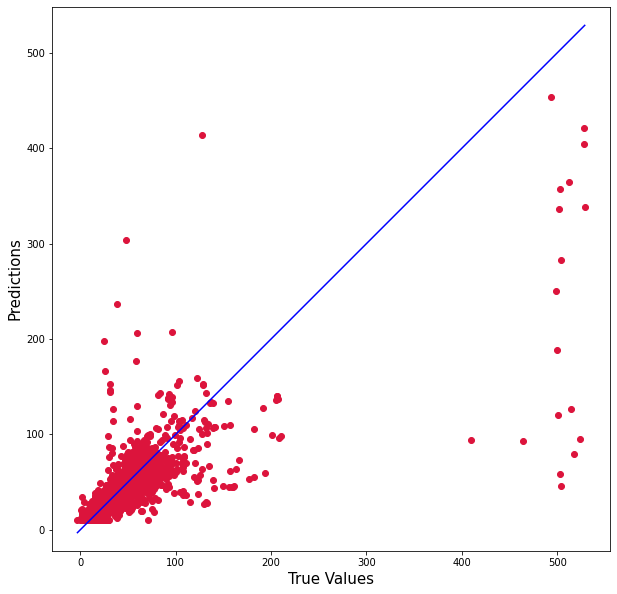

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(pred, y_test, c='crimson')

p1 = max(max(res_df.pred_scale), max(res_df.actual_scale))
p2 = min(min(res_df.pred_scale), min(res_df.actual_scale))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()